# `Process Data`

In [15]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.unicode'] = True
rcParams['figure.figsize'] = 15, 6
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

import transit
import emcee
import corner

import astroML 
from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=14, usetex=True)

import astropy
from astropy import constants as const
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.io import fits
from astropy.table import Table

from scipy import stats
import scipy.optimize as op
import scipy.signal as sig
from scipy.signal import argrelextrema, medfilt
from random import uniform, randrange

import kplr
from kplr.ld import get_quad_coeffs

import time
from collections import Counter, defaultdict, OrderedDict

import glob
#import seaborn; seaborn.set()

# Introduction

## Load the data

In [16]:
path_file = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/clean_bat_files/LC_p13point5up/'
path_mergedLC = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/merge_light_curves/LC_p13point5up_merged/'

properties_sample = pd.read_csv(path_file+'all_targets_P13point5up.csv', sep=',', comment='#')
targets = pd.read_csv(path_file + 'kepler_id.txt',delimiter=',', dtype=int, header=None, names=['kepid'])

In [17]:
df = pd.merge(targets, properties_sample, on=['kepid'], how='inner') 
sc_data = df.drop_duplicates('kepid') #remove duplicates (some systems have both sc and lc LC)

print("Check files:")

if (len(targets) != len(properties_sample)):
    print("*Lengths don't match:", len(targets), len(properties_sample))
    print("\tSome systems have both sc and lc data! Remove duplicates.")

if (len(sc_data) == len(targets)):
    print("*Lengths match:", len(sc_data), len(targets))
    print('\tDuplicates have been removed.\n A total of {} systems have *short-cadence* LC with SN > 7.1 for their first transit and only 1 planet'.format(len(sc_data)))
    
sc_data.shape

Check files:
*Lengths don't match: 56 429
	Some systems have both sc and lc data! Remove duplicates.
*Lengths match: 56 56
	Duplicates have been removed.
 A total of 56 systems have *short-cadence* LC with SN > 7.1 for their first transit and only 1 planet


(56, 141)

## Define the Systems

In [18]:
class System:    
    def __init__(self, kepid, rs, rs_err, smass, smass_err, teff, logg, feh, srho,
                time_BKJD, flux, flux_err, 
                t0, P, depth, b, duration, u1, u2, diffld, num_planets, incl, eccen, dor, sma,
                 transit_times,ind_missed_transits,
                rp, rp_err, teq, mp, 
                 trans_id, ftrans, ftrans_err, ttrans,dt_trans,
                res_transfit, P_distribution, MCMC_transits, rs_transits):
        
        """****** Kepler Reported Stellar Parameters ******"""
        self.kepid = kepid
        self.rs = rs # [Solar radii]. 
        self.rs_err = rs_err
        self.smass = smass # [Solar mass]
        self.smass_err = smass_err
        
        self.teff = teff;     
        self.logg = logg; # Stellar Surface Gravity [log10(cm/s**2)]  
        self.feh = feh;   
        self.srho = srho; #g/cm3
        
        """****** LC parameters ******"""
        self.time_BKJD = time_BKJD
        self.flux = flux
        self.flux_err = flux_err
        
        """****** Transit Parameters ******"""
        self.t0 = t0
        self.P = P;            
        self.depth = depth;  
        self.b = b; 
        self.duration = duration; 
        self.u1 = u1; 
        self.u2 = u2
        self.diffld = 0.0
        self.num_planets = num_planets
        self.incl = incl #[º]
        self.eccen = 0.0
        self.dor = dor #Planet-Star Distance over Star Radius
        self.sma = sma #Orbital semi-major axis [AU]
        
        self.transit_times = transit_times
        self.ind_missed_transits = ind_missed_transits
        #self.depth = rprs ** 2 
            # Transit depth in absolute terms. To 1st order (assuming stellar disk has uniform brightness and 
            # neglecting any flux coming from planet), the ratio X of the observed change in flux, Delta(F), 
            # to that of the stellar flux F is: X = (Rp/Rs)^2 = depth.
                   
        """****** Planetary Parameters ******"""
        self.rp = rp # [Earth radii]. This is "prad"  in the original file
        self.rp_err = rp_err
        self.teq = teq
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. It requires Rp in Earth radii
        
        """****** Internal Variables ******"""
        self.trans_id = np.empty(0)
        self.ftrans = np.empty(0)
        self.ftrans_err = np.empty(0)
        self.ttrans = np.empty(0)
        self.dt_trans = np.empty(0)
        self.res_transfit = np.empty(0)
        self.P_distribution = np.empty(0)
        self.MCMC_transits = np.empty(0)
        
        self.rs_transits = np.empty(0)

## Characterize the Systems

Some initialization functions

In [19]:
bjd_ref = 2454833

def quadraticLD(T, G, FEH): 
    """Confirm the quadratic LD coefficients with a model from Claret & Bloemen (2011).
    Use the Claret coefficients instead."""
    mu1, mu2 = get_quad_coeffs(T, G, FEH)
    return (mu1, mu2)

def fetchLC(name):
    id_kep = "%.0f" % name
    lc = path_mergedLC+('KID'+id_kep+'.txt')
    df = pd.read_csv(lc, sep="\t", skiprows=1, header=None, names=["Time BKJD", "Flux", "Flux_Err"])
    y = df['Flux']
    yerr = df['Flux_Err']
    x = df['Time BKJD']
    #print(np.median(y),np.mean(y),np.std(y))
    return (y, yerr, x)

Create the planet+star system.

In [20]:
targets = []

for row in sc_data.itertuples(index = True, name='Pandas'):
    kepid = getattr(row, "kepid")
    fluxLC, fluxLC_err, timeLC_BKJD = fetchLC(kepid)

    ## Store the stellar parameters
    rs = getattr(row, "koi_srad") #solar radii
    smass = getattr(row, "koi_smass")
    #Assuming that we have a 5% error on radius and mass (this is sensible thanks to Gaia)
    rs_err = rs*0.05
    smass_err = smass*0.05
    
    #rs_errPos = getattr(row, "koi_srad_err1"); rs_errNeg = getattr(row, "koi_srad_err2")
    #rs_err = np.abs((rs_errPos+rs_errNeg)/2.)
    
    #smass_errPos = getattr(row, "koi_smass_err1"); smass_errNeg = getattr(row, "koi_smass_err2")
    #smass_err = np.abs((smass_errPos+smass_errNeg)/2.)
    
    teff = getattr(row, "koi_steff")
    logg = getattr(row, "koi_slogg") # Stellar Surface Gravity [log10(cm/s**2)]  
    feh = getattr(row, "koi_smet")
    srho = getattr(row, "koi_srho") #g/cm3
    
    #### Store LC Parameters
    t0 = getattr(row, "koi_time0bk")
    P = getattr(row, "koi_period") # Orbital Period [days]
    depth = getattr(row, "koi_depth")/1e6
    b = getattr(row, "koi_impact")
    
    u1, u2 = quadraticLD(teff,logg,feh)

    num_planets = getattr(row, "koi_count")
    incl =  getattr(row, "koi_incl") #in degrees
    dor = getattr(row, "koi_dor")  #Planet-Star Distance over Star Radius
    
    time0bk = getattr(row, "koi_time0bk")
    duration = getattr(row, "koi_duration")/24. #in days. "Duration is measured from first contact between the planet and star until last contact."
    
    #Planetary parameters
    sma = getattr(row, "koi_sma")  #Orbit Semi-Major Axis [AU]
    sma_solarRad = sma*215
    teq = getattr(row, "koi_teq") 
    rp = getattr(row, "koi_prad") # in Earth radii
    rp_solarRad = getattr(row, "koi_prad")*0.009168 # in solar radii
    rp_errPos = getattr(row, "koi_prad_err1"); rp_errNeg = getattr(row, "koi_prad_err2")
    rp_err = np.abs((rp_errPos+rp_errNeg)/2.)
        
    if (num_planets == 1):
        system = System(kepid, rs, rs_err, smass, smass_err, teff, logg, feh, srho,
                    timeLC_BKJD, fluxLC, fluxLC_err, 
                    t0, P, depth, b, duration, u1, u2, u1-u2, num_planets, incl, 0.0, dor, sma,
                        None, None,
                    rp, rp_err, teq, None, 
                        None, None, None, None, None,
                       None, None, None, None)

        targets.append(system)
                
    else:
        print('Star {:s} not stored (koi_count > 1)'.format(str(kepid)))

# Transit Detection

In [21]:
def find_transits(star):
    ti = min(star.time_BKJD)
    tf = max(star.time_BKJD)
    
    n_min = int((ti-star.t0)/star.P)
    n_max = int((tf-star.t0)/star.P+1.)
    n = np.arange(n_min, n_max)
    
    t = star.t0+n*star.P
    t = t[t>ti] 
    t = t[t<tf]
    return(t)

In [22]:
def show_folded_lightcurve(star, plot=False):
    if plot==True:
        plt.figure(figsize=(15,6))
        plt.plot(star.dt_trans,star.ftrans,'.')     
        plt.title(r'Folded LC for KID'+str(star.kepid))
        plt.xlabel(r'Time BKJD [d]'); plt.ylabel('Normalized Flux')
        plt.show(block=False)    
        time.sleep(0.3)
        plt.close()

def mark_transits(star, obs_trans, plot=False):
    if plot==True:
        plt.figure(figsize=(15,6))
        plt.plot(star.time_BKJD,star.flux,'.')        
        for j in range(len(star.transit_times)): 
            plt.axvline(star.transit_times[j], color='k', ls='-')
        for k in range(len(obs_trans)): 
            plt.axvline(obs_trans[k], color='r', ls='--')
        plt.title(r'KID'+str(star.kepid))
        plt.xlabel(r'Time BKJD [d]'); plt.ylabel(r'Normalized Flux')
        plt.show(block=False)    
        time.sleep(0.3)
        plt.close()
        
def show_transits(star, bad_trans, plot=False):        
    s1 = set(bad_trans)
    if plot==True:   
        for i in range(len(star.transit_times)):
            if (i not in bad_trans):
                plt.figure(figsize=(15,6))
                plt.title('Folded Light Curve')
                plt.plot(star.ttrans[star.trans_id==i]-star.transit_times[i],star.ftrans[star.trans_id==i], 'k.')     
                plt.title("Transit "+str(i+1))
                plt.xlabel(r'Time [d]'); plt.ylabel('Normalized Flux')
                plt.show(block=False)    
                time.sleep(0.3)
                plt.close()

In [23]:
def get_data_in_transit(star, factor):
    window = star.duration # In days
    total_points = 0
    
    for i in range(0,len(star.transit_times)):
        residual = star.time_BKJD - star.transit_times[i]
        points_in_transit = np.abs(residual) <= window
        total_points += np.sum(points_in_transit)

    time_in_transit = np.empty(total_points)
    flux_in_transit = np.empty(total_points)
    flux_err_in_transit = np.empty(total_points)
    flag_transit = np.empty(total_points)
    mid_trans = np.empty(total_points)

    total_points = 0

    for i in range(0, len(star.transit_times)):
        points_in_transit = np.abs(star.time_BKJD - star.transit_times[i]) <= window
        count_points = np.sum(points_in_transit)
        time_in_transit[(0 + total_points):(count_points + total_points)] = star.time_BKJD[points_in_transit]
        flux_in_transit[(0 + total_points):(count_points + total_points)] = star.flux[points_in_transit] #, star.flux_err[points_in_transit])[0]
        flux_err_in_transit[(0 + total_points):(count_points + total_points)] = star.flux_err[points_in_transit] #normalize(star.flux[points_in_transit], 
        flag_transit[(0 + total_points):(count_points + total_points)] = i
        mid_trans[(0 + total_points):(count_points + total_points)] = star.transit_times[i] 
        total_points += count_points
        
        
    star.trans_id = flag_transit
    star.ttrans = time_in_transit
    star.ftrans = flux_in_transit
    star.ftrans_err = flux_err_in_transit
    star.dt_trans = time_in_transit - mid_trans #if interested in the folded LC, plot target.dt_trans vs target.ftrans

In [24]:
def oot_fit(star, polyorder):
    transit_range = star.duration/2 #in days
    for i in range(0, len(star.transit_times)):
        dt = star.ttrans[star.trans_id == i] - star.transit_times[i]
        y = star.ftrans[star.trans_id==i]
        outside_trans = np.abs(dt) >= transit_range
        inside_trans = np.abs(dt) < transit_range
        num_oot_points = len(dt[outside_trans])
        
        if  (num_oot_points!= 0):
            z = np.polyfit(dt[outside_trans], y[outside_trans], polyorder)
            p = np.poly1d(z)
            y = y/p(dt)

In [25]:
def find_missed_transits(star):
    gaps = []
    for i in range(len(star.transit_times)):
        if len(star.ttrans[star.trans_id==i])==0: 
            gaps.append(i)
    missing_transits = sorted(gaps, reverse=True)
    return(missing_transits)

In [26]:
def export_folded_lc(system):
    lc = pd.DataFrame(OrderedDict({'Time': system.time_BKJD, 'Flux': system.flux, 'Flux_Err': system.flux_err}))
     
    np.savetxt("/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/folded_LC/"+str(system.kepid)+".txt", 
               lc.values, fmt='%f', delimiter="\t") 

The code below performs two functions: 
    1. It identifies the light curves that don't have a visible transit. (With the data being used as of June 30, this amounts to 4 systems).
    2. For the remaining light curves, it calculates all the expected transits and then looks at which transits are actually visible (sometimes, there are gaps in the data and transits are lost). 

In [ ]:
stars_wo_transits = []
poly_order = 2
amplify = 1
print("amplify:", amplify)

amplify: 1



******************************** KID5009743 ********************************



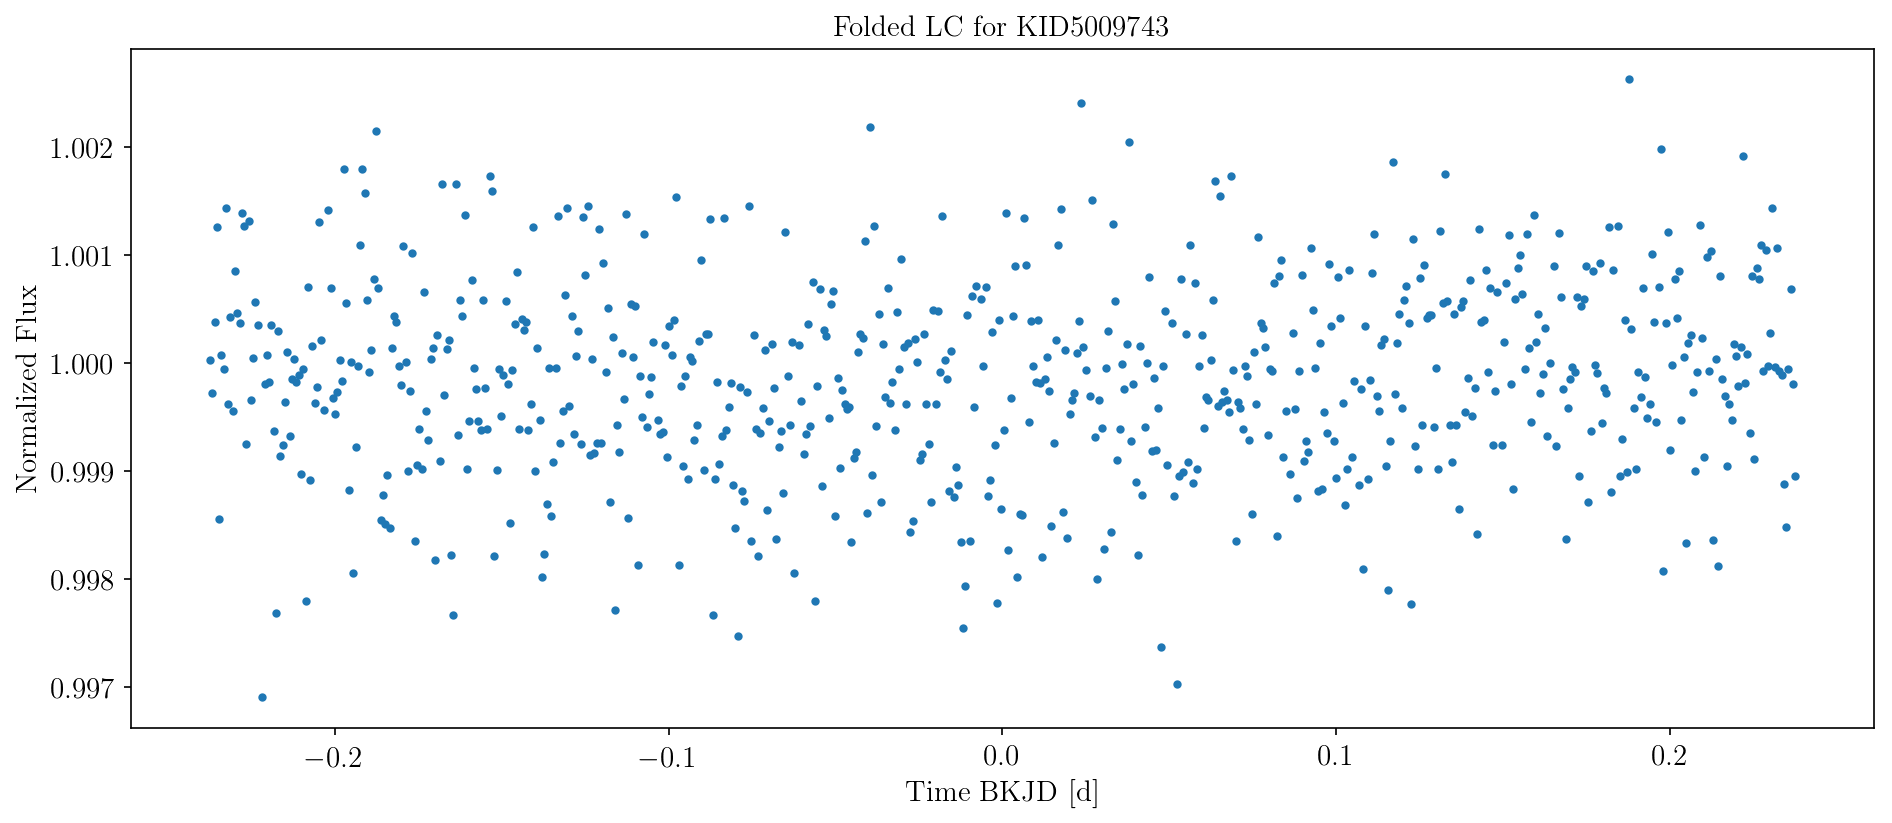

Transit duration: 0.2377 [d]
Period: 41.6980186 [d]
Estimated transits at (1): [878.4417962]
Observed transits at (1): [878.4417962]
Index of missed transits: []

******************************** KID8802165 ********************************



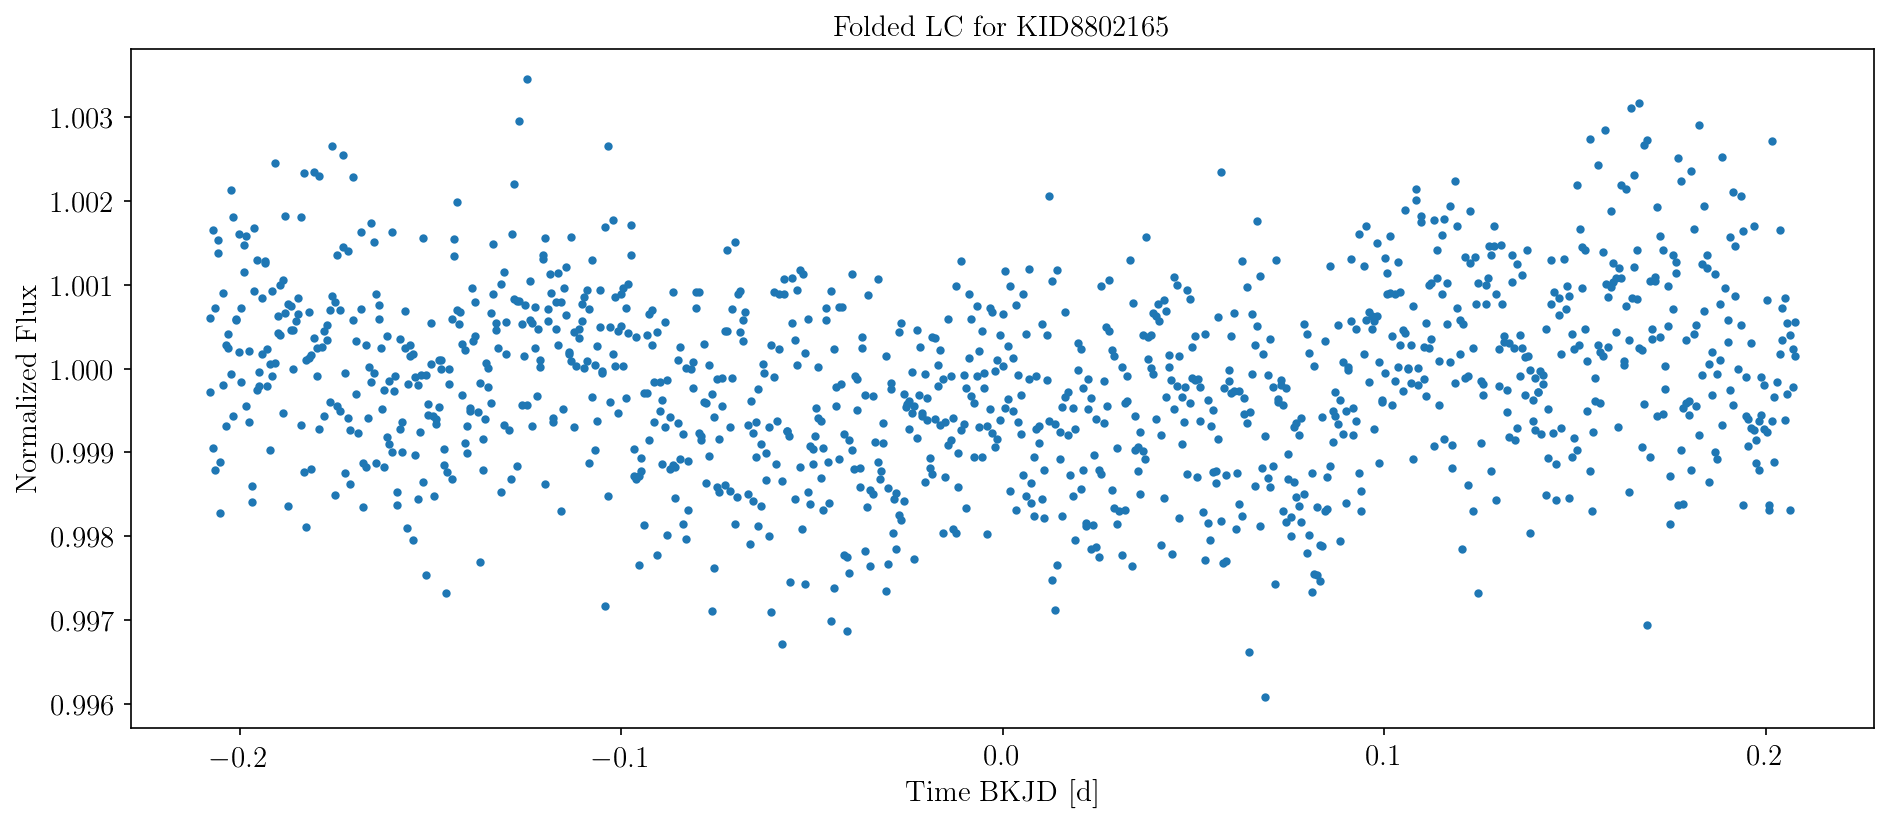

Transit duration: 0.20822 [d]
Period: 17.42115972 [d]
Estimated transits at (2): [759.14417676 776.56533648]
Observed transits at (2): [759.14417676 776.56533648]
Index of missed transits: []

******************************** KID6471021 ********************************



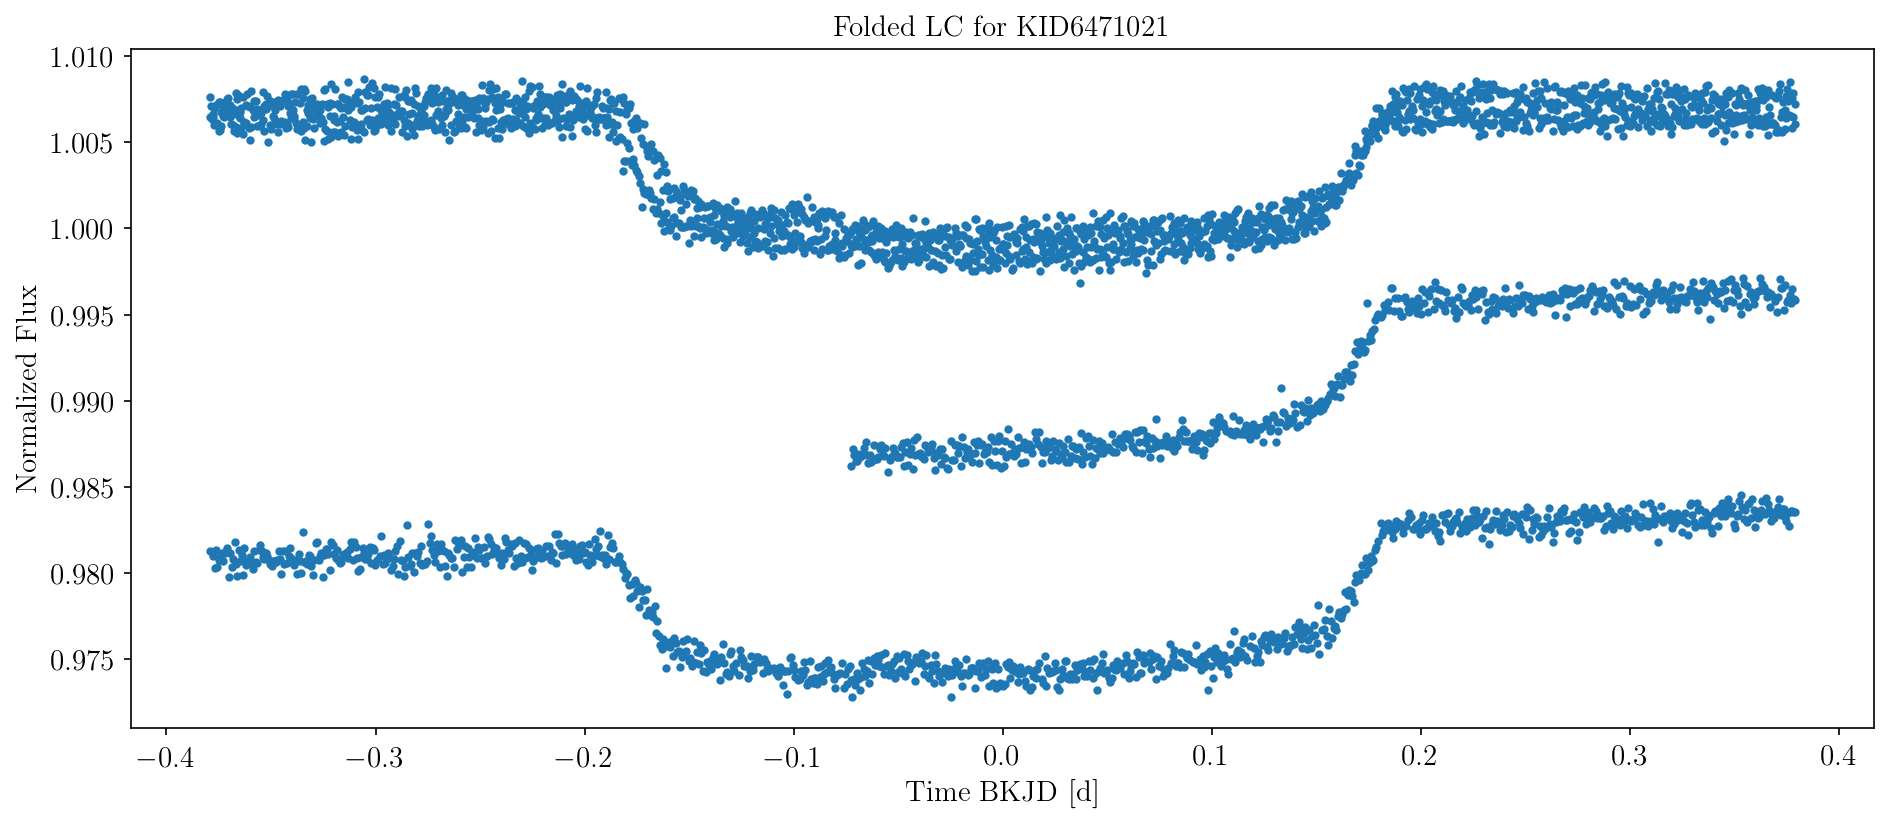

Transit duration: 0.3795 [d]
Period: 125.6291479 [d]
Estimated transits at (9): [ 504.6090858  630.2382337  755.8673816  881.4965295 1007.1256774
 1132.7548253 1258.3839732 1384.0131211 1509.642269 ]
Observed transits at (4): [ 630.2382337 1258.3839732 1384.0131211 1509.642269 ]
Index of missed transits: [5, 4, 3, 2, 0]

******************************** KID11133306 ********************************



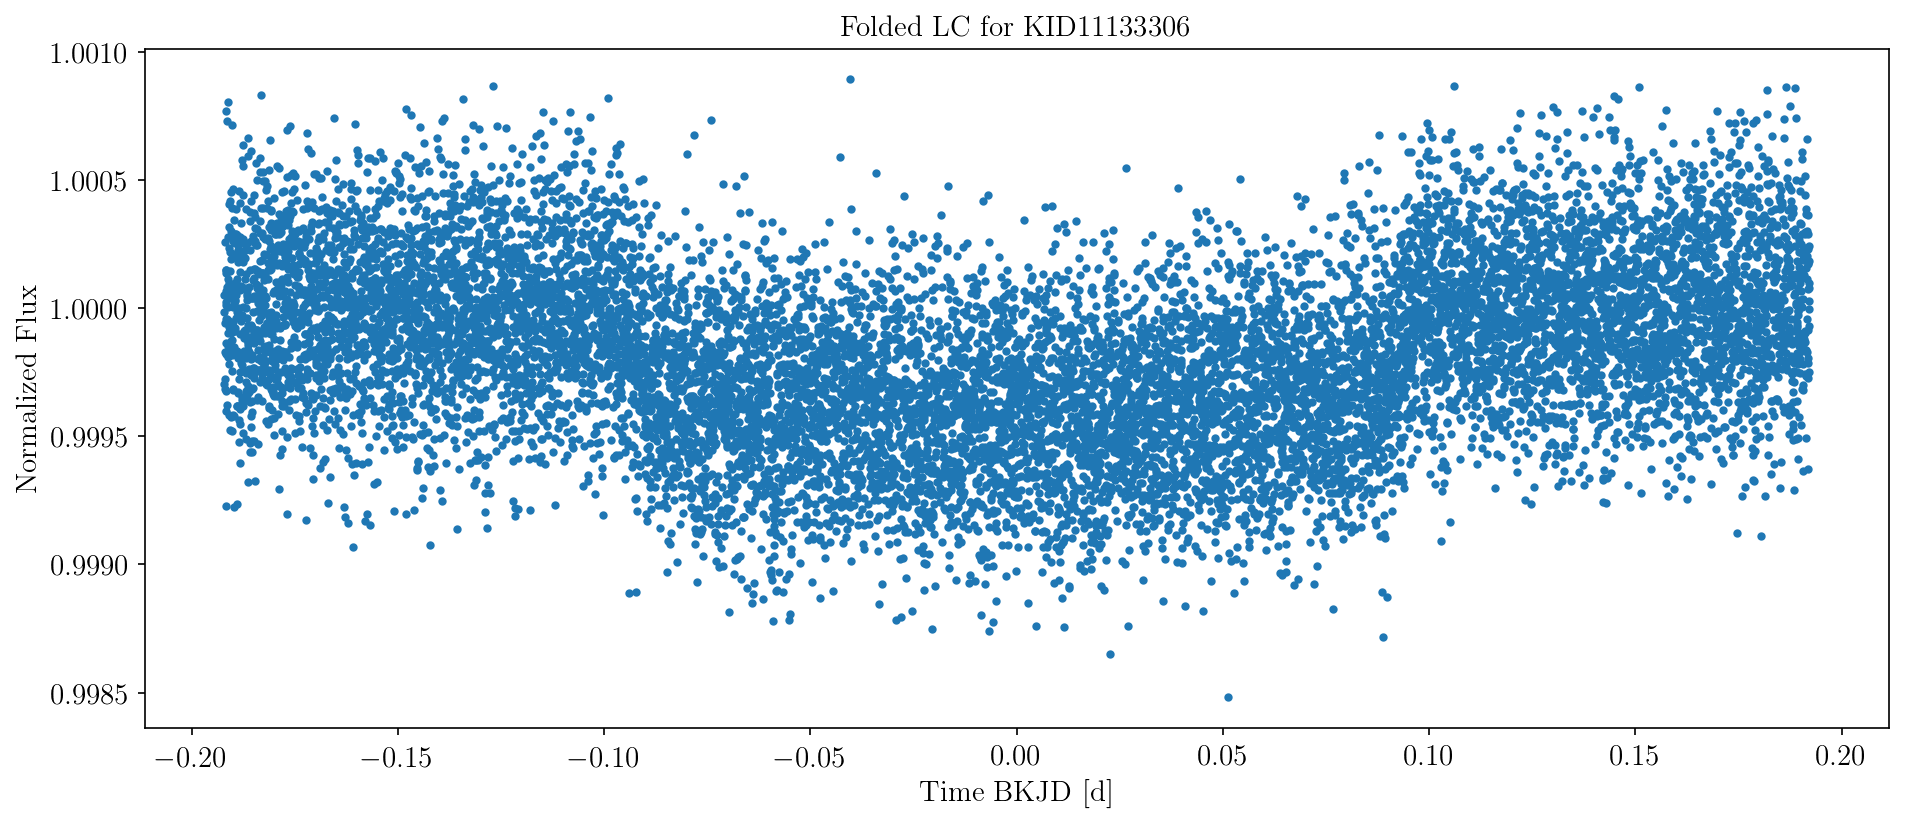

Transit duration: 0.19219 [d]
Period: 41.74598855 [d]
Estimated transits at (26): [ 544.3670594   586.11304795  627.8590365   669.60502505  711.3510136
  753.09700215  794.8429907   836.58897925  878.3349678   920.08095635
  961.8269449  1003.57293345 1045.318922   1087.06491055 1128.8108991
 1170.55688765 1212.3028762  1254.04886475 1295.7948533  1337.54084185
 1379.2868304  1421.03281895 1462.7788075  1504.52479605 1546.2707846
 1588.01677315]
Observed transits at (25): [ 544.3670594   586.11304795  627.8590365   669.60502505  711.3510136
  753.09700215  794.8429907   836.58897925  878.3349678   920.08095635
  961.8269449  1003.57293345 1045.318922   1087.06491055 1128.8108991
 1170.55688765 1212.3028762  1254.04886475 1337.54084185 1379.2868304
 1421.03281895 1462.7788075  1504.52479605 1546.2707846  1588.01677315]
Index of missed transits: [18]

******************************** KID5164255 ********************************



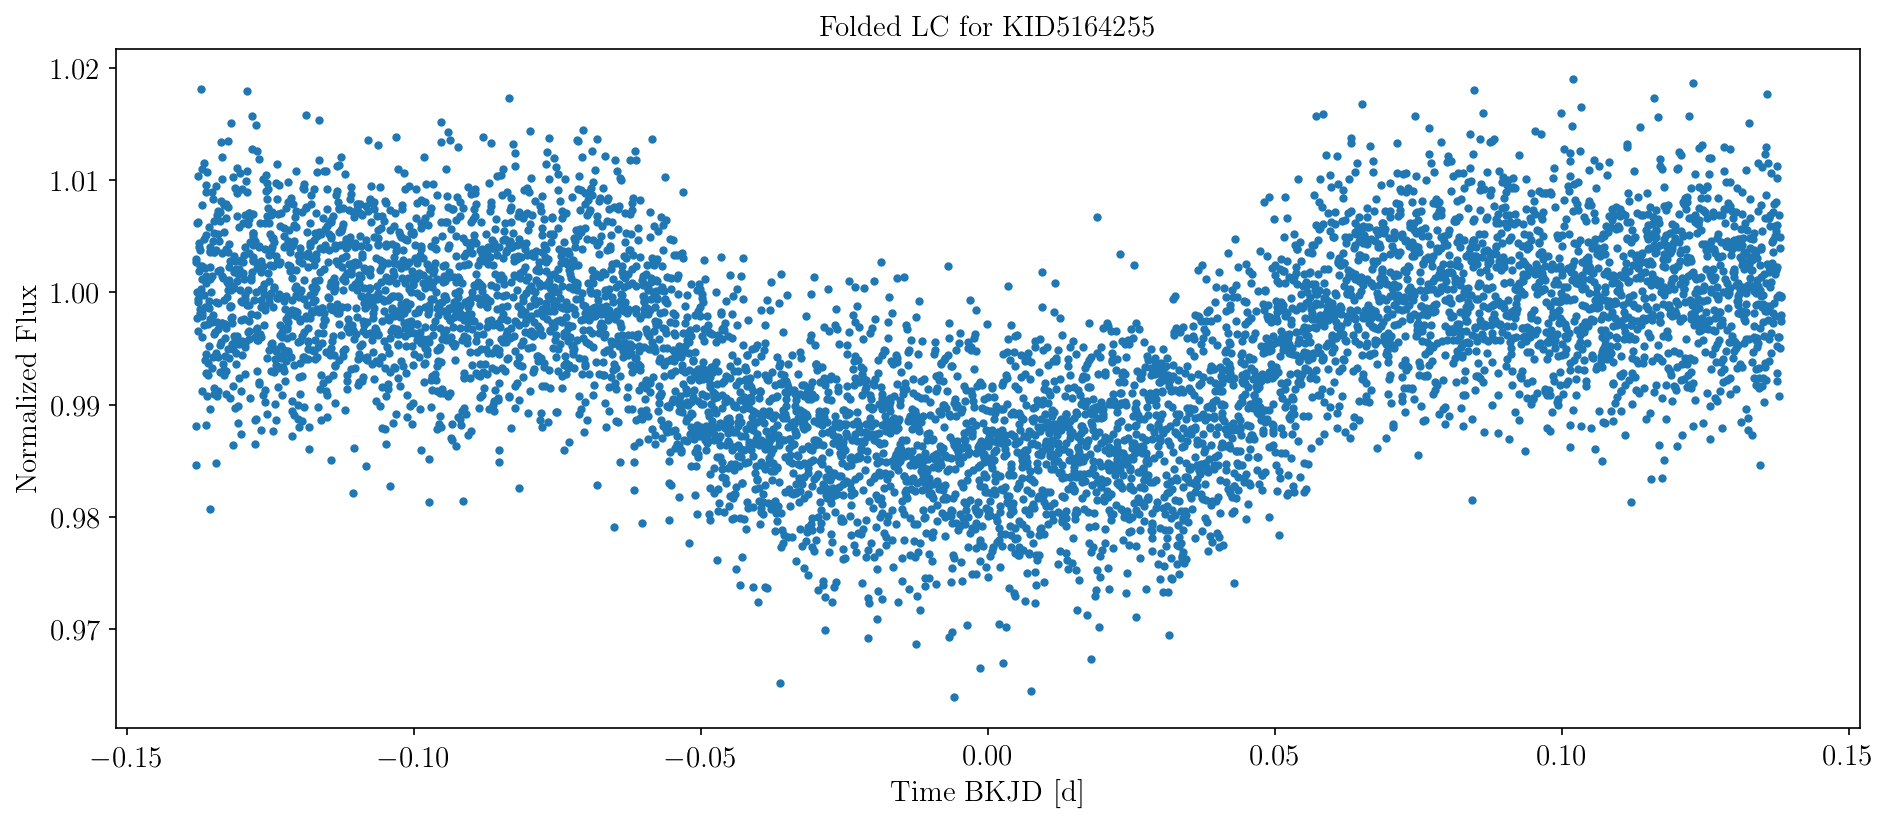

Transit duration: 0.1382 [d]
Period: 15.37562369 [d]
Estimated transits at (19): [1280.65892568 1296.03454937 1311.41017306 1326.78579675 1342.16142044
 1357.53704413 1372.91266782 1388.28829151 1403.6639152  1419.03953889
 1434.41516258 1449.79078627 1465.16640996 1480.54203365 1495.91765734
 1511.29328103 1526.66890472 1542.04452841 1557.4201521 ]
Observed transits at (16): [1280.65892568 1311.41017306 1326.78579675 1342.16142044 1357.53704413
 1388.28829151 1403.6639152  1419.03953889 1434.41516258 1449.79078627
 1465.16640996 1495.91765734 1511.29328103 1526.66890472 1542.04452841
 1557.4201521 ]
Index of missed transits: [13, 6, 1]

******************************** KID10795103 ********************************

Transit duration: 0.67891 [d]
Period: 214.3120439 [d]
Estimated transits at (0): []
Observed transits at (0): []
Index of missed transits: []

******************************** KID10864656 ********************************



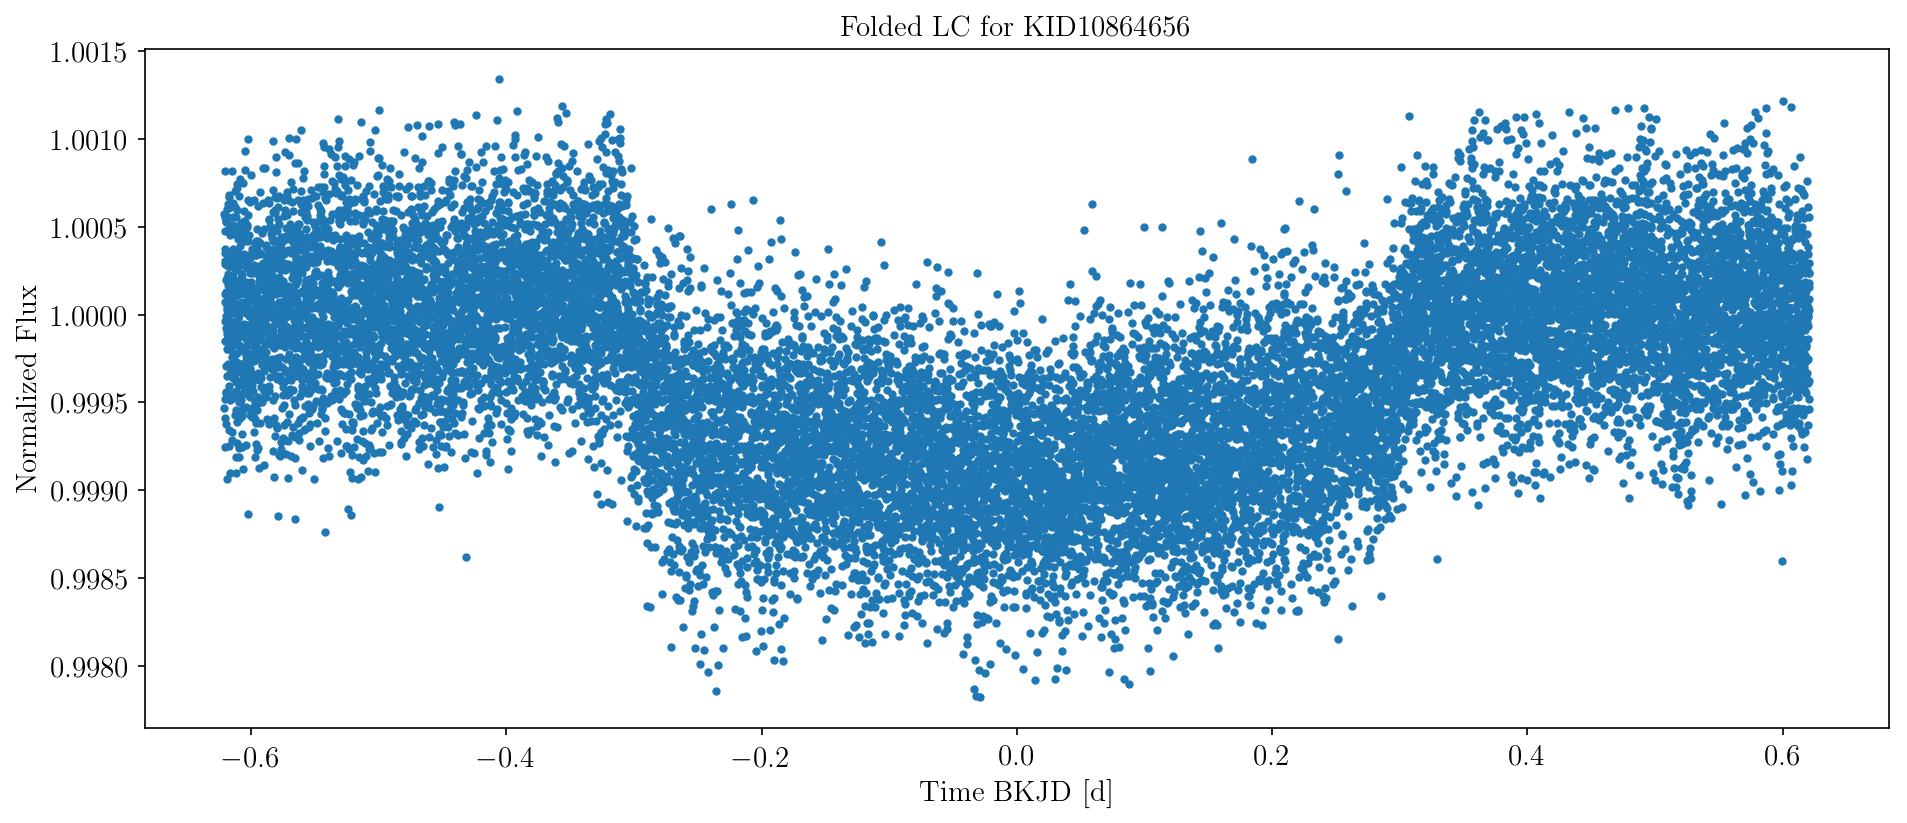

Transit duration: 0.62111 [d]
Period: 52.5008645 [d]
Estimated transits at (15): [ 854.0323785  906.533243   959.0341075 1011.534972  1064.0358365
 1116.536701  1169.0375655 1221.53843   1274.0392945 1326.540159
 1379.0410235 1431.541888  1484.0427525 1536.543617  1589.0444815]
Observed transits at (12): [ 854.0323785  906.533243   959.0341075 1011.534972  1064.0358365
 1116.536701  1169.0375655 1221.53843   1379.0410235 1431.541888
 1536.543617  1589.0444815]
Index of missed transits: [12, 9, 8]

******************************** KID11259686 ********************************



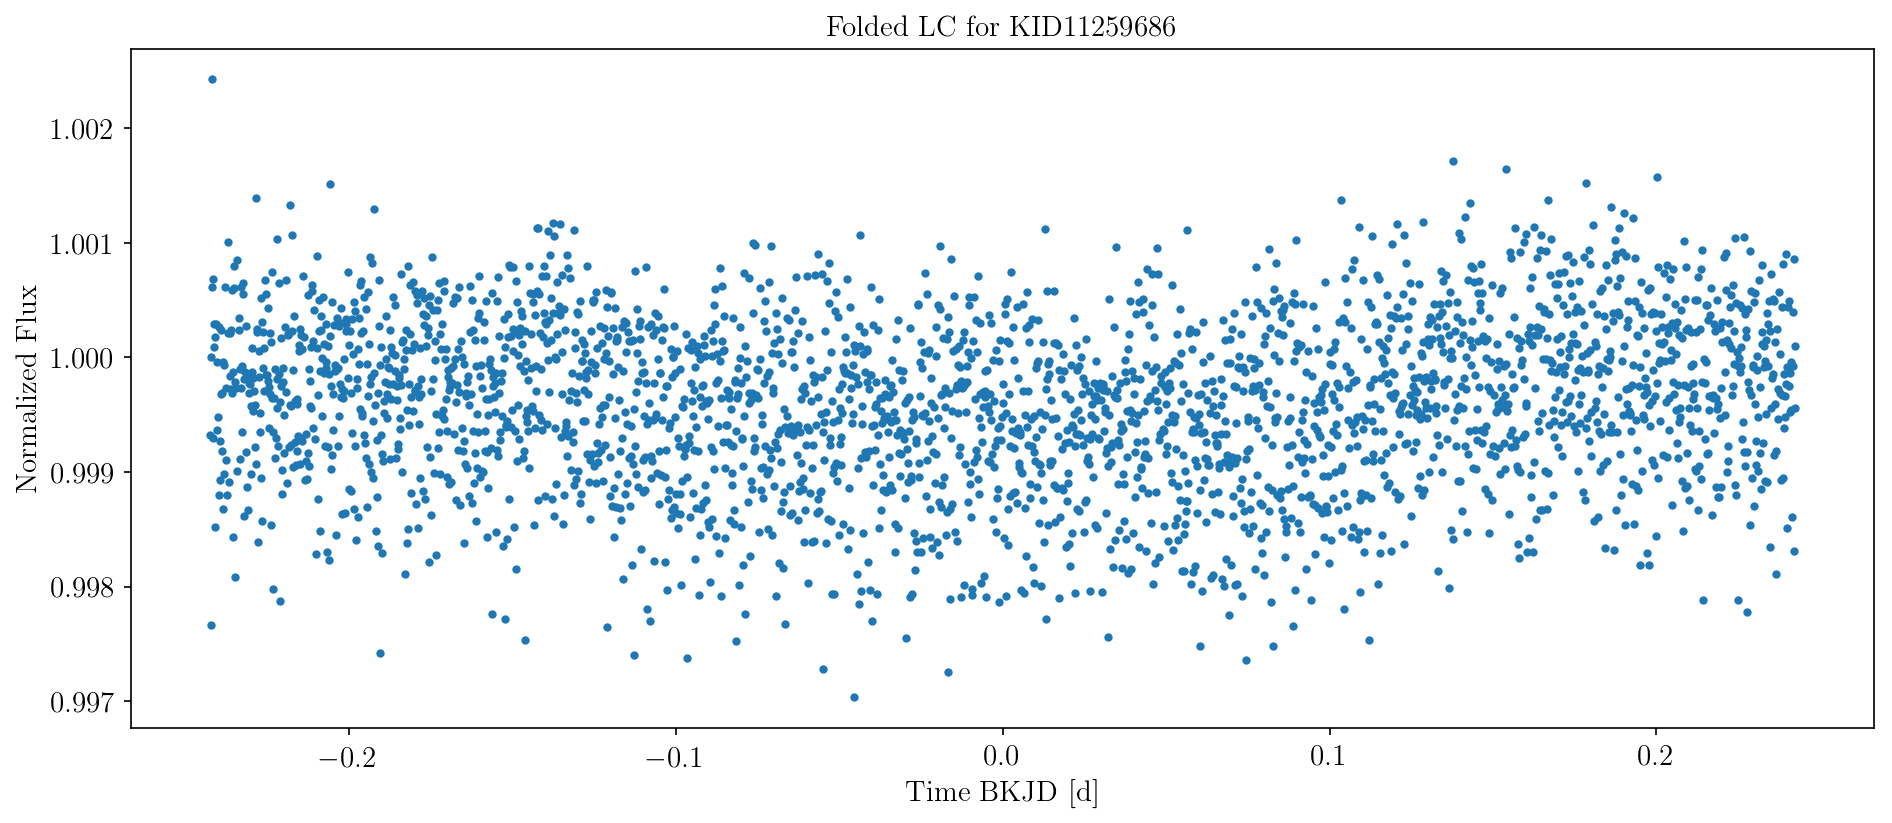

Transit duration: 0.2425 [d]
Period: 34.4359387 [d]
Estimated transits at (7): [571.8333257 606.2692644 640.7052031 675.1411418 709.5770805 744.0130192
 778.4489579]
Observed transits at (4): [571.8333257 606.2692644 744.0130192 778.4489579]
Index of missed transits: [4, 3, 2]

******************************** KID6707835 ********************************



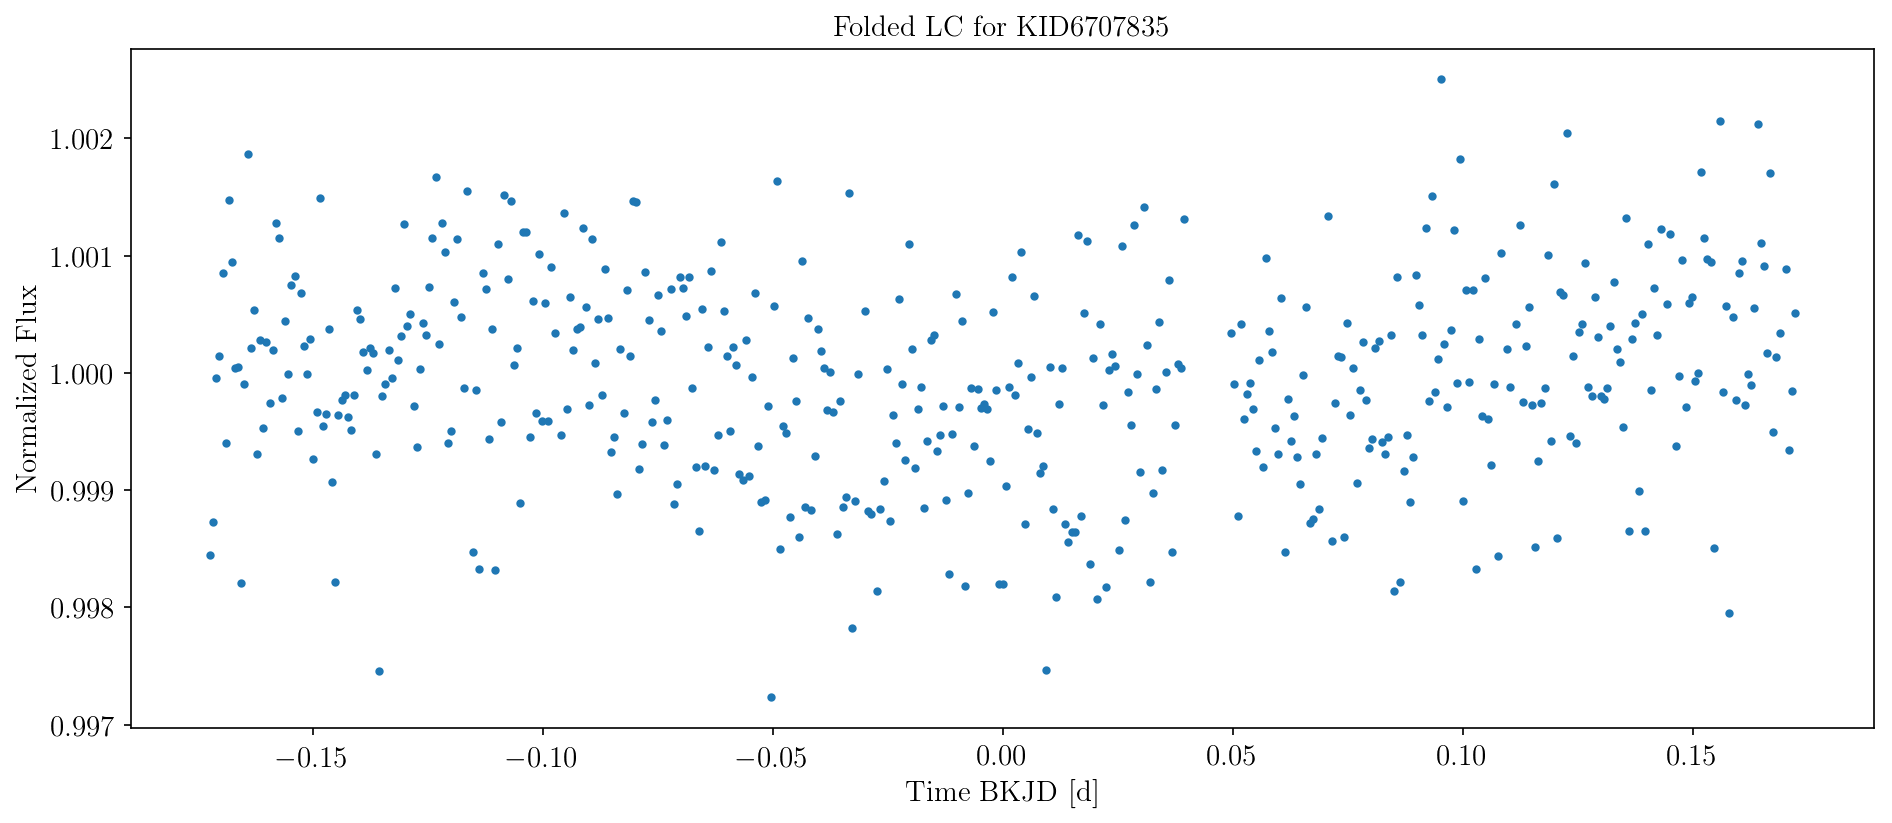

Transit duration: 0.17285 [d]
Period: 22.24814617 [d]
Estimated transits at (1): [774.83670659]
Observed transits at (1): [774.83670659]
Index of missed transits: []

******************************** KID8686097 ********************************



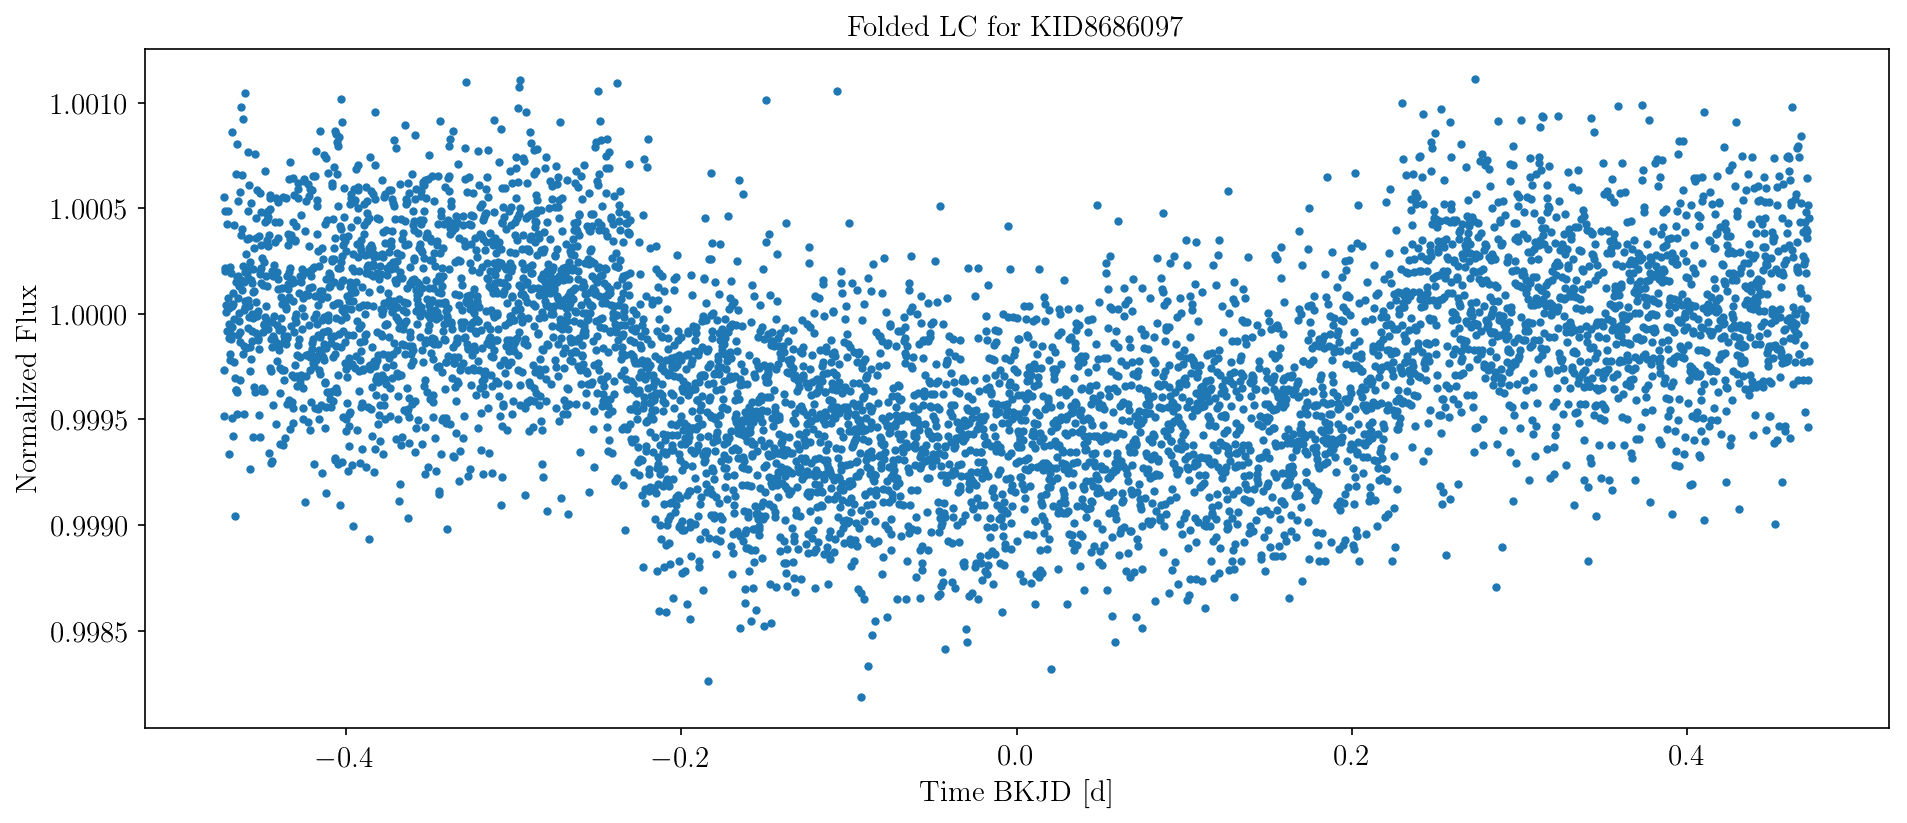

Transit duration: 0.47279 [d]
Period: 172.7046083 [d]
Estimated transits at (5): [ 755.0395649  927.7441732 1100.4487815 1273.1533898 1445.8579981]
Observed transits at (5): [ 755.0395649  927.7441732 1100.4487815 1273.1533898 1445.8579981]
Index of missed transits: []

******************************** KID5966322 ********************************



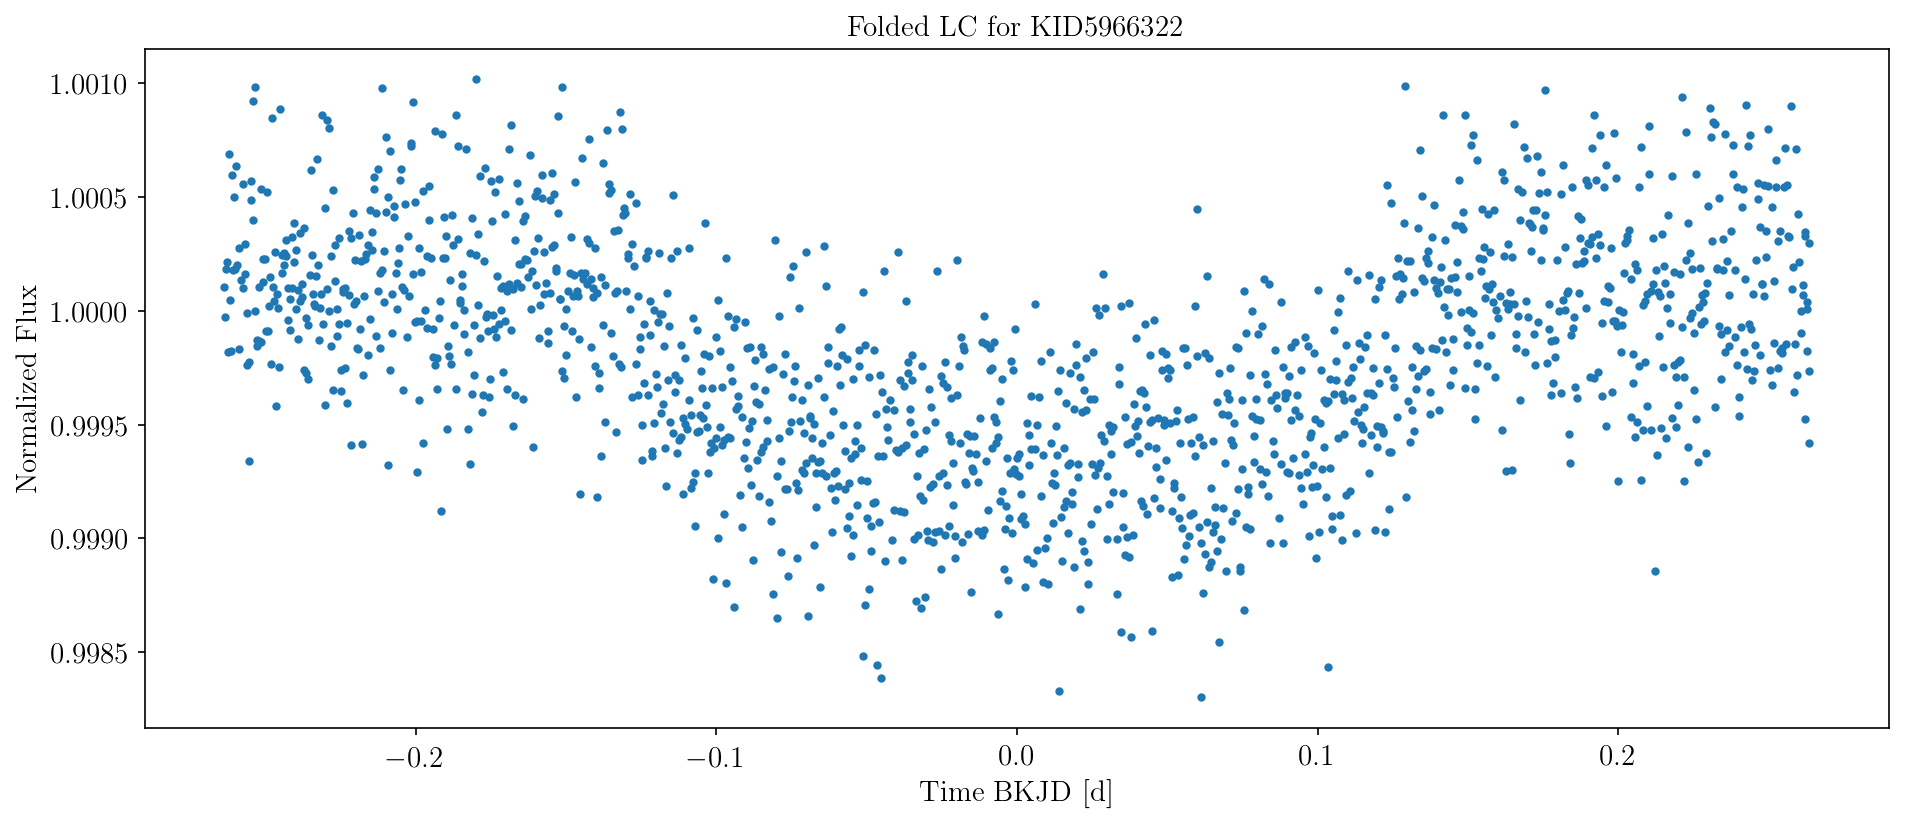

Transit duration: 0.2639 [d]
Period: 60.92818866 [d]
Estimated transits at (4): [599.86944062 660.79762928 721.72581794 782.6540066 ]
Observed transits at (3): [599.86944062 660.79762928 782.6540066 ]
Index of missed transits: [2]

******************************** KID11015108 ********************************



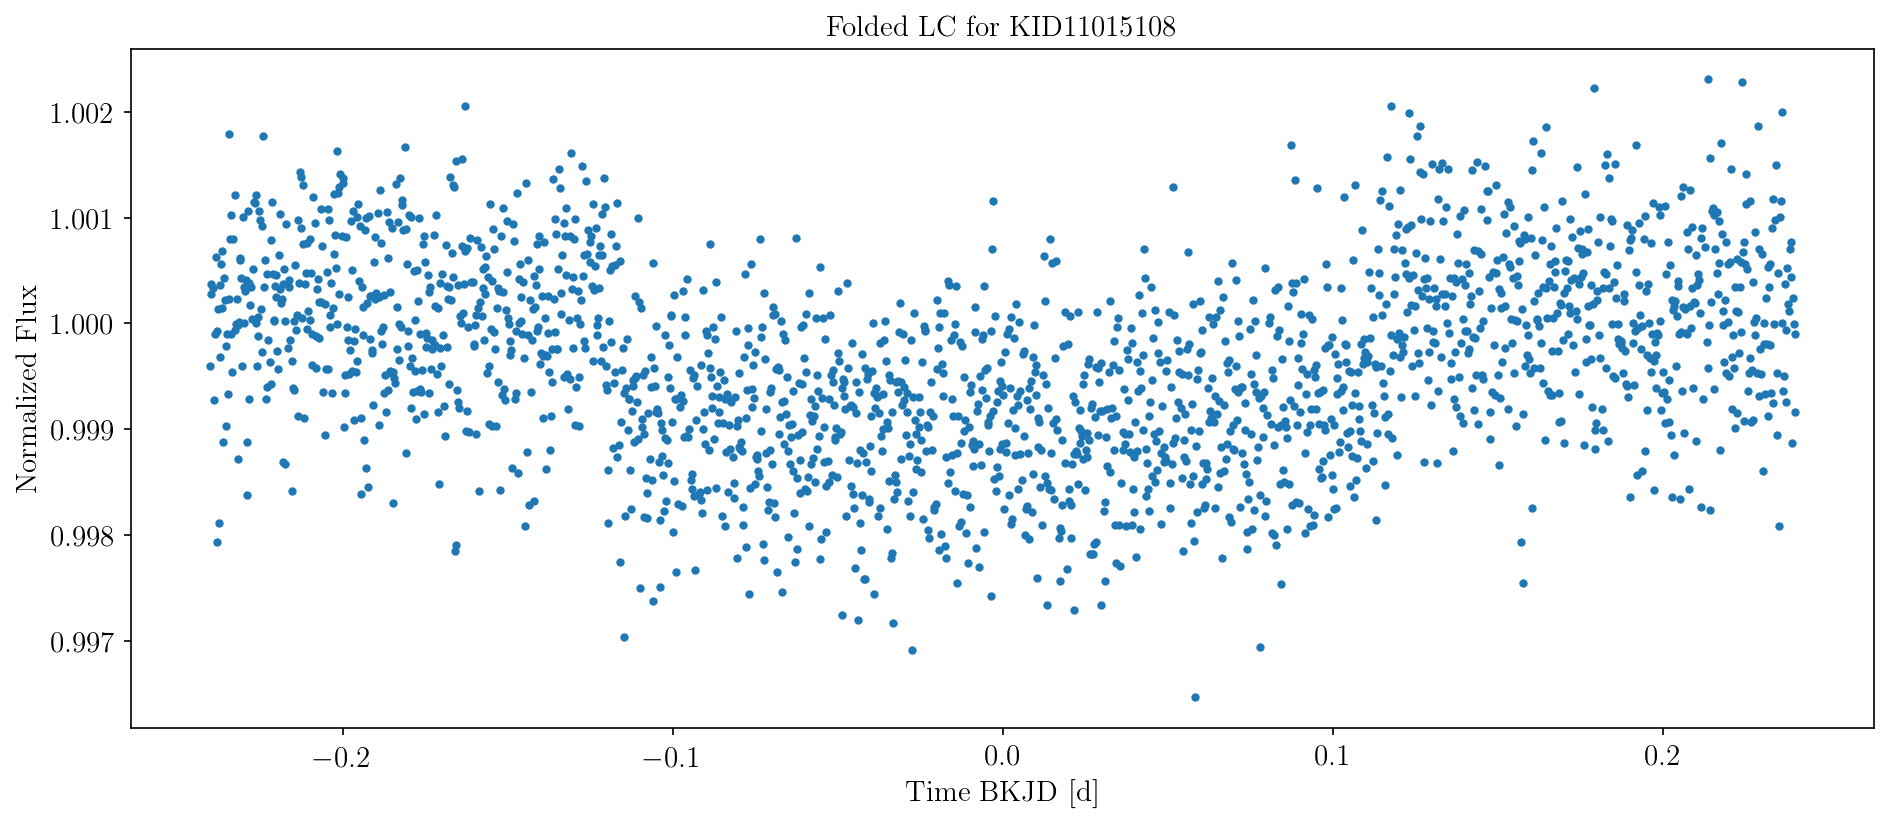

Transit duration: 0.24042 [d]
Period: 39.30944096 [d]
Estimated transits at (3): [564.4292706  603.73871156 643.04815252]
Observed transits at (3): [564.4292706  603.73871156 643.04815252]
Index of missed transits: []

******************************** KID10593626 ********************************



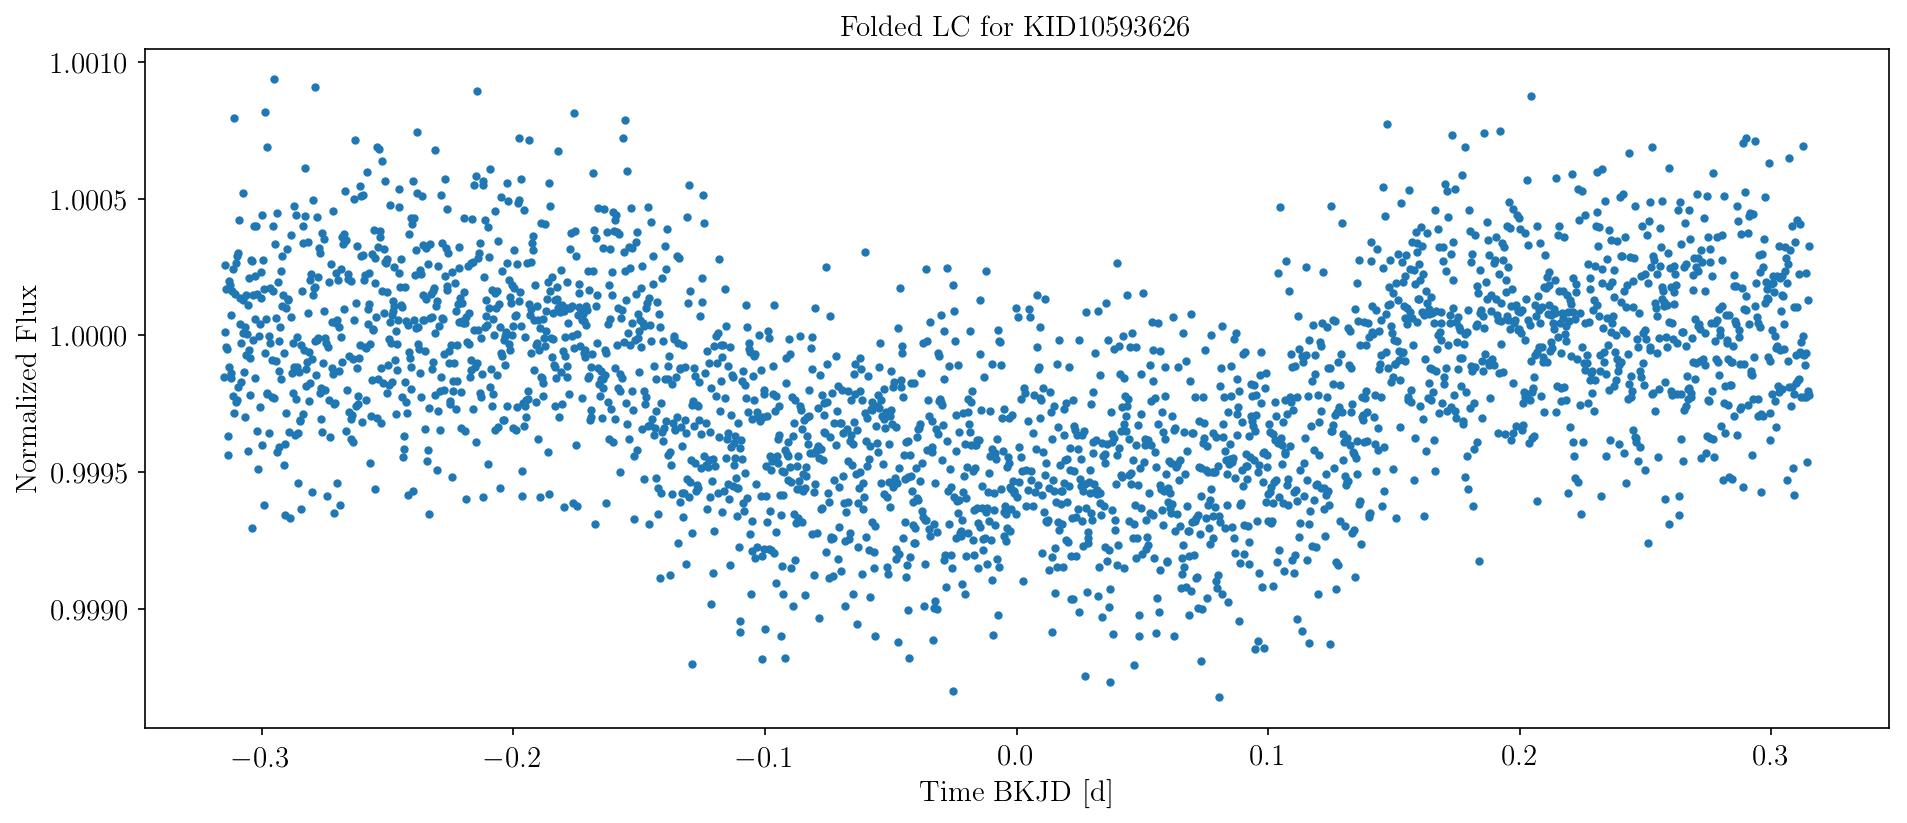

Transit duration: 0.31521 [d]
Period: 289.864067 [d]
Estimated transits at (5): [ 423.561257  713.425324 1003.289391 1293.153458 1583.017525]
Observed transits at (3): [ 423.561257  713.425324 1003.289391]
Index of missed transits: [4, 3]

******************************** KID3835670 ********************************



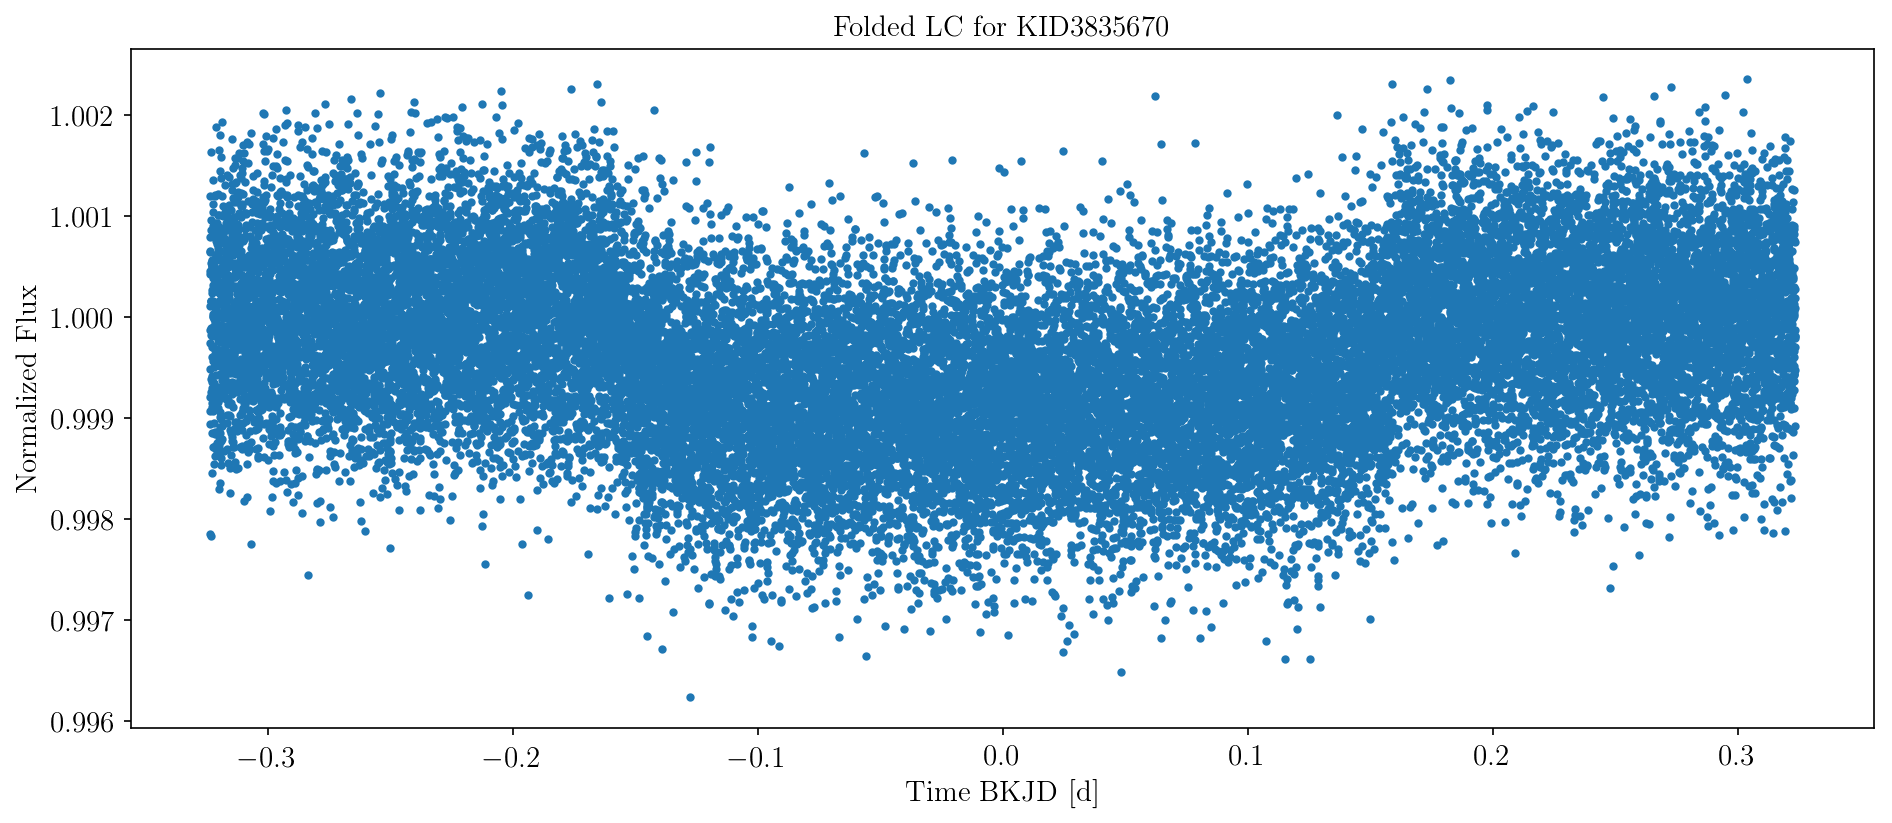

Transit duration: 0.32351 [d]
Period: 14.55730897 [d]
Estimated transits at (38): [261.55348376 276.11079273 290.6681017  305.22541067 319.78271964
 334.34002861 348.89733758 363.45464655 378.01195552 392.56926449
 407.12657346 421.68388243 436.2411914  450.79850037 465.35580934
 479.91311831 494.47042728 509.02773625 523.58504522 538.14235419
 552.69966316 567.25697213 581.8142811  596.37159007 610.92889904
 625.48620801 640.04351698 654.60082595 669.15813492 683.71544389
 698.27275286 712.83006183 727.3873708  741.94467977 756.50198874
 771.05929771 785.61660668 800.17391565]
Observed transits at (32): [261.55348376 276.11079273 290.6681017  305.22541067 319.78271964
 334.34002861 348.89733758 363.45464655 378.01195552 392.56926449
 407.12657346 421.68388243 436.2411914  509.02773625 523.58504522
 552.69966316 567.25697213 581.8142811  596.37159007 610.92889904
 625.48620801 640.04351698 654.60082595 669.15813492 683.71544389
 698.27275286 712.83006183 741.94467977 756.50198874 771.0

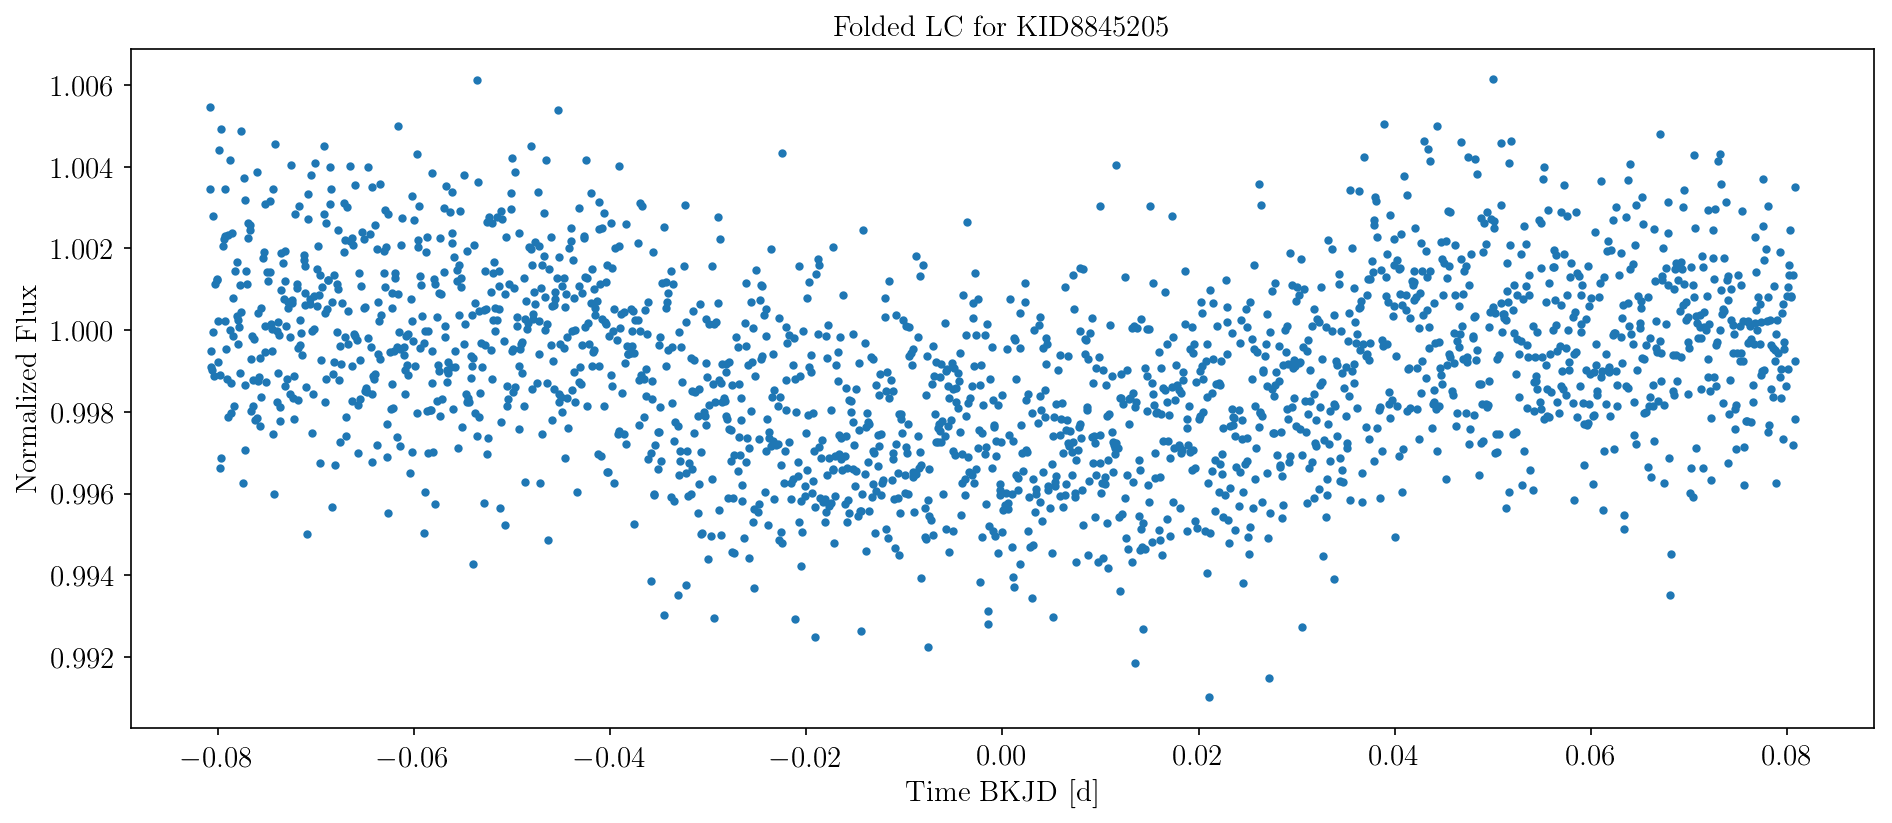

Transit duration: 0.080833 [d]
Period: 18.47762694 [d]
Estimated transits at (11): [1275.44905046 1293.9266774  1312.40430434 1330.88193128 1349.35955822
 1367.83718516 1386.3148121  1404.79243904 1423.27006598 1441.74769292
 1460.22531986]
Observed transits at (9): [1275.44905046 1312.40430434 1330.88193128 1349.35955822 1367.83718516
 1386.3148121  1423.27006598 1441.74769292 1460.22531986]
Index of missed transits: [7, 1]

******************************** KID8950853 ********************************



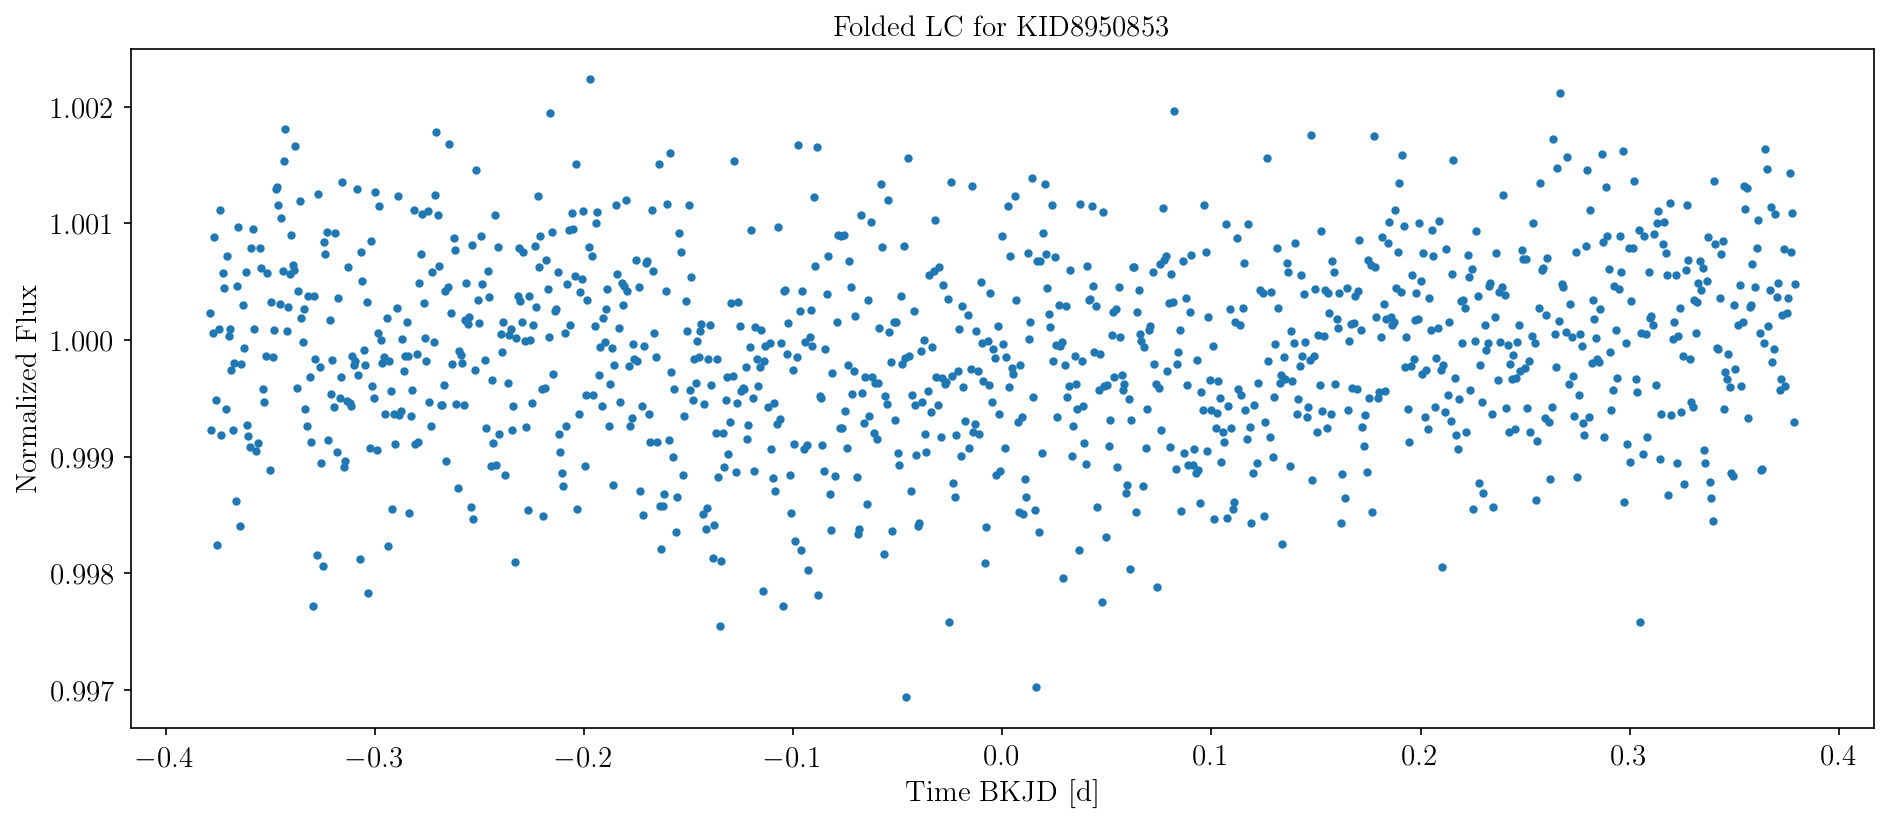

Transit duration: 0.37954 [d]
Period: 37.8145252 [d]
Estimated transits at (1): [890.954744]
Observed transits at (1): [890.954744]
Index of missed transits: []

******************************** KID5121511 ********************************



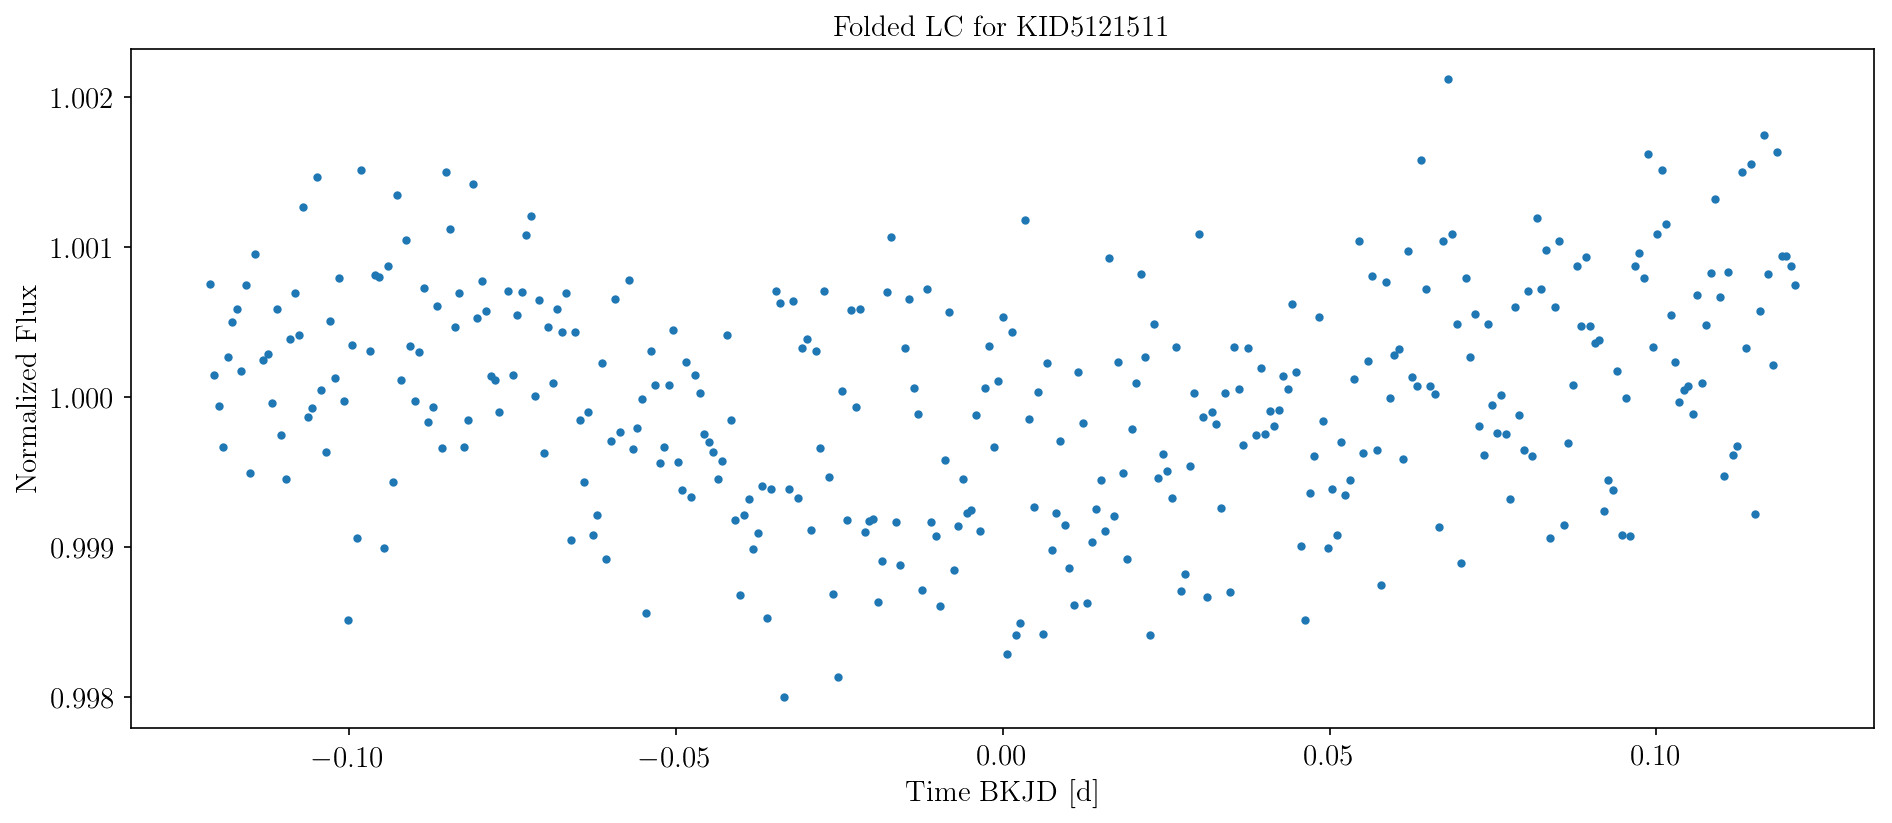

Transit duration: 0.12159 [d]
Period: 30.99664113 [d]
Estimated transits at (1): [749.72456034]
Observed transits at (1): [749.72456034]
Index of missed transits: []

******************************** KID9578686 ********************************



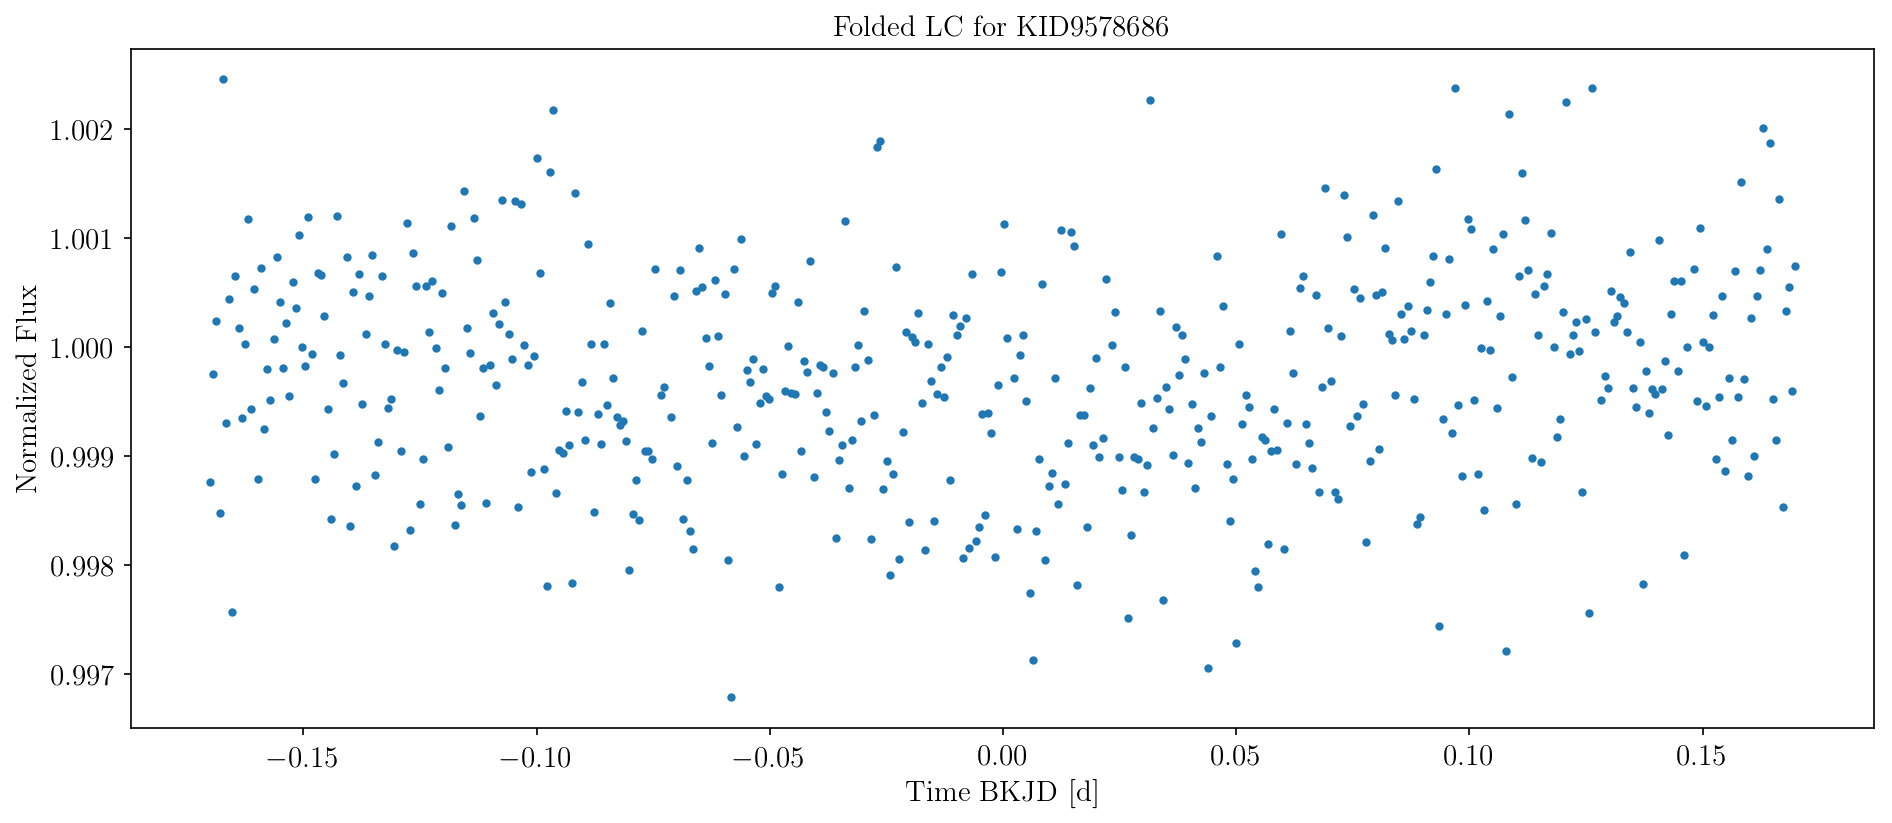

Transit duration: 0.17008 [d]
Period: 21.3851584 [d]
Estimated transits at (1): [798.9524436]
Observed transits at (1): [798.9524436]
Index of missed transits: []

******************************** KID3859079 ********************************



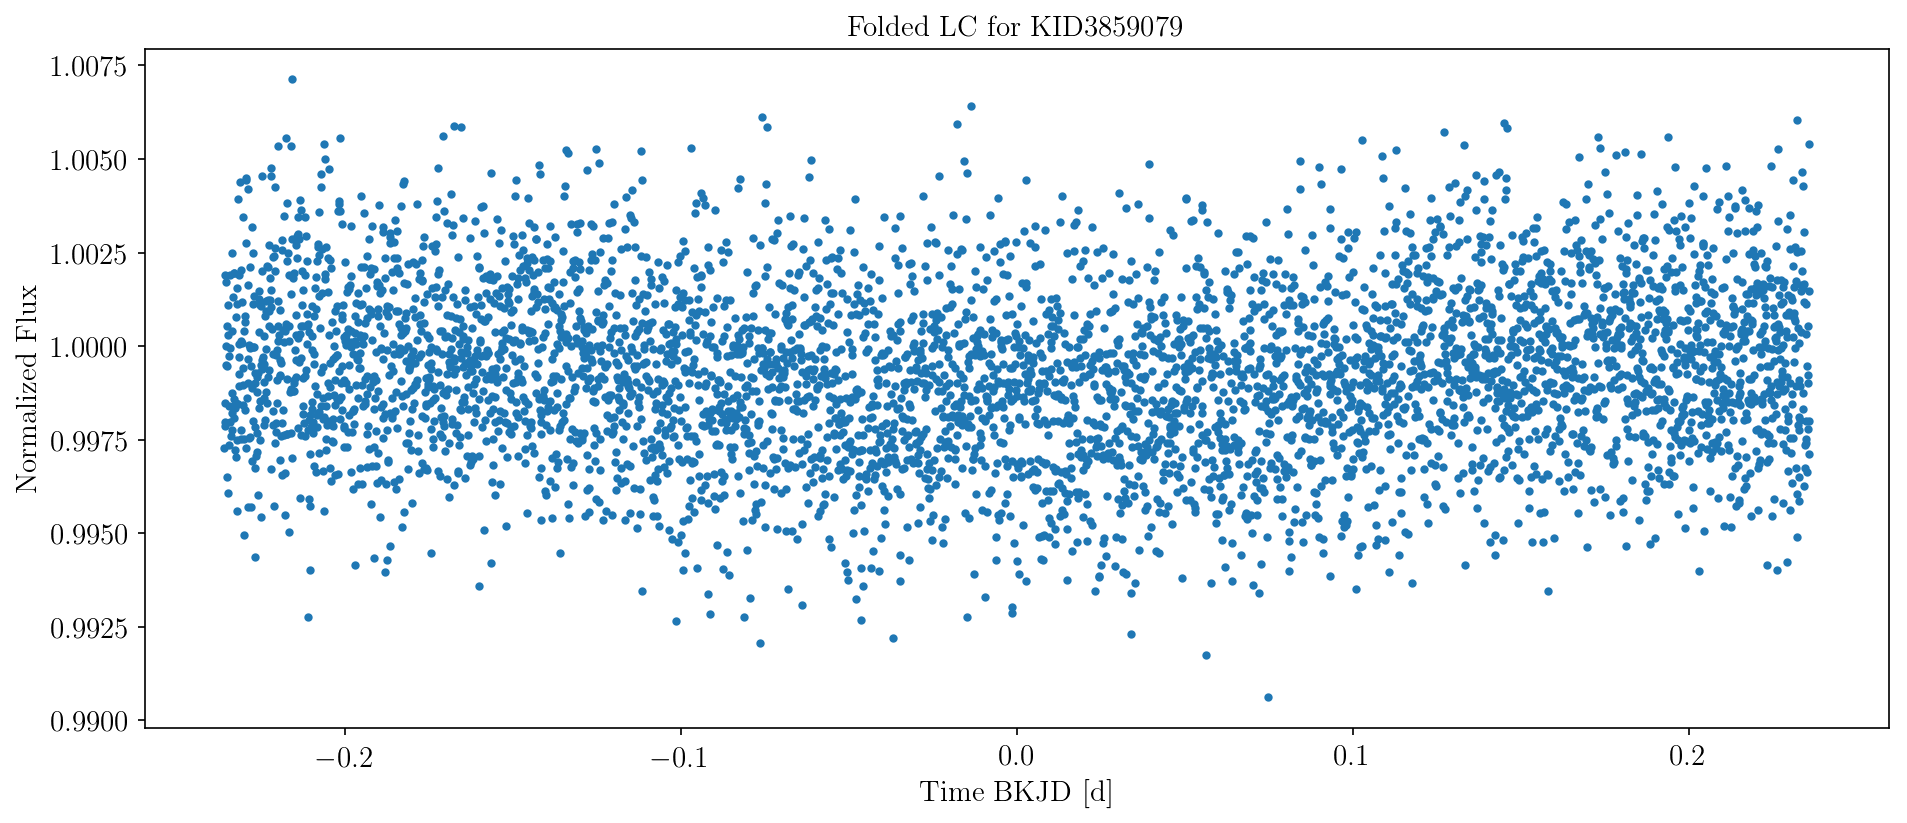

Transit duration: 0.23617 [d]
Period: 53.5292702 [d]
Estimated transits at (11): [1004.3329632 1057.8622334 1111.3915036 1164.9207738 1218.450044
 1271.9793142 1325.5085844 1379.0378546 1432.5671248 1486.096395
 1539.6256652]
Observed transits at (8): [1057.8622334 1111.3915036 1164.9207738 1218.450044  1271.9793142
 1379.0378546 1432.5671248 1539.6256652]
Index of missed transits: [9, 6, 0]

******************************** KID8805348 ********************************



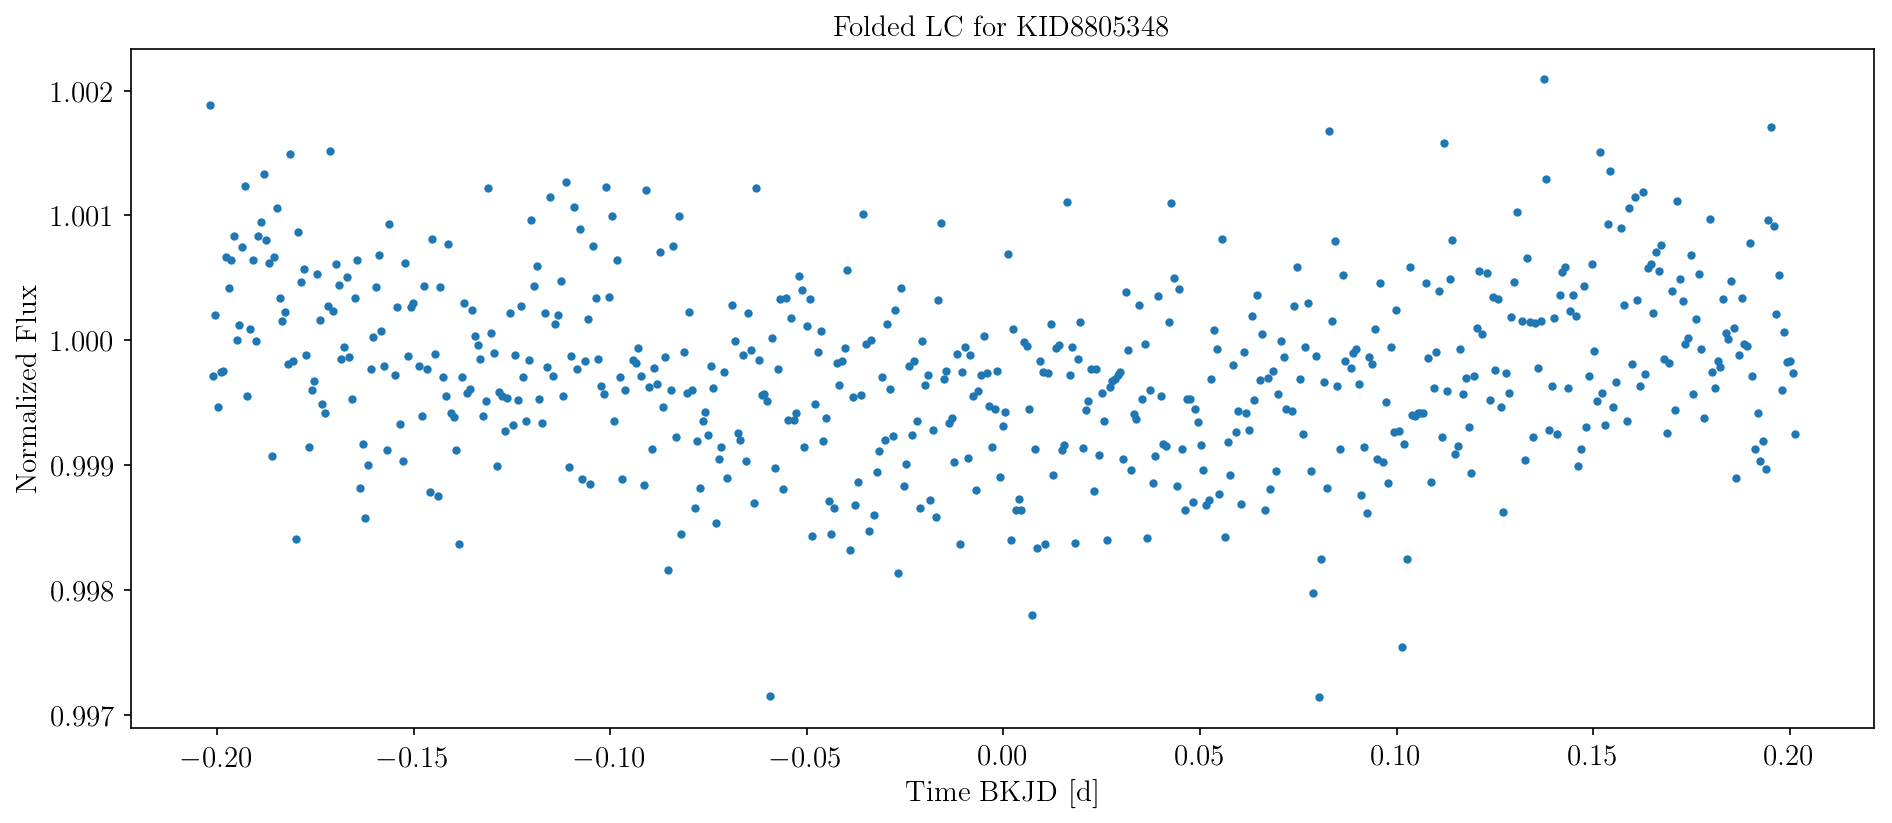

Transit duration: 0.20198 [d]
Period: 29.90721859 [d]
Estimated transits at (1): [773.4377418]
Observed transits at (1): [773.4377418]
Index of missed transits: []

******************************** KID5383248 ********************************



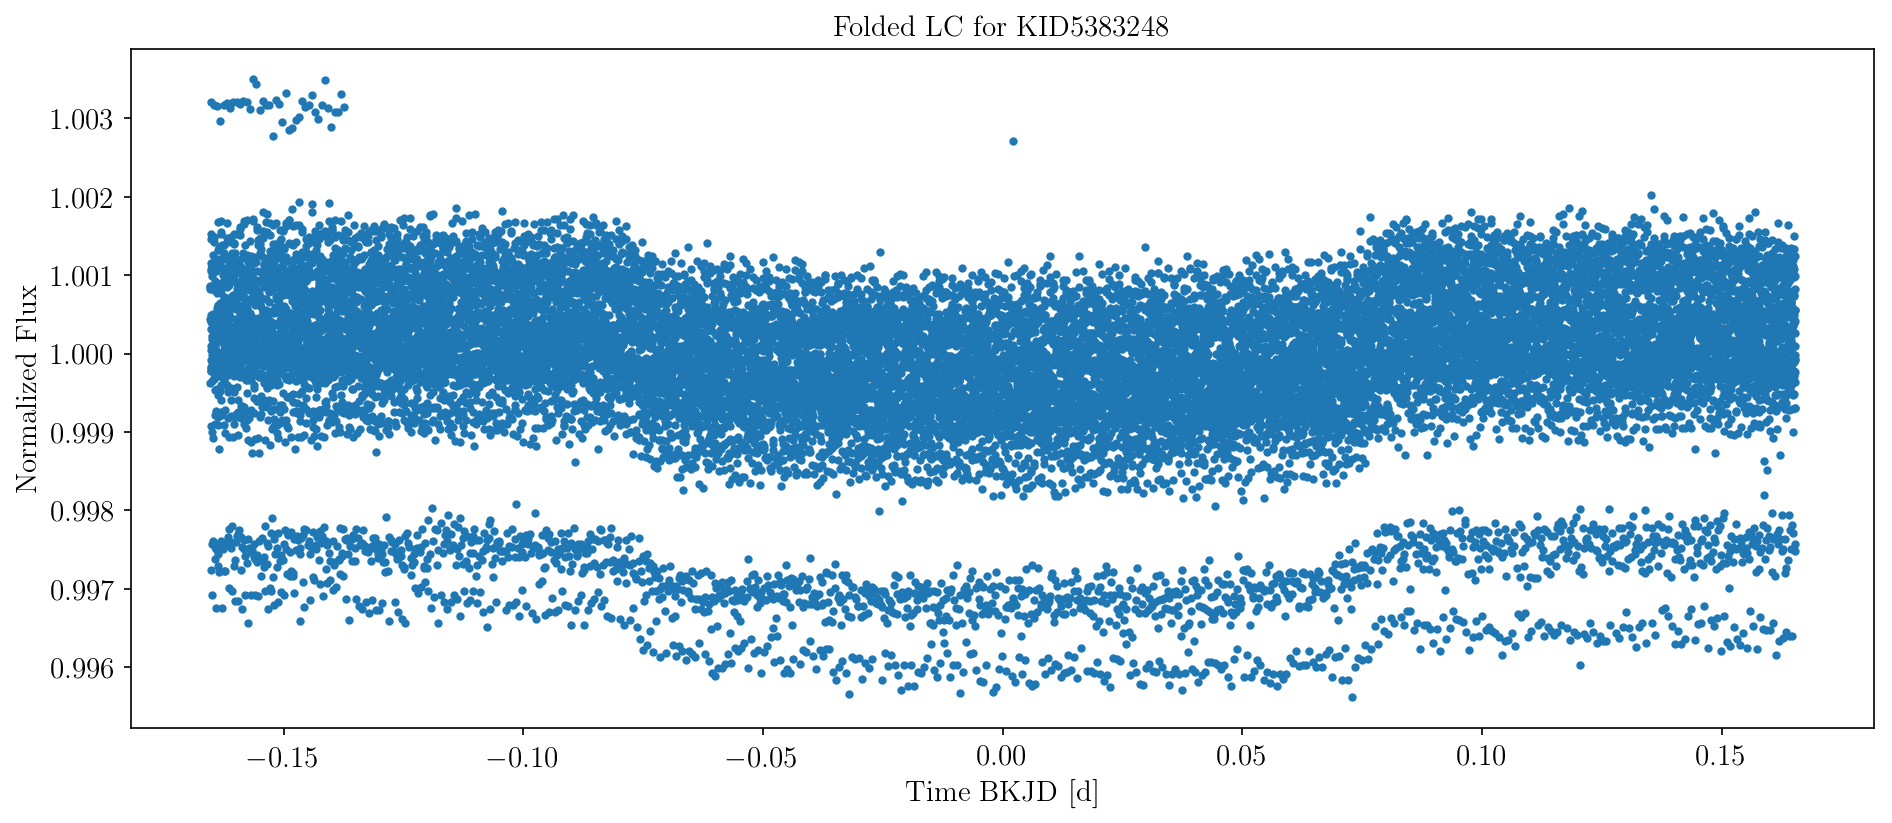

Transit duration: 0.16541 [d]
Period: 16.23847733 [d]
Estimated transits at (86): [ 203.49651866  219.73499599  235.97347332  252.21195065  268.45042798
  284.68890531  300.92738264  317.16585997  333.4043373   349.64281463
  365.88129196  382.11976929  398.35824662  414.59672395  430.83520128
  447.07367861  463.31215594  479.55063327  495.7891106   512.02758793
  528.26606526  544.50454259  560.74301992  576.98149725  593.21997458
  609.45845191  625.69692924  641.93540657  658.1738839   674.41236123
  690.65083856  706.88931589  723.12779322  739.36627055  755.60474788
  771.84322521  788.08170254  804.32017987  820.5586572   836.79713453
  853.03561186  869.27408919  885.51256652  901.75104385  917.98952118
  934.22799851  950.46647584  966.70495317  982.9434305   999.18190783
 1015.42038516 1031.65886249 1047.89733982 1064.13581715 1080.37429448
 1096.61277181 1112.85124914 1129.08972647 1145.3282038  1161.56668113
 1177.80515846 1194.04363579 1210.28211312 1226.52059045 1242.7590

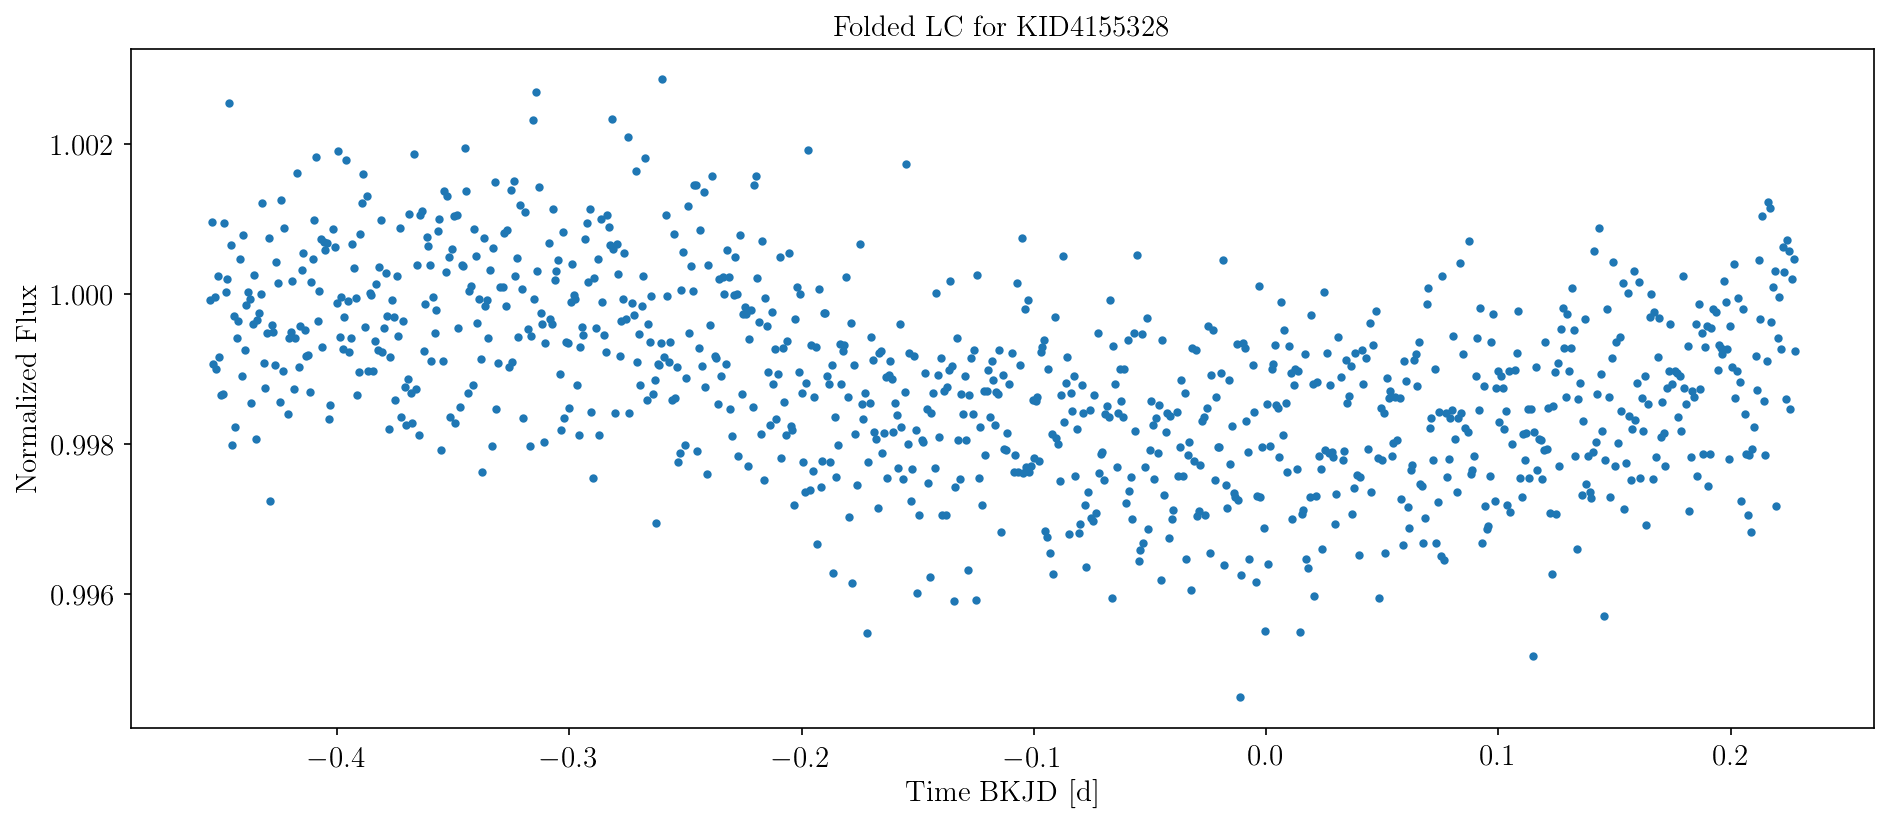

Transit duration: 0.45475 [d]
Period: 127.8334997 [d]
Estimated transits at (1): [932.5859485]
Observed transits at (1): [932.5859485]
Index of missed transits: []

******************************** KID4841374 ********************************



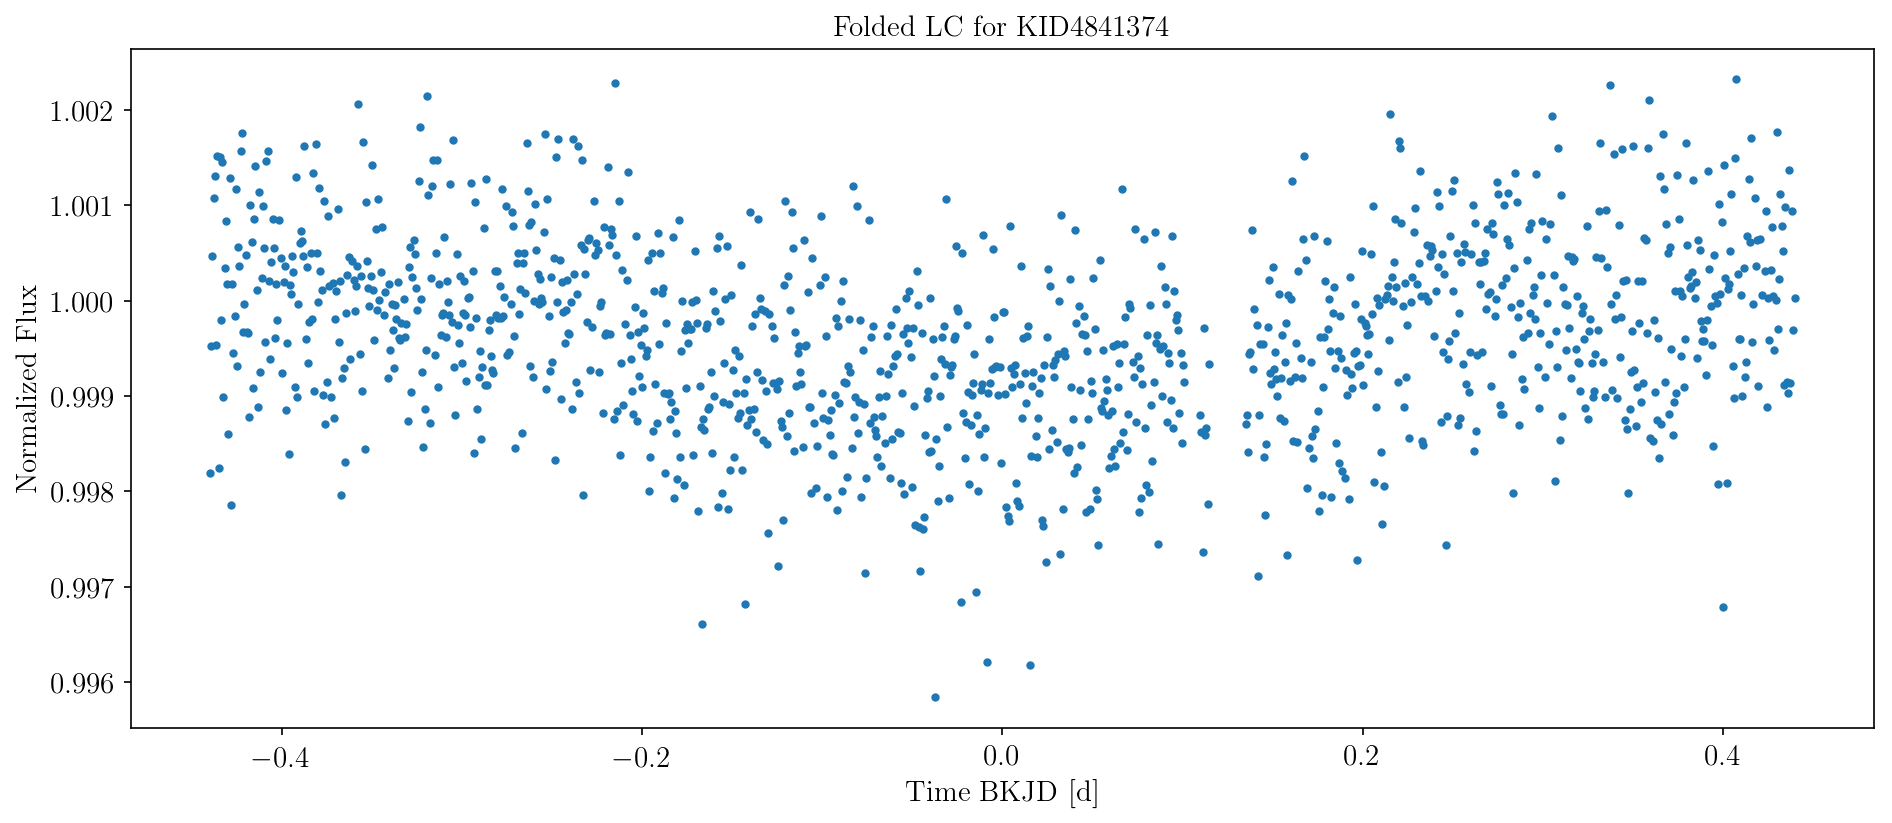

Transit duration: 0.4405 [d]
Period: 161.4746786 [d]
Estimated transits at (1): [816.5020944]
Observed transits at (1): [816.5020944]
Index of missed transits: []

******************************** KID12365184 ********************************



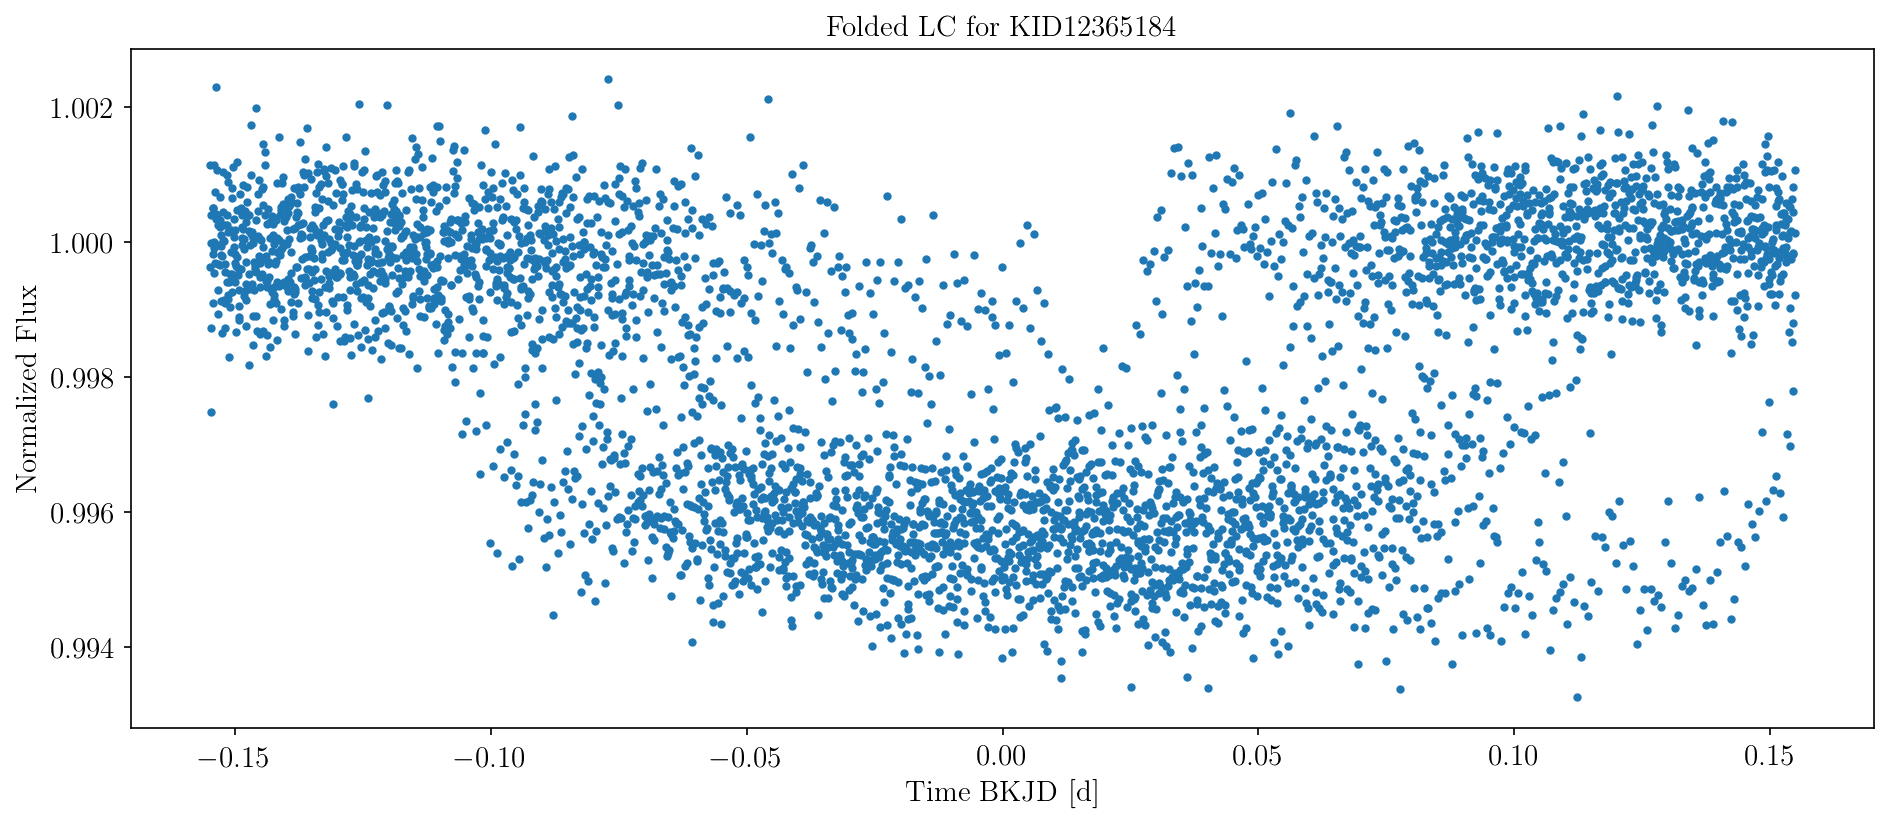

Transit duration: 0.1549 [d]
Period: 69.72646639 [d]
Estimated transits at (15): [ 544.72557495  614.45204134  684.17850773  753.90497412  823.63144051
  893.3579069   963.08437329 1032.81083968 1102.53730607 1172.26377246
 1241.99023885 1311.71670524 1381.44317163 1451.16963802 1520.89610441]
Observed transits at (10): [ 823.63144051  893.3579069   963.08437329 1102.53730607 1172.26377246
 1241.99023885 1311.71670524 1381.44317163 1451.16963802 1520.89610441]
Index of missed transits: [7, 3, 2, 1, 0]

******************************** KID2853093 ********************************



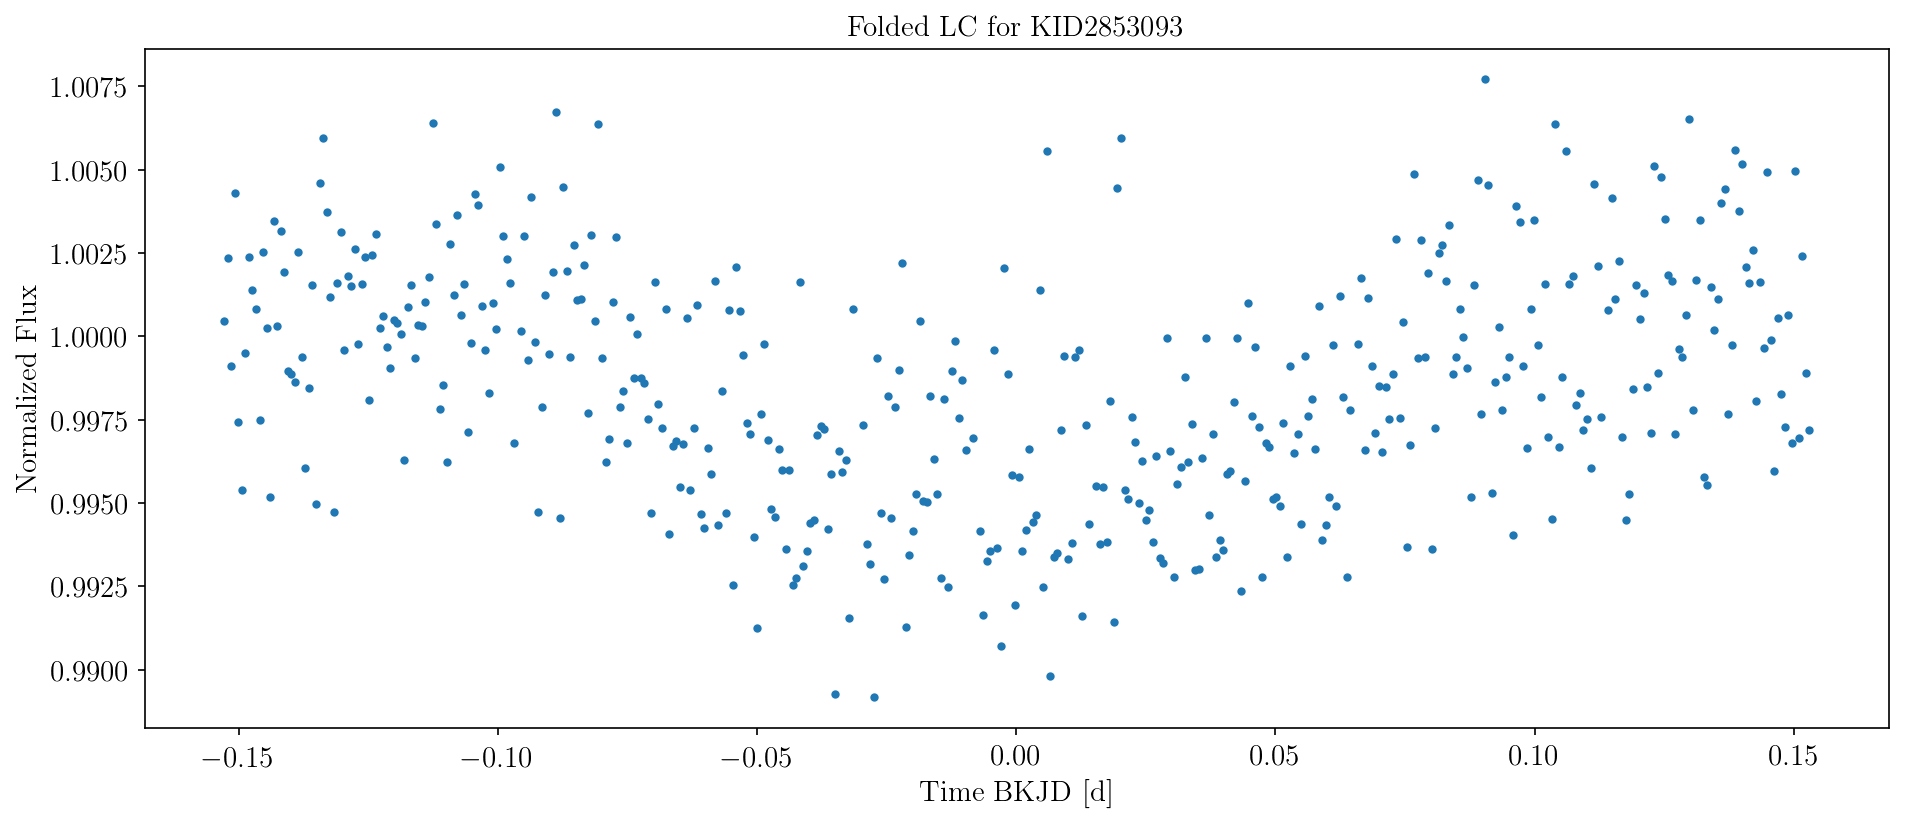

Transit duration: 0.15306 [d]
Period: 161.5278347 [d]
Estimated transits at (1): [1005.6405435]
Observed transits at (1): [1005.6405435]
Index of missed transits: []

******************************** KID11802615 ********************************



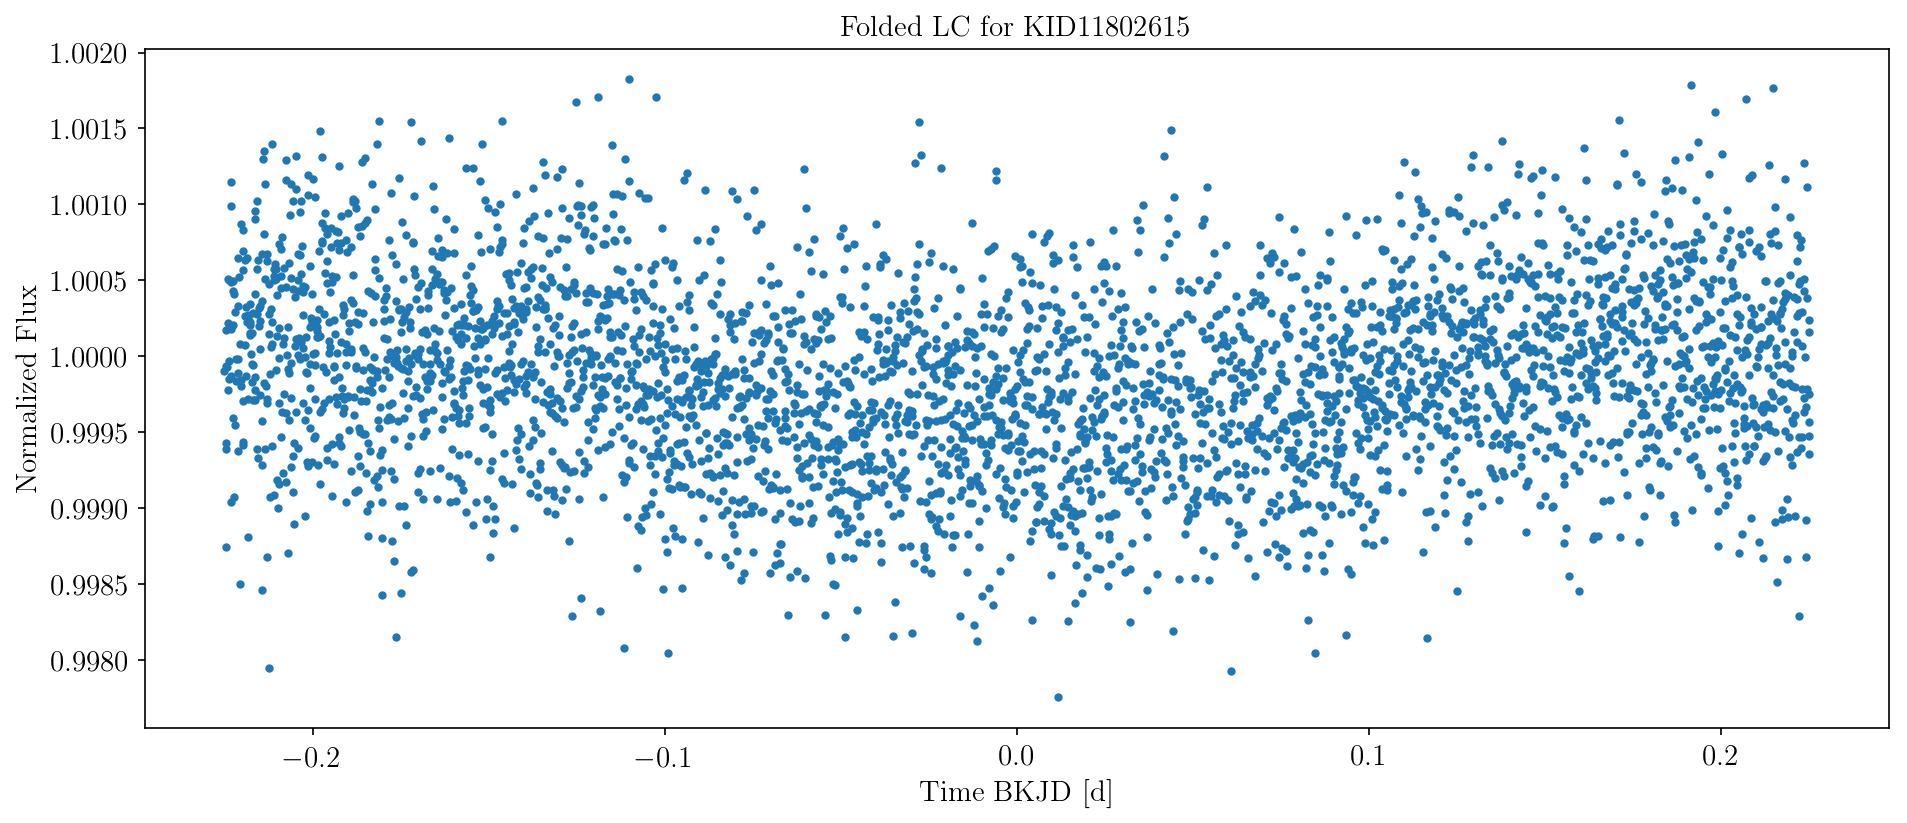

Transit duration: 0.22514 [d]
Period: 28.86236571 [d]
Estimated transits at (6): [553.69573423 582.55809994 611.42046565 640.28283136 669.14519707
 698.00756278]
Observed transits at (6): [553.69573423 582.55809994 611.42046565 640.28283136 669.14519707
 698.00756278]
Index of missed transits: []

******************************** KID6442377 ********************************



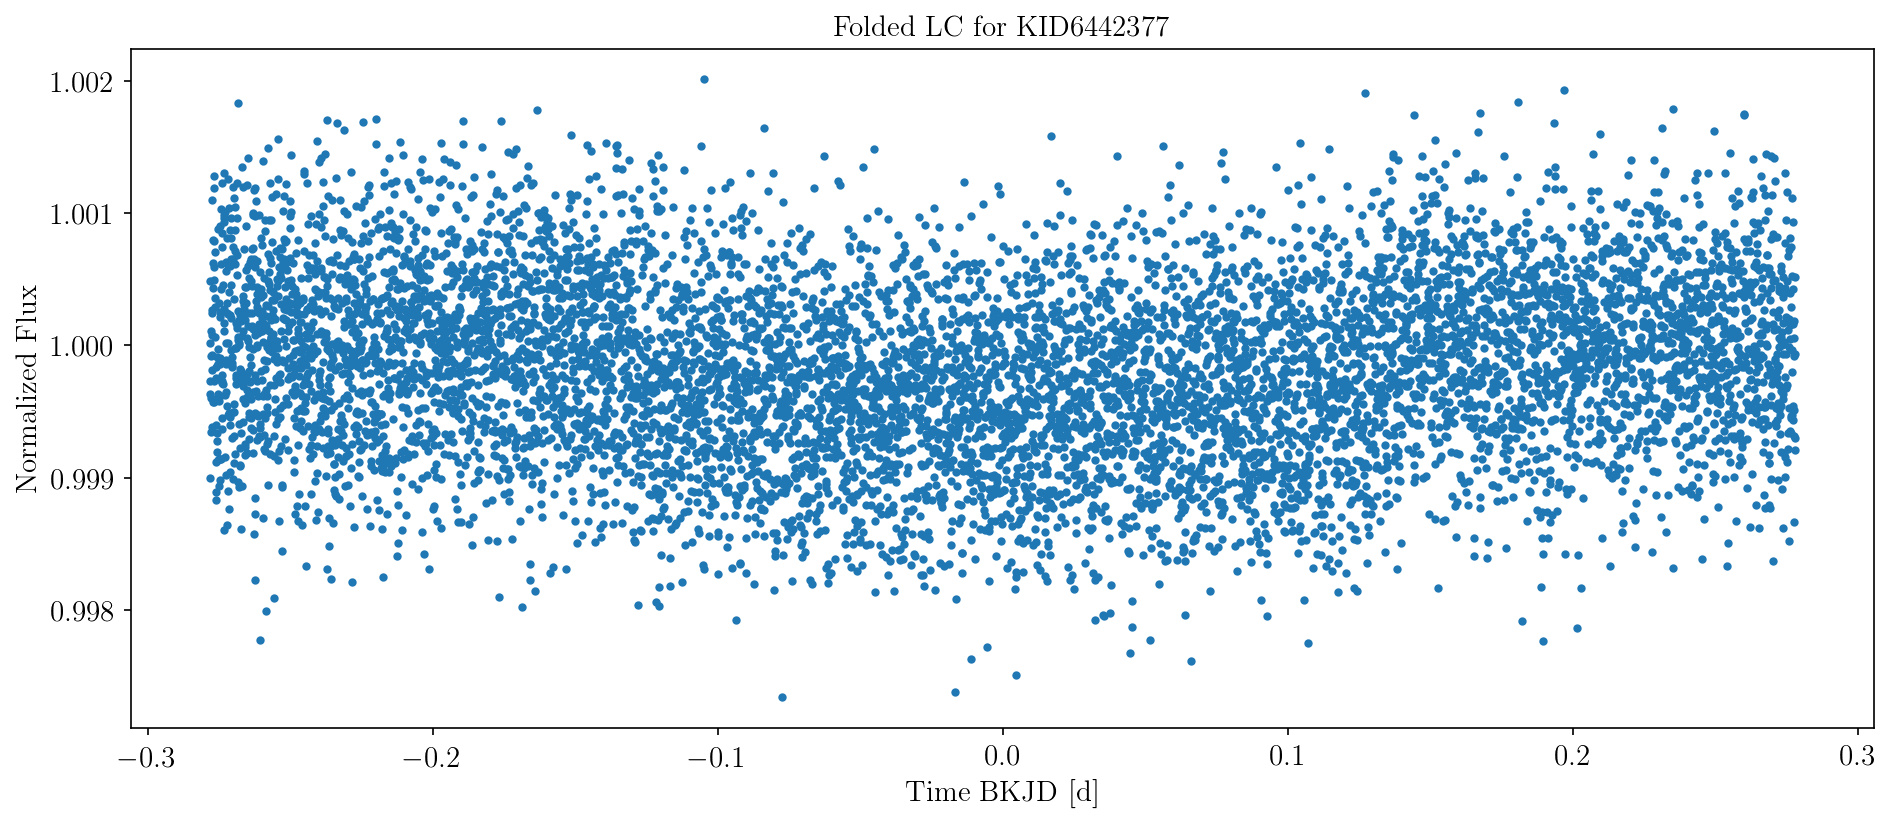

Transit duration: 0.27813 [d]
Period: 30.22910274 [d]
Estimated transits at (13): [285.6663237  315.89542644 346.12452918 376.35363192 406.58273466
 436.8118374  467.04094014 497.27004288 527.49914562 557.72824836
 587.9573511  618.18645384 648.41555658]
Observed transits at (11): [285.6663237  315.89542644 346.12452918 376.35363192 406.58273466
 436.8118374  527.49914562 557.72824836 587.9573511  618.18645384
 648.41555658]
Index of missed transits: [7, 6]

******************************** KID11074541 ********************************



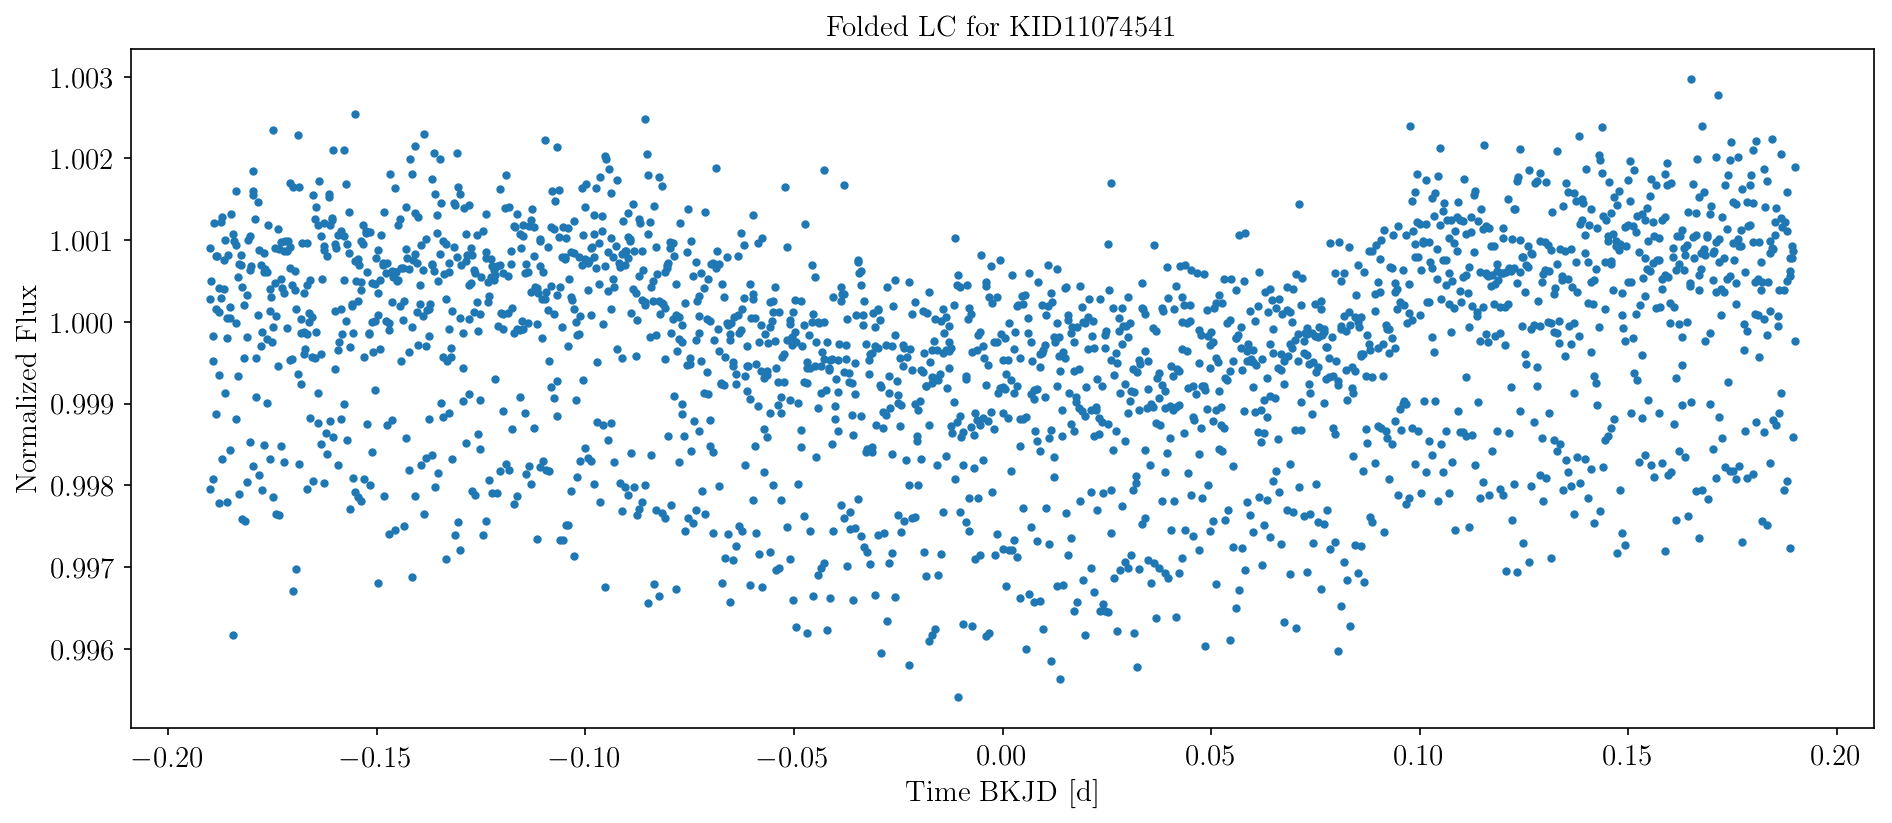

Transit duration: 0.19005 [d]
Period: 29.88487723 [d]
Estimated transits at (35): [ 561.69780799  591.58268522  621.46756245  651.35243968  681.23731691
  711.12219414  741.00707137  770.8919486   800.77682583  830.66170306
  860.54658029  890.43145752  920.31633475  950.20121198  980.08608921
 1009.97096644 1039.85584367 1069.7407209  1099.62559813 1129.51047536
 1159.39535259 1189.28022982 1219.16510705 1249.04998428 1278.93486151
 1308.81973874 1338.70461597 1368.5894932  1398.47437043 1428.35924766
 1458.24412489 1488.12900212 1518.01387935 1547.89875658 1577.78363381]
Observed transits at (4): [ 561.69780799  591.58268522  621.46756245 1577.78363381]
Index of missed transits: [33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3]

******************************** KID10528068 ********************************



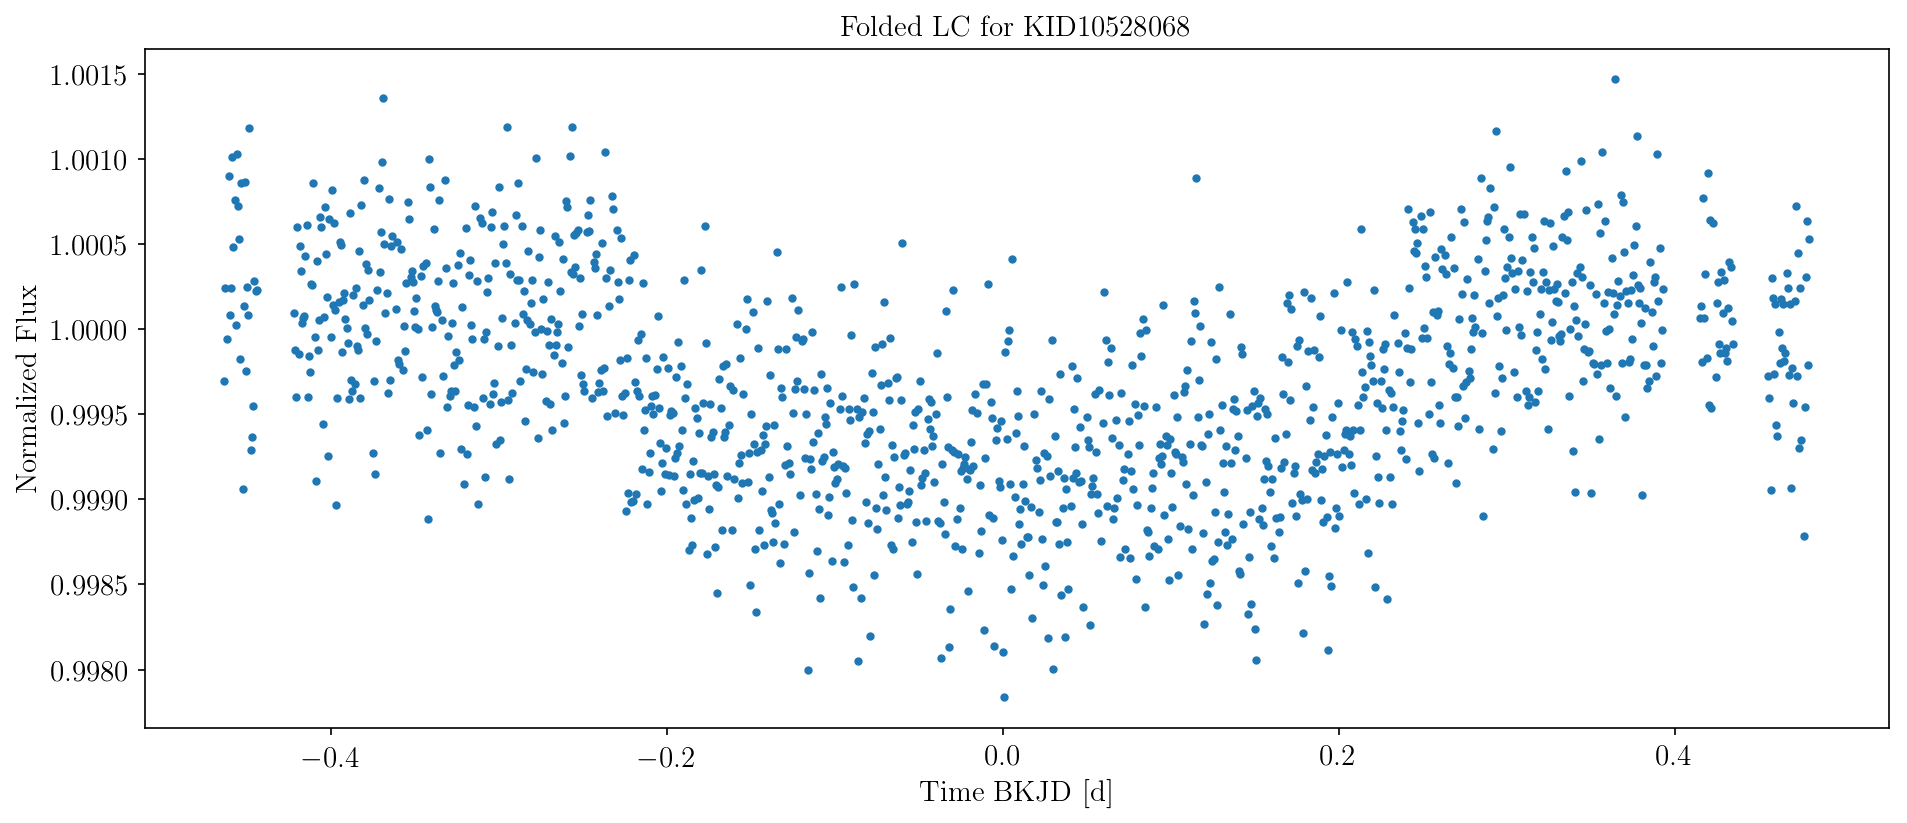

Transit duration: 0.48072 [d]
Period: 158.6850022 [d]
Estimated transits at (1): [967.374941]
Observed transits at (1): [967.374941]
Index of missed transits: []

******************************** KID7761545 ********************************

Transit duration: 0.28127 [d]
Period: 85.3514875 [d]
Estimated transits at (0): []
Observed transits at (0): []
Index of missed transits: []

******************************** KID6504954 ********************************



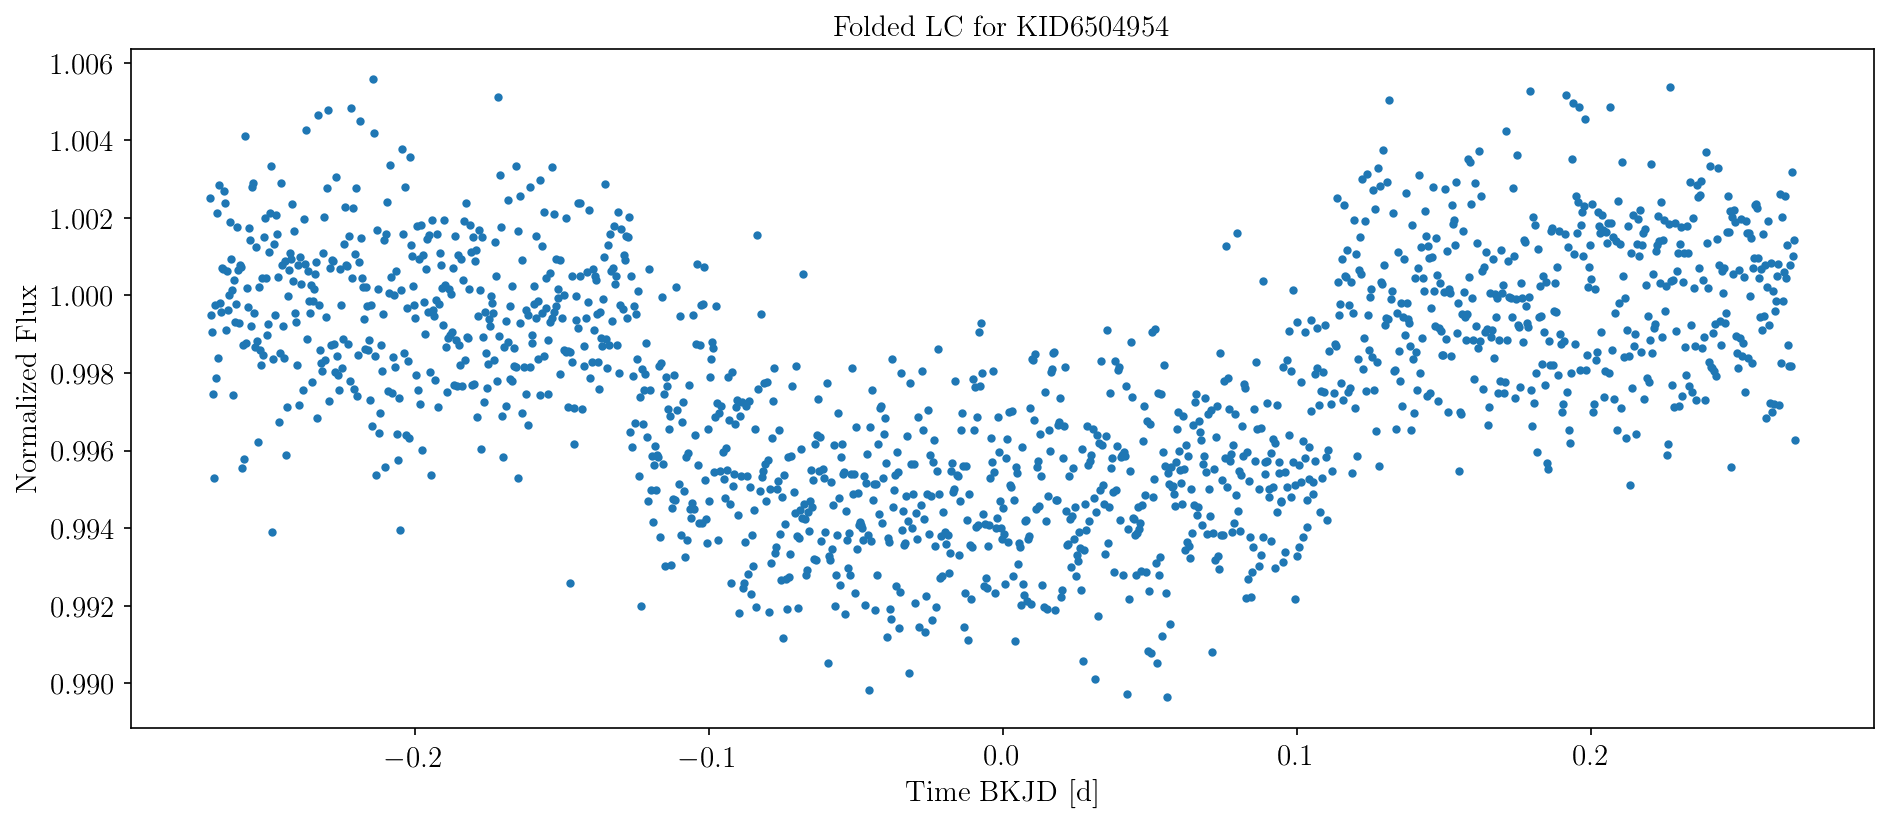

Transit duration: 0.26975 [d]
Period: 130.3543929 [d]
Estimated transits at (2): [1317.2497561 1447.604149 ]
Observed transits at (2): [1317.2497561 1447.604149 ]
Index of missed transits: []

******************************** KID11622600 ********************************

Transit duration: 0.20232 [d]
Period: 82.5341188 [d]
Estimated transits at (0): []
Observed transits at (0): []
Index of missed transits: []

******************************** KID5812701 ********************************



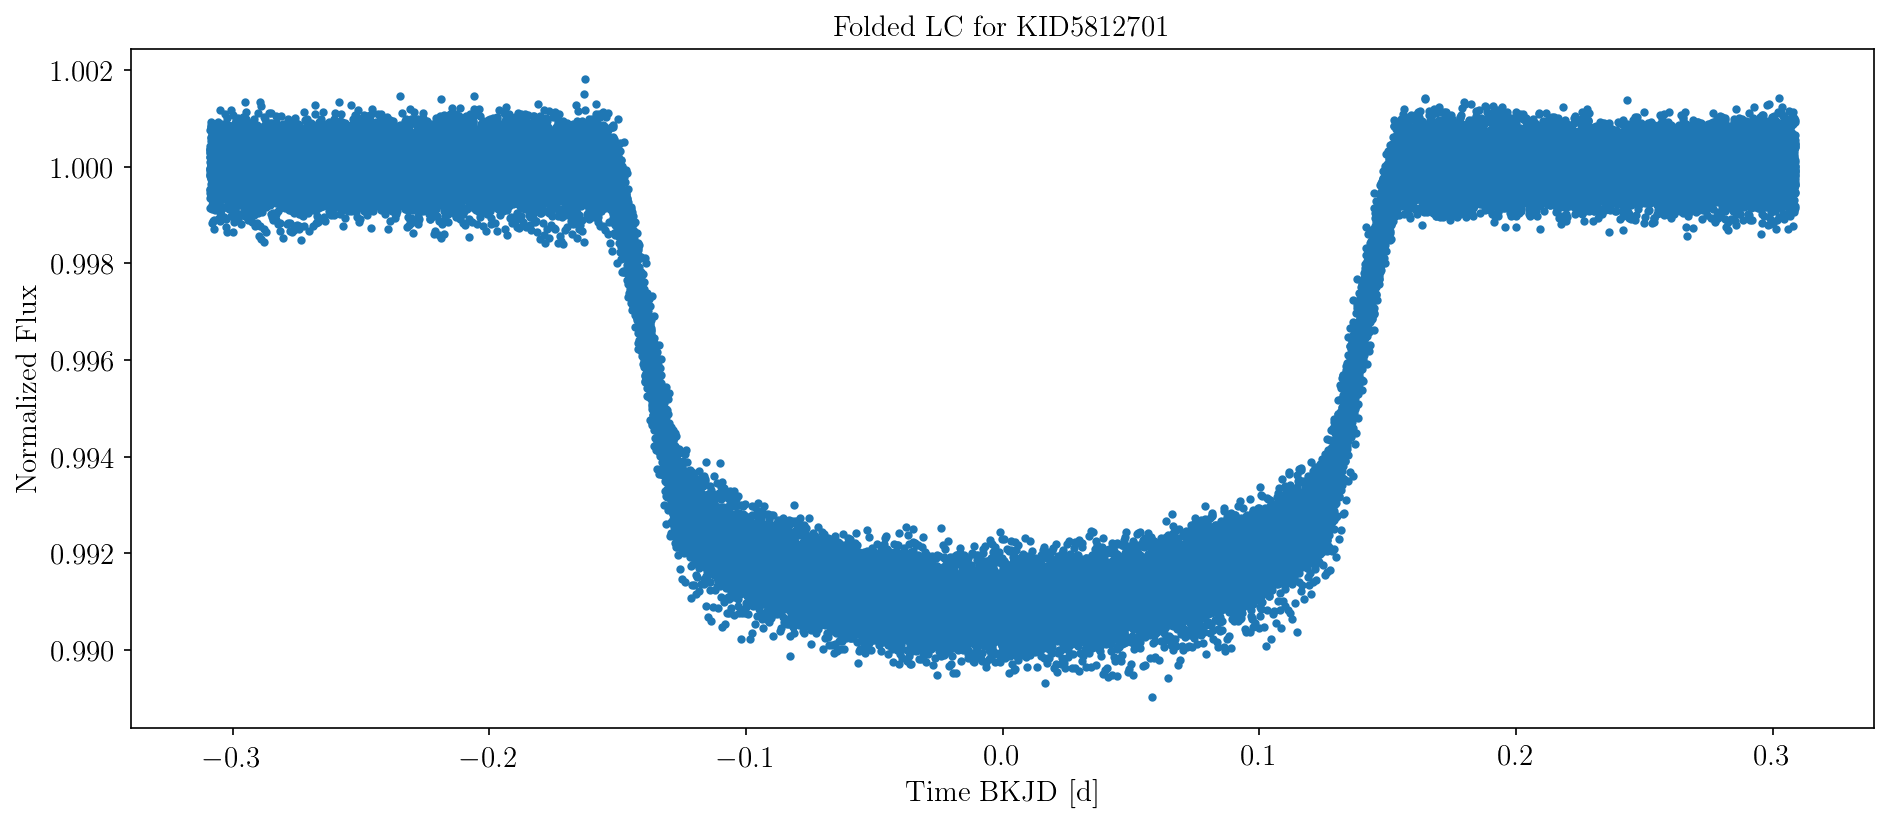

Transit duration: 0.30887 [d]
Period: 17.855221681 [d]
Estimated transits at (82): [ 128.74124432  146.596466    164.45168768  182.30690936  200.16213104
  218.01735272  235.8725744   253.72779609  271.58301777  289.43823945
  307.29346113  325.14868281  343.00390449  360.85912617  378.71434785
  396.56956953  414.42479122  432.2800129   450.13523458  467.99045626
  485.84567794  503.70089962  521.5561213   539.41134298  557.26656466
  575.12178634  592.97700803  610.83222971  628.68745139  646.54267307
  664.39789475  682.25311643  700.10833811  717.96355979  735.81878147
  753.67400315  771.52922483  789.38444652  807.2396682   825.09488988
  842.95011156  860.80533324  878.66055492  896.5157766   914.37099828
  932.22621996  950.08144164  967.93666333  985.79188501 1003.64710669
 1021.50232837 1039.35755005 1057.21277173 1075.06799341 1092.92321509
 1110.77843677 1128.63365845 1146.48888014 1164.34410182 1182.1993235
 1200.05454518 1217.90976686 1235.76498854 1253.62021022 1271.4754

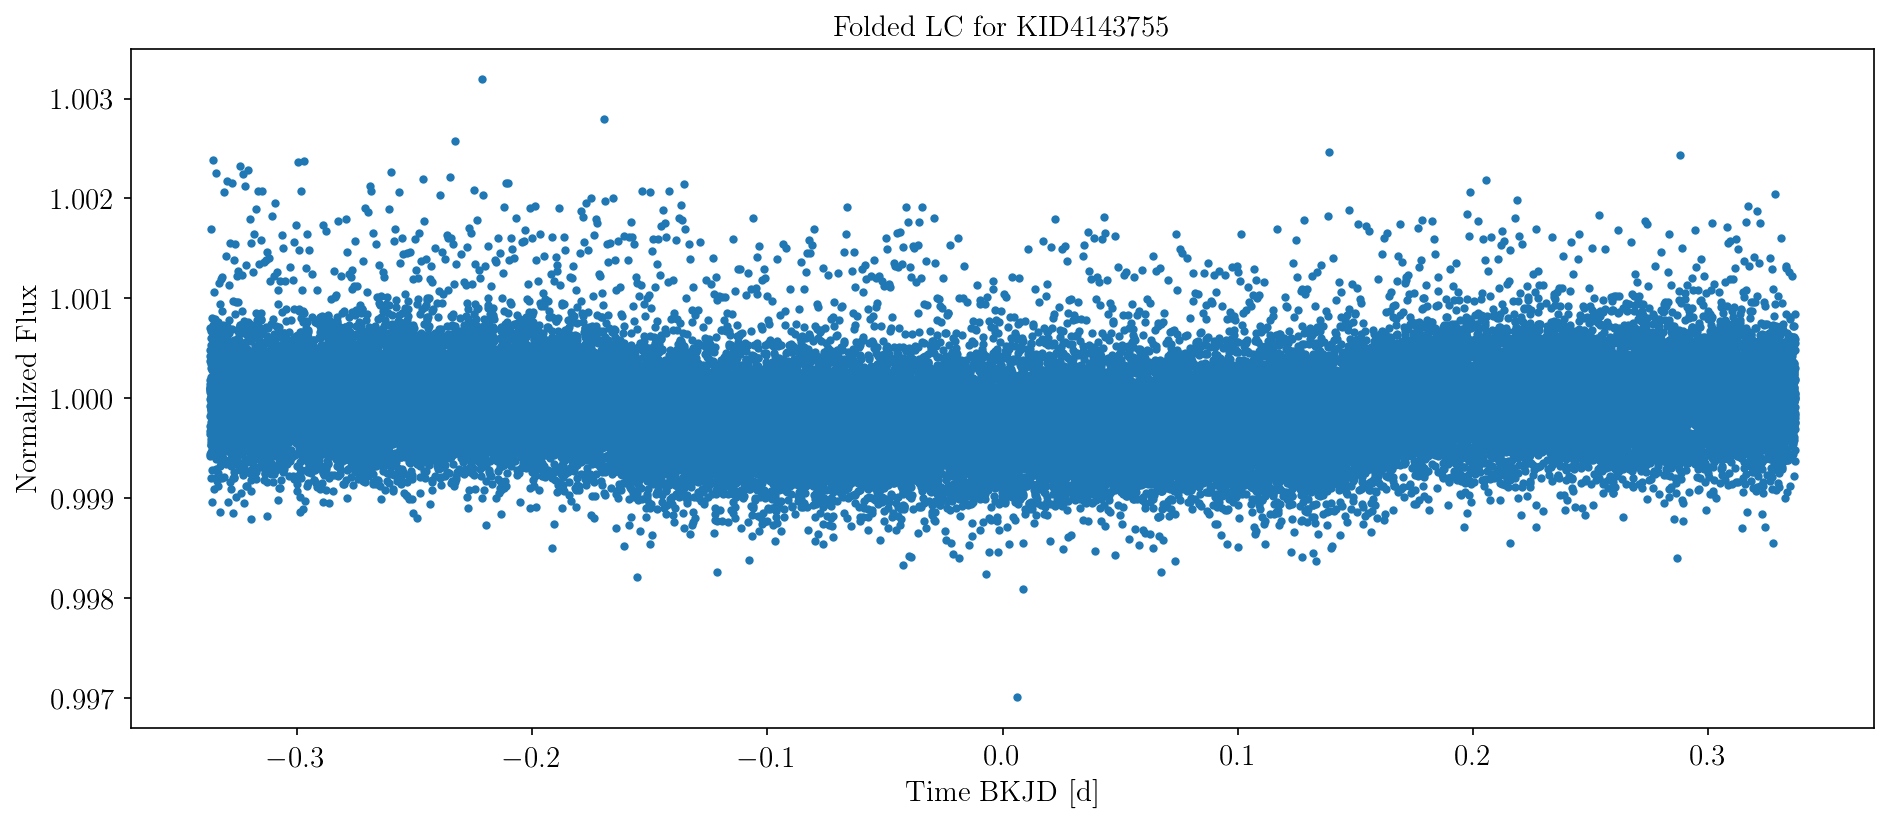

Transit duration: 0.33696 [d]
Period: 19.55662003 [d]
Estimated transits at (54): [ 541.06270054  560.61932057  580.1759406   599.73256063  619.28918066
  638.84580069  658.40242072  677.95904075  697.51566078  717.07228081
  736.62890084  756.18552087  775.7421409   795.29876093  814.85538096
  834.41200099  853.96862102  873.52524105  893.08186108  912.63848111
  932.19510114  951.75172117  971.3083412   990.86496123 1010.42158126
 1029.97820129 1049.53482132 1069.09144135 1088.64806138 1108.20468141
 1127.76130144 1147.31792147 1166.8745415  1186.43116153 1205.98778156
 1225.54440159 1245.10102162 1264.65764165 1284.21426168 1303.77088171
 1323.32750174 1342.88412177 1362.4407418  1381.99736183 1401.55398186
 1421.11060189 1440.66722192 1460.22384195 1479.78046198 1499.33708201
 1518.89370204 1538.45032207 1558.0069421  1577.56356213]
Observed transits at (52): [ 541.06270054  560.61932057  580.1759406   599.73256063  619.28918066
  638.84580069  658.40242072  677.95904075  697.5156

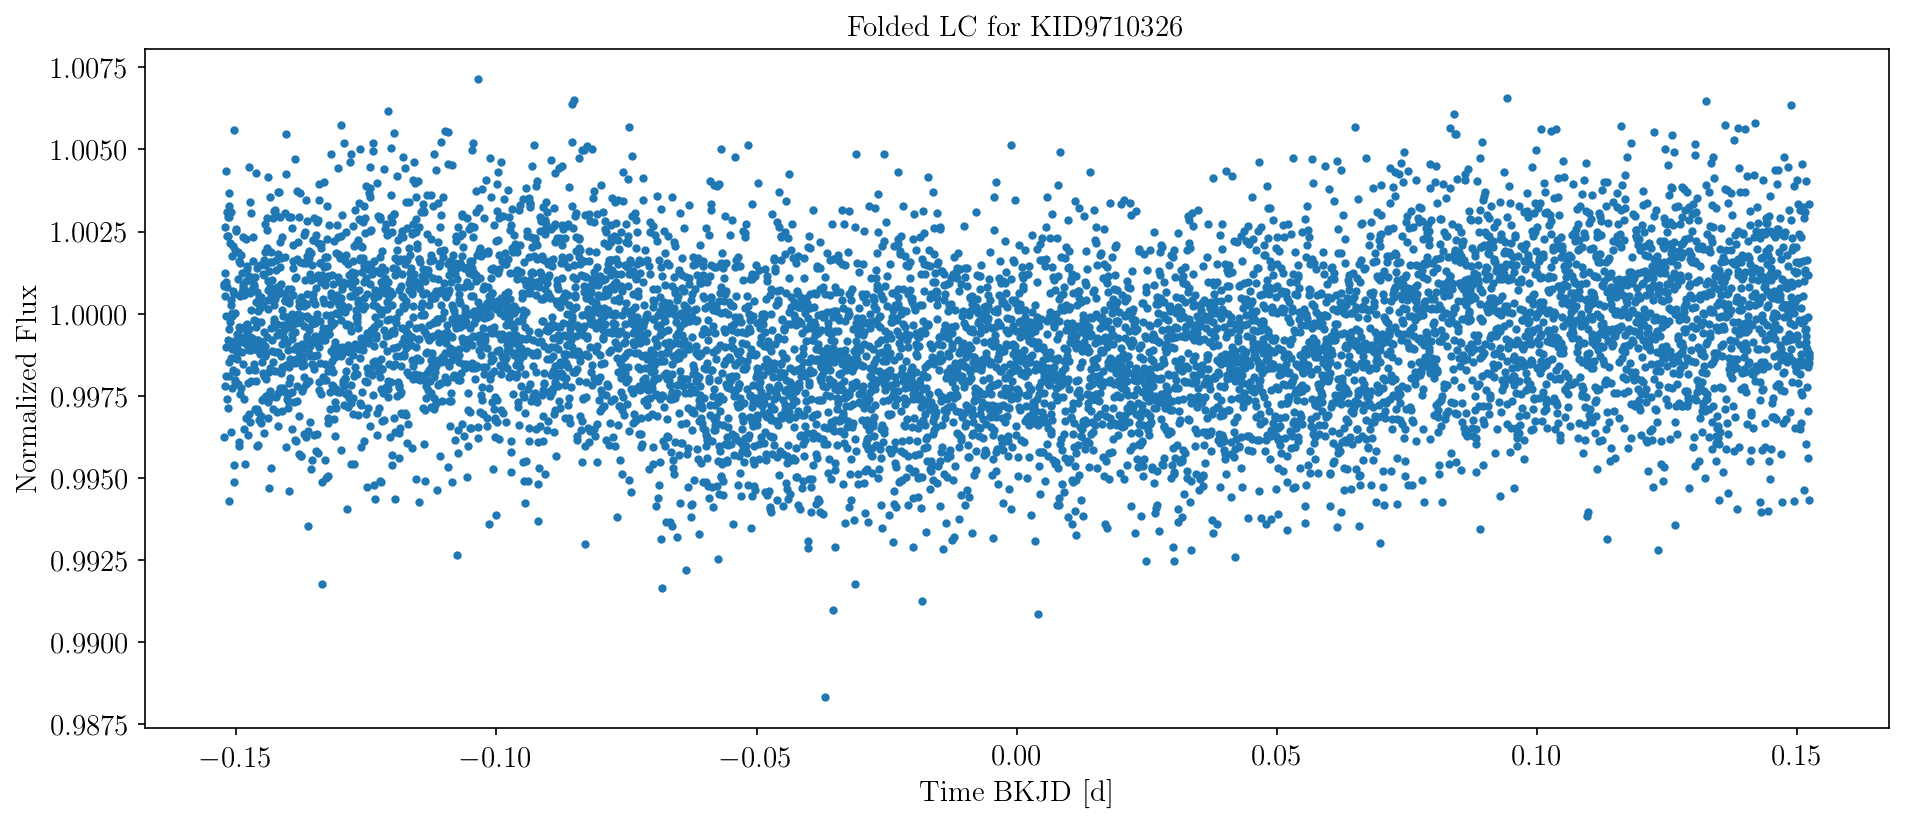

Transit duration: 0.15236 [d]
Period: 28.59914031 [d]
Estimated transits at (19): [1019.30173899 1047.9008793  1076.50001961 1105.09915992 1133.69830023
 1162.29744054 1190.89658085 1219.49572116 1248.09486147 1276.69400178
 1305.29314209 1333.8922824  1362.49142271 1391.09056302 1419.68970333
 1448.28884364 1476.88798395 1505.48712426 1534.08626457]
Observed transits at (17): [1019.30173899 1047.9008793  1076.50001961 1105.09915992 1133.69830023
 1190.89658085 1219.49572116 1248.09486147 1276.69400178 1333.8922824
 1362.49142271 1391.09056302 1419.68970333 1448.28884364 1476.88798395
 1505.48712426 1534.08626457]
Index of missed transits: [10, 5]

******************************** KID9965439 ********************************



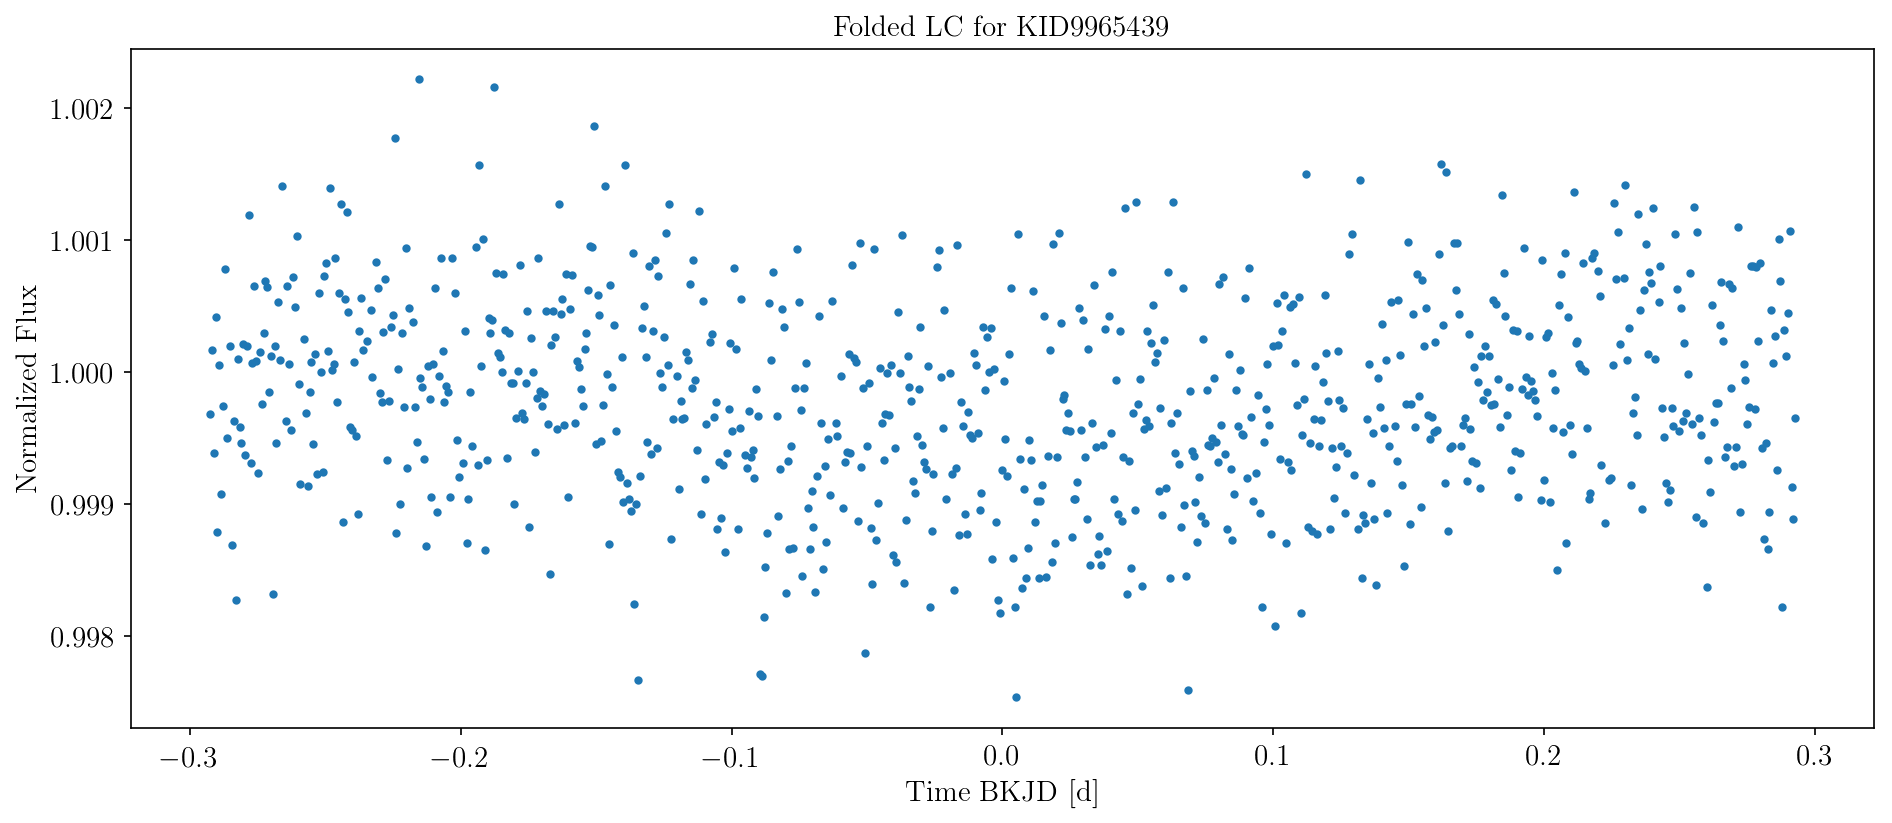

Transit duration: 0.29284 [d]
Period: 46.40626 [d]
Estimated transits at (1): [796.27771]
Observed transits at (1): [796.27771]
Index of missed transits: []

******************************** KID11449844 ********************************



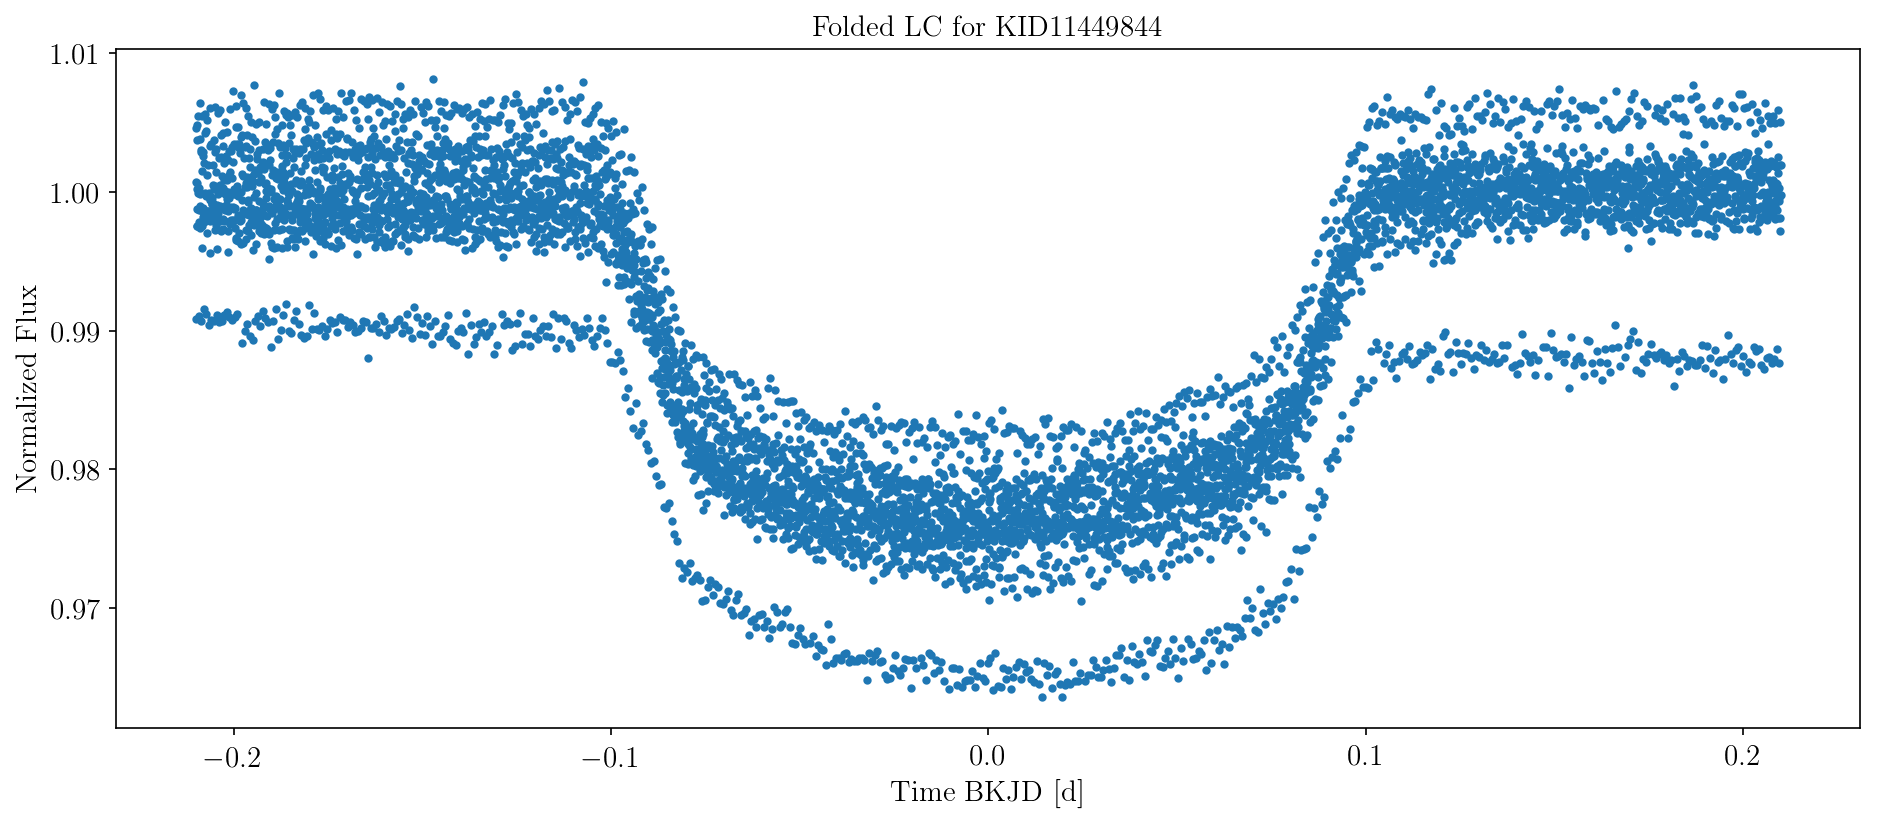

Transit duration: 0.21007 [d]
Period: 38.47876629 [d]
Estimated transits at (27): [ 267.28911087  305.76787716  344.24664345  382.72540974  421.20417603
  459.68294232  498.16170861  536.6404749   575.11924119  613.59800748
  652.07677377  690.55554006  729.03430635  767.51307264  805.99183893
  844.47060522  882.94937151  921.4281378   959.90690409  998.38567038
 1036.86443667 1075.34320296 1113.82196925 1152.30073554 1190.77950183
 1229.25826812 1267.73703441]
Observed transits at (11): [ 267.28911087  305.76787716  344.24664345  382.72540974  421.20417603
  536.6404749   575.11924119  613.59800748 1190.77950183 1229.25826812
 1267.73703441]
Index of missed transits: [23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 6, 5]

******************************** KID11194032 ********************************



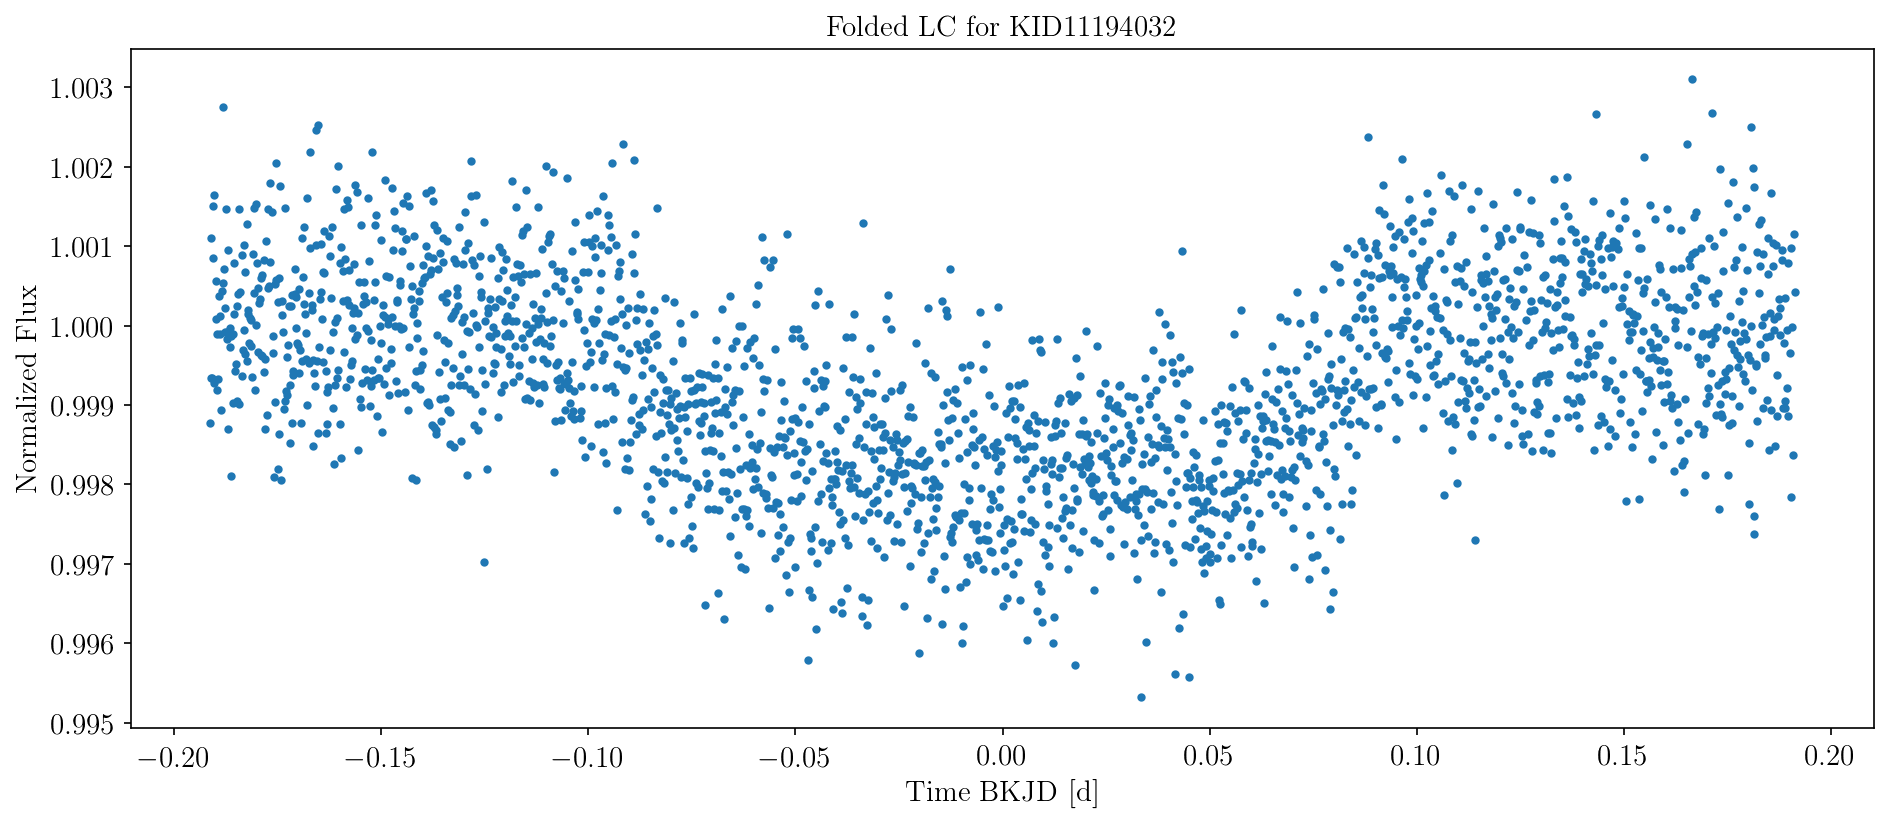

Transit duration: 0.19142 [d]
Period: 28.51117639 [d]
Estimated transits at (6): [558.00924807 586.52042446 615.03160085 643.54277724 672.05395363
 700.56513002]
Observed transits at (4): [558.00924807 586.52042446 615.03160085 700.56513002]
Index of missed transits: [4, 3]

******************************** KID5796675 ********************************



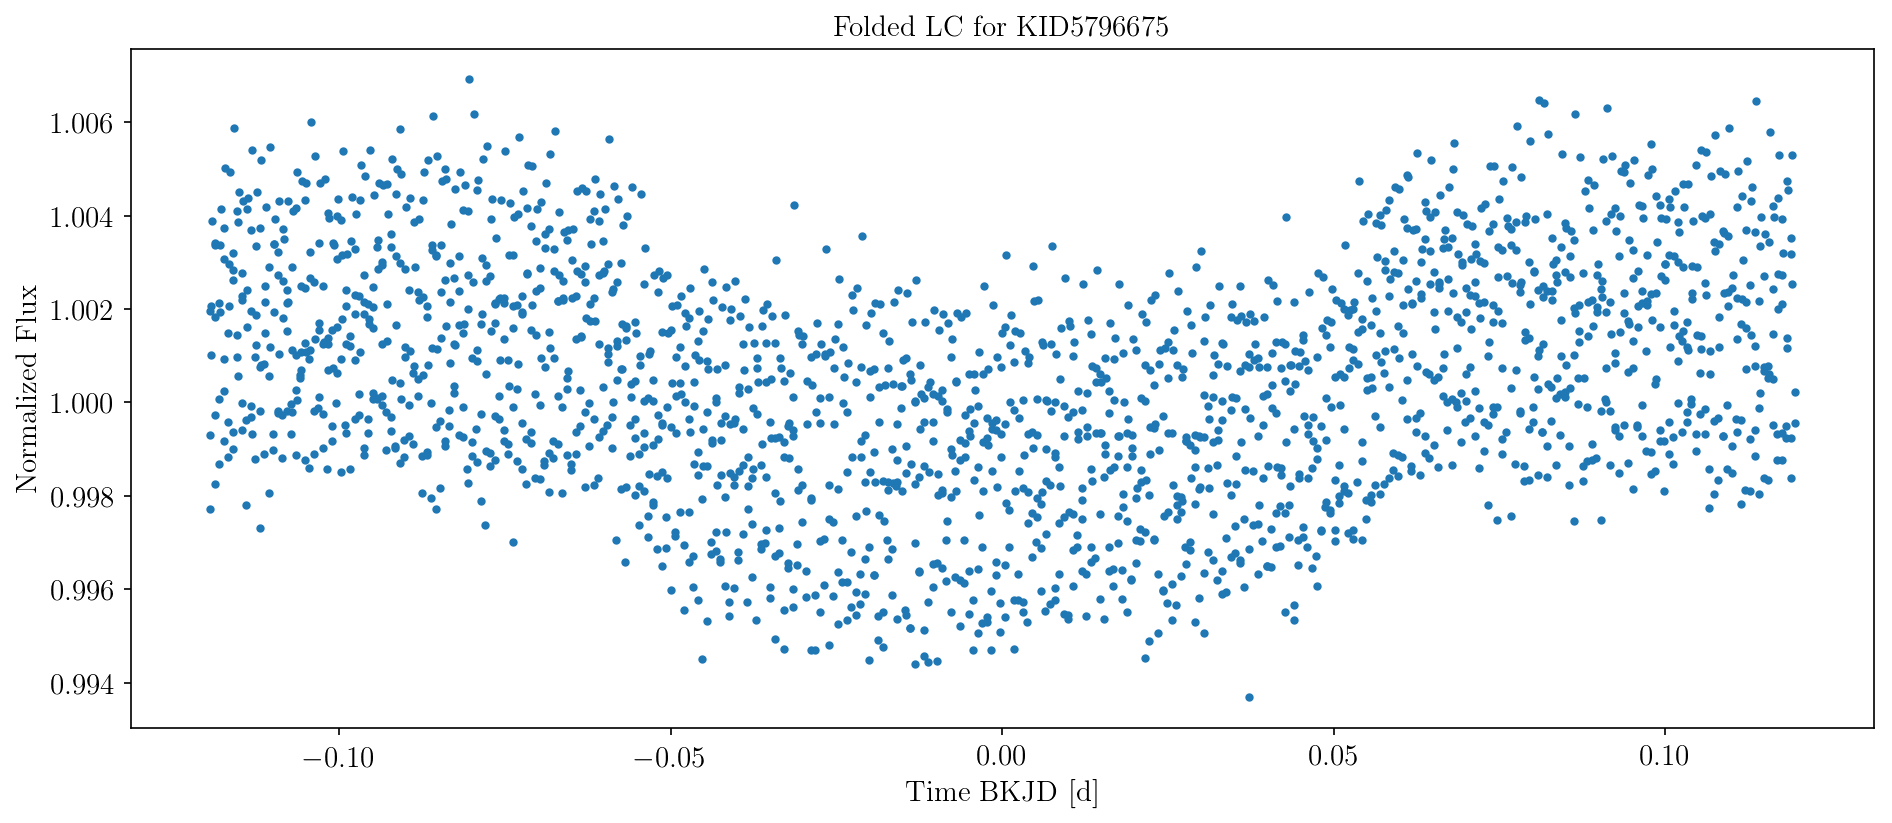

Transit duration: 0.11959 [d]
Period: 16.080657264000003 [d]
Estimated transits at (33): [ 745.58310424  761.6637615   777.74441877  793.82507603  809.9057333
  825.98639056  842.06704782  858.14770509  874.22836235  890.30901962
  906.38967688  922.47033414  938.55099141  954.63164867  970.71230594
  986.7929632  1002.87362046 1018.95427773 1035.03493499 1051.11559226
 1067.19624952 1083.27690678 1099.35756405 1115.43822131 1131.51887858
 1147.59953584 1163.6801931  1179.76085037 1195.84150763 1211.9221649
 1228.00282216 1244.08347942 1260.16413669]
Observed transits at (6): [ 745.58310424 1195.84150763 1211.9221649  1228.00282216 1244.08347942
 1260.16413669]
Index of missed transits: [27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

******************************** KID6960913 ********************************



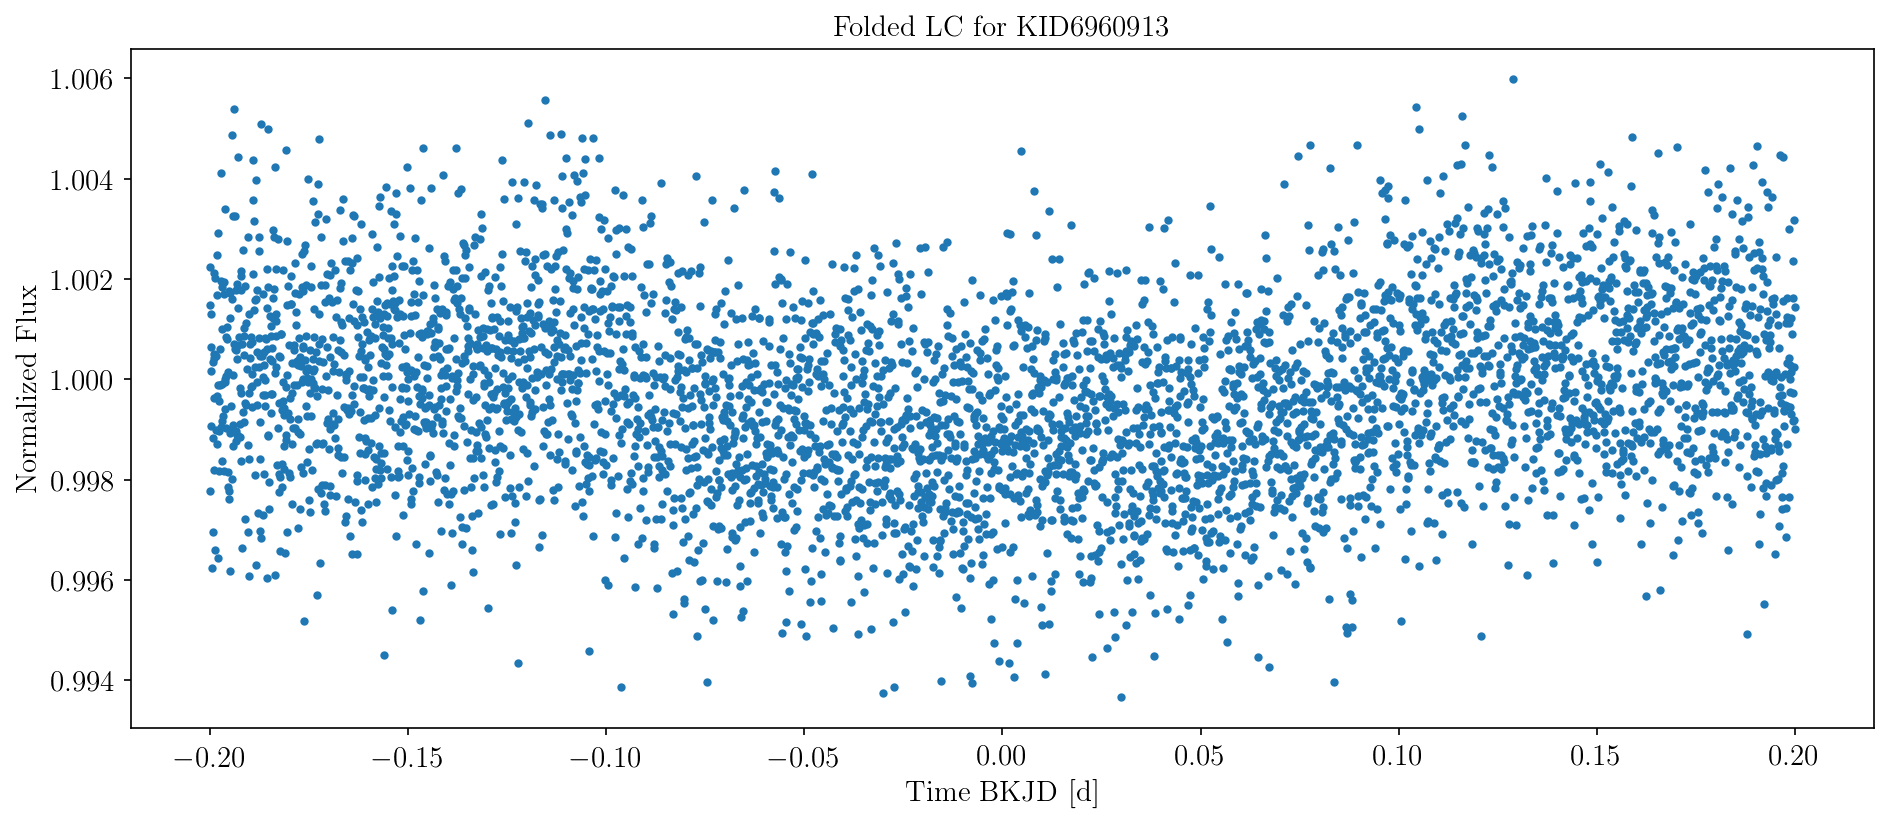

In [ ]:
for target in targets:
    print("\n******************************** KID"+str(target.kepid)+" ********************************\n")

    target.transit_times = find_transits(target)
    get_data_in_transit(target, amplify)
    oot_fit(target, poly_order)
    
    if (len(target.transit_times)==0): stars_wo_transits.append(target.kepid)

    target.ind_missed_transits = find_missed_transits(target)
    observed_transits = np.delete(target.transit_times, target.ind_missed_transits)
    mark_transits(target, observed_transits, False)
    show_transits(target, target.ind_missed_transits, False)

    if len(observed_transits!=0): 
        show_folded_lightcurve(target, True)
        
    #export_folded_lc(target)
    print("Transit duration: {0:0.5} [d]".format(target.duration))
    print("Period: {0:s} [d]".format(str(target.P)))
    print("Estimated transits at ({0:s}):".format(str(len(target.transit_times))), target.transit_times)
    print("Observed transits at ({0:s}):".format(str(len(observed_transits))), observed_transits)
    print("Index of missed transits:", target.ind_missed_transits)

In [ ]:
print("There are {:s} stars without transits. These targets won't be studied".format(str(len(stars_wo_transits))))

print(stars_wo_transits)

# Fit Stellar Density

In [ ]:
print("Amplification of transit duration by:", amplify)
sc = 58.0  #sc = 58 sec
tKep = sc/60/60/24  # sc in days
three_jup_rad = 0.2055 #2 RJup = 0.2055 Solar Radii    
G = 6.6730e-11

In [ ]:
def lnprior_rho(theta, maxb):
    pdepth, pb, sigma, pradius, f0, ptc = theta 
    if ((0 <= pb < maxb) and (0 <= sigma) and (pradius > 0) and (pdepth > 0) and (ptc**2<0.01)):
        return 0.0
    return -np.inf  


def lnlike_rho(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc,  mass, masserr, tKep, u1, u2, maxb, P = allfixed
    pdepth, pb, sigma, pradius, f0, ptc = theta 
    
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = mass, radius = pradius))
    body = transit.Body(radius=np.sqrt(pdepth)*pradius, period=P, t0=ptc, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    try: 
        ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    except ValueError:
        return -np.inf
    ftheo = ftheo-1+f0
    
    chi2 = -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)))
    
    return chi2
                 
def lnprob_rho(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc, mass, masserr, tKep, u1, u2, maxb, P = allfixed
    lp_rho = lnprior_rho(theta, maxb)
    if not np.isfinite(lp_rho):
        return -np.inf
    return lp_rho + lnlike_rho(theta, timeLC, fluxLC, errorLC, allfixed)


In [ ]:
def fit_rho(star, t, f, ferr, num_trans, showLC, showMCMC):
    max_b = 1+star.rp/star.rs
    
    allfixed_rho = np.array([star.eccen, star.smass, 0.0, tKep, star.u1, star.u2, max_b, star.P])
    first_guess =  np.array([1.2*star.depth, star.b, 0.0, star.rs, 1.0, 0.0])
    
    nll_rho = lambda *args: -lnprob_rho(*args)
       
    result = op.minimize(nll_rho, first_guess, args=(t, f, ferr, allfixed_rho), 
                       options={'disp': True},
                       method='Nelder-Mead') 
    
    depth_ml, b_ml, sigma_ml, radius_ml, f0_ml, tc_ml = result["x"]
        
    # Compute the theoretical light curve integrated over a Kepler short-cadence exposure time.
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=star.smass, radius=radius_ml))
    body = transit.Body(radius=np.sqrt(depth_ml)*radius_ml,period=star.P, t0=tc_ml,b=np.abs(b_ml),e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_ml
    
    if showLC == True:
        fig = plt.figure(figsize=(16,5))
        plt.title(str(star.kepid)+'. $\rho$ Fit for Transit '+str(num_trans+1), fontsize = 15)
        plt.plot(t, f, '.')
        plt.plot(t_fit, f_fit, color='r', lw = 3)
        plt.xlabel('Time from midtransit [days]')
        plt.ylabel('Normalized flux')
        plt.xlim([min(t),max(t)]) 
        plt.show(block=False)    
        time.sleep(0.5)
        plt.close()
        
    ndim_rho, steps_rho, nwalkers_rho = len(result["x"]), 2000, 100
    
    p0 = [result["x"]*(1+1e-8*np.random.randn(ndim_rho)) for i in range(nwalkers_rho)]
    
    sampler = emcee.EnsembleSampler(nwalkers_rho, ndim_rho, lnprob_rho, args=(t, f, ferr, allfixed_rho))
    
    print("Running burn-in")
    pos, prob, state = sampler.run_mcmc(p0, 250, progress=True);
    sampler.reset() # Reset the chain to remove the burn-in samples.
    print("\n------ Run MCMC -------")
    sampler.run_mcmc(p0, steps_rho, rstate0 = state, progress=True);
    samples = sampler.chain[:, 350:, :].reshape((-1, ndim_rho)) #burnin currently set to 10%
    
    samples[:, 2] = np.exp(samples[:, 2])
    
    #Get the 50% percentile and the +- 1 sigma error of the parameters and 2 derived quantities 
    depth_mcmc, b_mcmc, sigma_mcmc, \
    rs_mcmc, f0_mcmc, tc_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                               zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))
    
    if showMCMC == True:
        print("\n------ Post-MCMC Results ------")
        print("\nDepth:\n\tTrue = {:0.3f}".format(star.depth))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(depth_mcmc[0],depth_mcmc[1],depth_mcmc[2]))
        print("\nImpact parameter:\n\tTrue = {:0.3f}".format(star.b))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
        print("\nStellar radius [Rsun]:\n\tREPORTED = {:0.3f}".format(star.rs))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(rs_mcmc[0], rs_mcmc[1],rs_mcmc[2]))
   
    #---------- Plot the LC with the MCMC fit ----------
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=star.smass, radius=rs_mcmc[0]))
    body = transit.Body(radius=np.sqrt(depth_mcmc[0])*rs_mcmc[0], period=star.P, t0=tc_mcmc[0], 
                        b=np.abs(b_mcmc[0]), e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_mcmc[0]
    fig_lc = plt.figure(figsize=(15,4))
    plt.title('MCMC Fit for KID'+str(star.kepid))
    plt.plot(t, f, '.', label = 'kepler')
    plt.plot(t_fit, f_fit, 'r', lw = 3, label = 'fit')
    plt.xlabel('Time [d]'); plt.ylabel('Normalized Flux')
    plt.xlim([min(t),max(t)])
    plt.show(block=False)    
    time.sleep(0.2)   
    plt.close(fig_lc)
        
    true_params = [star.depth, star.b, None, star.rs, 1.0, 0.0]
    res_labels = [r'Depth', r'$b$', r'$\sigma$', r'$R_{s} [R_{\odot}]$', r'$f_{0}$', r'$t_{c}$']
    
    fig_corner = corner.corner(samples, weights = None, labels = res_labels, quantiles=[0.16, 0.5, 0.84],
                               truths = true_params, show_titles = True, title_args={"fontsize": 12}, 
                               plot_contours=True, truth_color='r', plot_datapoints=True) 
        
    plt.suptitle('Corner Plot for KID'+str(star.kepid), fontsize = 20)
    plt.show()
    plt.close(fig_corner)
   
    #Acceptance fraction: s a rule of thumb, the acceptance fraction (af) should be between 0.2 and 0.5. 
    #If af < 0.2 decrease the a parameter. If af > 0.5 increase the a parameter. 
    af = sampler.acceptance_fraction  
    print("Mean acceptance fraction:", np.mean(af))
    print("Acceptance fraction: {0:.2f} %".format(100*np.mean(sampler.acceptance_fraction)))
    
    #Steps plot
    fig_b, axes = plt.subplots(ndim_rho, 1, sharex=True, figsize=(8, 9))
    axes[0].plot(sampler.chain[:, :, 0].T, ls='dotted', color = "xkcd:sky blue") #depth = 0
    axes[0].set_ylabel(r'Depth'); axes[0].axhline(true_params[0], color='red')
    axes[1].plot(sampler.chain[:, :, 1].T,'.', ls='dotted', color="xkcd:sky blue")
    axes[1].set_ylabel(r'$b$'); axes[1].axhline(true_params[1], color='red')
    axes[2].plot((sampler.chain[:, :, 2]).T, ls='dotted', color="xkcd:sky blue")
    axes[2].set_ylabel(r'$\sigma$');
    axes[3].plot((sampler.chain[:, :, 3]).T, ls='dotted', color="xkcd:sky blue")
    axes[3].set_ylabel(r'$R_{s} [R_{\odot}]$'); axes[3].axhline(true_params[3], color='red')
    axes[4].plot((sampler.chain[:, :, 4]).T, ls='dotted', color="xkcd:sky blue")
    axes[4].set_ylabel(r'$f_{0}$'); axes[4].axhline(true_params[4], color='red')
    axes[5].plot((sampler.chain[:, :, 5]).T, ls='dotted',color="xkcd:sky blue")
    axes[5].set_ylabel(r"$t_{c}"); axes[5].axhline(true_params[5], color='red')
    axes[5].set_xlabel("Step number")
    fig_b.tight_layout(h_pad=0.0)
    filepath = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/new_rs/'
    store_steps= "steps"+str(star.kepid)+"_st"+str(steps_rho)+"_trans"+str(num_trans+1)+".png"
    fig_b.savefig(filepath+store_steps)
    plt.close(fig_b)
    
    results_mcmc = [depth_mcmc, b_mcmc, sigma_mcmc, rs_mcmc, f0_mcmc, tc_mcmc]
    rs_results = np.array([rs_mcmc[0],rs_mcmc[1],rs_mcmc[2]])
    
    return radius_ml, rs_results

# Fitting a Theoretical Model

## Transit Routine (DFM)

A Python library for generating light curves of transiting planets. See https://github.com/dfm/transit/blob/master/transit/transit.py for original code

In [ ]:
def ln_probtrans(P, rstar, mstar):
    alog = (1/3)*np.log(mstar)+(2/3)*np.log(P)
    prob = np.log(rstar)-alog
    return(prob)

In [ ]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2 #b=0 centre of stellar disk & b=1 at the cusp of the disc
    theta[1] = pb = the mean impact parameter, measured in stellar radii (not Solar radii). See documentation.
    theta[2] = sigma = an additional white noise term
    theta[3] = pmass = the mass of the star (controlled via gaussian prior)
    theta[4] = pradius = the radius of the star (controlled via gaussian prior)
    theta[5] = f0 = the out of eclipse flux
    theta[6] = pperiod = Orbital period 
    theta[7] = ptc = Transit time (time of conjunction) 
    
    Note: pmass and prad (stellar mass and radius) controlled via gaussian prior. By letting M* and R* be free parameters in the model, we allow the stellar density to fluctuate. 
    """
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2, maxb = allfixed
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta 
    
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = pmass, radius = pradius))
    body = transit.Body(radius=np.sqrt(pdepth)*pradius, period=pperiod, t0=ptc, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    
    try: 
        ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    except ValueError:
        return -np.inf
    
    ftheo = ftheo-1+f0
    
    chi2 = -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)
    
    return chi2 

In [ ]:
def lnprior(theta, maxb):
    ##https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta
    if ((0 <= pb < maxb) and (0 <= sigma) and (pradius > 0) 
        and (pdepth > 0) and (pmass > 0.0) and (13.5 < pperiod)  and (ptc**2<0.01)):
        return ln_probtrans(pperiod, pradius, pmass)
    return -np.inf  

def lnprior_MCMC(theta, maxb): ##https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta
    if ((0 <= pb < maxb) and (0 <= sigma) and (pradius > 0) 
        and (pdepth > 0) and (pmass > 0.0) and (13.5 < pperiod)  and (ptc**2<0.01)):
        return ln_probtrans(pperiod, pradius, pmass) 
    return -np.inf    

In [ ]:
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2, maxb = allfixed
    lp = lnprior(theta, maxb)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

def lnprob_MCMC(theta, timeLC, fluxLC, errorLC, allfixed_MCMC):
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2, maxb = allfixed_MCMC
    lp_MCMC = lnprior_MCMC(theta, maxb)
    if not np.isfinite(lp_MCMC):
        return -np.inf
    return lp_MCMC + lnlike(theta, timeLC, fluxLC, errorLC, allfixed_MCMC)

In [ ]:
def run_transit_routine(star, t, f, ferr, transit_num, showLC):
    period_guess = 250 #randrange(14,500) #uniform(13.5, 500) print("Period guess [d]:", period_guess)
    depth_guess = 1-min(f)
    rp_guess = np.sqrt(depth_guess)*star.rs
    max_b = 1+rp_guess/star.rs  
    
    print("Max. depth (guess) = {0:0.5f}".format(max_b))
    print("Depth guess = {0:0.5f}. True depth = {1:0.5f}".format(depth_guess, star.depth))
    
    allfixed = np.array([star.eccen, star.smass, star.smass_err, star.rs, star.rs_err, tKep, star.u1, star.u2, max_b])
    
    #initial_simplex = np.tile(first_guess, (len(first_guess)+1,1))
    
    nll = lambda *args: -lnprob(*args)
    
    res0 = op.minimize(nll, [1.2*depth_guess, 0.5, 0.0, star.smass, star.rs, 1.0, period_guess, 0.0], 
                       args=(t, f, 0.0, allfixed), 
                       options={'maxiter':1e5, 'disp': True},
                       method='Nelder-Mead') #options={'maxiter': 1e3, 'disp': True}
    
    res1 = op.minimize(nll, res0["x"], 
                       args=(t, f, ferr, allfixed), 
                       options={'maxiter':1e5, 'disp': True},
                       method='Nelder-Mead')
    
    depth_ml, b_ml, sigma_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml = res1["x"]
        
    # Compute the theoretical light curve integrated over a Kepler short-cadence exposure time.
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=mass_ml, radius=radius_ml))
    body = transit.Body(radius=np.sqrt(depth_ml)*radius_ml,period=period_ml, t0=tc_ml,b=np.abs(b_ml),e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_ml
    
    if showLC == True:
        fig = plt.figure(figsize=(16,5))
        plt.title("KID"+str(star.kepid)+". Preliminary Fit for Transit "+str(transit_num+1), fontsize = 15)
        plt.plot(t, f, '.', label = 'Kepler data')
        plt.plot(t_fit, f_fit, color='r', lw = 3, label = 'Fit')
        plt.xlabel('Time from midtransit [days]')
        plt.ylabel('Normalized flux')
        plt.xlim([min(t),max(t)]) 
        plt.show(block=False)    
        time.sleep(0.5)
        plt.close()

    #star.duration = body.duration #from eq'n 14 in Winn (2010)
    print("------ Pre-MCMC Results ------")
    print("\tTransit duration [d]:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(body.duration, star.duration))
    print("\tPeriod [days]:\t Fit={0:0.8f}\tTrue={1:0.8f}".format(period_ml,star.P))
    print("\tImpact Parameter:\t Fit={0:0.6f}\tTrue={1:0.6f}".format(b_ml,star.b))
    print("\tDepth:\t Fit={0:0.6f}\tTrue={1:0.6f}".format(depth_ml,star.depth))
    print("\tStellar mass:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(mass_ml,star.smass))
    print("\tStellar radius:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(radius_ml,star.rs))
    print("\tSigma (white noise):\t Fit={0:0.3f}".format(sigma_ml))
    print("\tOut-of-transit flux:\t Fit={0:0.3f}".format(f0_ml))
    
    return(res1["x"])

## MCMC 

In [ ]:
def run_mcmc(star, t, f, ferr, num_trans, fit_results, show_mcmc_res):
    
    depth_ml, b_ml, sigma_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml = fit_results
    
    #rp_guess = np.sqrt(depth_ml)*star.rs
    rp_guess = np.sqrt(depth_ml)*radius_ml
    
    max_depth = 1+rp_guess/radius_ml #(three_jup_rad/rs)**2
    
    print("\n------ Prepare MCMC -------")
    print("Guess impact parameter:", b_ml)
    print("Guess of Rp [in Rsun]: ", rp_guess)
    print("1+rp_guess/rs: ", max_depth)

    allfixed_MCMC = [star.eccen, star.smass, star.smass_err, star.rs, star.rs_err, tKep, star.u1, star.u2, max_depth]
    ndim = len(fit_results)
    
    p0 = [fit_results*(1+1e-8*np.random.randn(ndim)) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_MCMC, args=(t, f, ferr, allfixed_MCMC))
    
    print("Running burn-in")
    pos, prob, state = sampler.run_mcmc(p0, 250, progress=True);
    sampler.reset() # Reset the chain to remove the burn-in samples.
    print("\n------ Run MCMC -------")
    sampler.run_mcmc(p0, steps, rstate0 = state, progress=True);
    samples = sampler.chain[:, 400:, :].reshape((-1, ndim)) #burnin currently set to 10%
    
    #Clipping extreme values (top.bottom 0.1 percentiles)
    #toclip=np.array([(np.percentile(samples[:,t],99.9)>samples[:,t]) // (samples[:,t]>np.percentile(samples[:,t],0.1)) for t in range(ndim)]).all(axis=0)
    #samples=samples[toclip]
    
    """
    ************ BE CAREFUL WITH THE INDEXES OF THE FOLLOWING FOUR LINES!!!!! ************
    This is bc the indexes depend on the list of parameters being fitted.
    """
    period_distribution = samples[:,6]
    samples[:, 2] = np.exp(samples[:, 2])
    planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 4] #in earth rad (rp = sqrt(depth)*rs)
    P1 = period_ml*24.0*3600.0 #in sec
    r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,4]**3/samples[:, 3])/1408.0))**0.3333

    #Get the 50% percentile and the +- 1 sigma error of the parameters and 2 derived quantities 
    depth_mcmc, b_mcmc, sigma_mcmc, smass_mcmc, rs_mcmc, \
    f0_mcmc, period_mcmc, tc_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                               zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))
    
    v = np.percentile(planetradsamp, [15.86, 50, 84.14], axis=0)
    planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])
    v = np.percentile(r_asamp, [15.86, 50, 84.14], axis=0)
    r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])
    
    results_mcmc = [depth_mcmc, b_mcmc, sigma_mcmc, smass_mcmc, rs_mcmc, f0_mcmc, 
                    period_mcmc, tc_mcmc, planetrad_mcmc, r_a_mcmc]
    
    if show_mcmc_res == True:
        print("\n------ Post-MCMC Results ------")
        print("\nDepth:\n\tTrue = {:0.3f}".format(star.depth))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(depth_mcmc[0],depth_mcmc[1],depth_mcmc[2]))
        print("\nImpact parameter:\n\tTrue = {:0.3f}".format(star.b))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
        print("\nPlanet radius [REarth]:\n\tTrue = {:0.3f}".format(star.rp))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(planetrad_mcmc[0],planetrad_mcmc[1],planetrad_mcmc[2]))
        print("\nPeriod [d]:\n\tTrue = {:0.3f}".format(star.P))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(period_mcmc[0],period_mcmc[1],period_mcmc[2]))
        print("\nInverse of scaled semi-major axis:\n\tTrue = {:0.4f}".format(1/star.dor))
        print("\tMCMC Fit = {0:0.4f} (+{1:0.4f},-{2:0.4f})".format(r_a_mcmc[0],r_a_mcmc[1],r_a_mcmc[2]))
        print("\nStellar radius [Rsun]:\n\tTrue = {:0.3f}".format(star.rs))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(rs_mcmc[0],rs_mcmc[1],rs_mcmc[2]))
        print("\nStellar Mass [Msun]:\n\tTrue = {:0.3f}".format(star.smass))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(smass_mcmc[0],smass_mcmc[1],smass_mcmc[2]))

   
    #---------- Plot the LC with the MCMC fit ----------
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=smass_mcmc[0], radius=rs_mcmc[0]))
    body = transit.Body(radius=np.sqrt(depth_mcmc[0])*rs_mcmc[0], period=period_mcmc[0],
                        t0=tc_mcmc[0], b=np.abs(b_mcmc[0]), e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1.5, 1.5, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_mcmc[0]
    fig_lc = plt.figure(figsize=(15,4))
    plt.title('MCMC Fit for KID'+str(star.kepid))
    plt.plot(t, f, '.', label = 'kepler')
    plt.plot(t_fit, f_fit, 'r', lw = 3, label = 'fit')
    plt.xlabel('Time [d]'); plt.ylabel('Normalized Flux')
    #plt.xlim([-1,1]); 
    
    file_path_fit = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/MCMC_fits/'
    store_mcmc_fit = "fit"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+".png"
    fig_lc.savefig(file_path_fit+store_mcmc_fit)
    plt.close(fig_lc)
    #plt.show(block=False)    
    #time.sleep(0.5)   
        
    true_params = [star.depth, star.b, None, star.smass, star.rs, 1.0, star.P, 0.0]
    res_labels = ['Depth', 'b', r'$\sigma$', r'$M_{*} [M_{\odot}]$', r'$R_{*} [R_{\odot}]$', 
              r'$f_{0}$', 'P [d]', r'$t_c$']
    #plt.clf()
    fig_corner = corner.corner(samples, weights = None, labels = res_labels, quantiles=[0.16, 0.5, 0.84],
                               truths = true_params, show_titles = True, title_args={"fontsize": 12}, 
                               plot_contours=True, truth_color='r', plot_datapoints=True) 
        
    plt.suptitle('Corner Plot for KID'+str(star.kepid), fontsize = 20)
    file_path = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/corner/'
    store_corner = "corner"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+".png"
    fig_corner.savefig(file_path+store_corner)
    plt.close(fig_corner)
   
    #Acceptance fraction: s a rule of thumb, the acceptance fraction (af) should be between 0.2 and 0.5. 
    #If af < 0.2 decrease the a parameter. If af > 0.5 increase the a parameter. 
    af = sampler.acceptance_fraction  
    print("Mean acceptance fraction:", np.mean(af))
    print("Acceptance fraction: {0:.2f} %".format(100*np.mean(sampler.acceptance_fraction)))
    
    #Steps plot
    fig_b, axes = plt.subplots(8, 1, sharex=True, figsize=(8, 9))
    axes[0].plot(sampler.chain[:, :, 0].T, ls='dotted', color = "xkcd:sky blue") #depth = 0
    axes[0].set_ylabel(r'Depth'); axes[0].axhline(true_params[0], color='red')
    
    axes[1].plot(sampler.chain[:, :, 1].T,'.', ls='dotted', color="xkcd:sky blue")
    axes[1].set_ylabel(r'$b$'); axes[1].axhline(true_params[1], color='red')
    
    axes[2].plot((sampler.chain[:, :, 2]).T, ls='dotted', color="xkcd:sky blue")
    axes[2].set_ylabel(r'$\sigma$');
    
    axes[3].plot((sampler.chain[:, :, 3]).T, ls='dotted', color="xkcd:sky blue")
    axes[3].set_ylabel(r'$M_{*} [M_{\odot}]$'); axes[3].axhline(true_params[3], color='red')
    
    axes[4].plot((sampler.chain[:, :, 4]).T, ls='dotted', color="xkcd:sky blue")
    axes[4].set_ylabel(r'$R_{*} [R_{\odot}]$'); axes[4].axhline(true_params[4], color='red')
    
    axes[5].plot((sampler.chain[:, :, 5]).T, ls='dotted', color="xkcd:sky blue")
    axes[5].set_ylabel('$f_{0}$'); axes[5].axhline(true_params[5], color='red')
    
    axes[6].plot((sampler.chain[:, :, 6]).T, ls='dotted',color="xkcd:sky blue")
    axes[6].set_ylabel("$P [d]$"); axes[6].axhline(true_params[6], color='red')
    
    axes[7].plot((sampler.chain[:, :, 7]).T, ls='dotted',color="xkcd:sky blue")
    axes[7].set_ylabel("$t_{c}$");
    axes[7].set_xlabel("Step number")
    fig_b.tight_layout(h_pad=0.0)
    filepath = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/burnin/'
    store_steps= "steps"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+".png"
    fig_b.savefig(filepath+store_steps)
    plt.close(fig_b)
    
    return (period_distribution, results_mcmc)

## Transit Analysis

MCMC Initialization Parameters

In [ ]:
nwalkers = 100
steps = 2000
id_mcmc = ["Depth:", "Impact parameter (b):", "sigma:", "Stellar Mass (Ms, [Solar mass]):",
           "Stellar Radius (Rs, [Solar Radii]):", "Out-of-transit flux (f0):", "Orbital Period (P, [days]):", 
           "Time of transit (tc, [days]):", "Planetary Radius (Rp, [Rearth]):", "Rs_a:"]

header_mcmc = "This file shows the 50% percentile and the +- 1 sigma error interval of the parameters.\n"

In [ ]:
amplify

In [ ]:
no_transits = set(stars_wo_transits)
ugly_stars = defaultdict(list)

for i in range(len(stars_wo_transits)):
    idx_target = stars_wo_transits[i]
    ugly_stars[idx_target] = []
    
print(ugly_stars)

In [ ]:
for target in targets:
    print("\n******************************** KID"+str(target.kepid)+" ********************************")
    
    plt.close("all")
    key = target.kepid
    missed_trans = set(target.ind_missed_transits)

    fit_results = []
    period_distributions = []
    MCMC_transits = []
    radius_trans_fit = []
        
    oot_folded = np.abs(target.dt_trans) >= (target.duration/2)
    iit_folded = np.abs(target.dt_trans) < (target.duration/2)
    d_folded = 1-np.mean(target.ftrans[iit_folded])
    error_oot_folded = np.std(target.ftrans[oot_folded])
    snr_folded = d_folded/error_oot_folded

    print("Folded LC:\n\tSignal = {0:0.5f}. Noise (rms) = {1:0.5f}. SNR = {2:0.5f}".format(d_folded, error_oot_folded, snr_folded))
    print("\tOut-of-transit error of the folded LC = {0:0.5f}".format(error_oot_folded))

    for i in range(len(target.transit_times)): 
        if i in missed_trans:
            fit_results.append(0)  
            period_distributions.append(0)
            MCMC_transits.append(0)
            ugly_stars[key].append(i)
        else: 
            print("\n\t*TRANSIT "+str(i+1))
            dt_i = target.ttrans[target.trans_id==i]-target.transit_times[i]
            f_trans_i = target.ftrans[target.trans_id==i]

            oot = np.abs(dt_i)>=(target.duration/2)
            iit = np.abs(dt_i)<(target.duration/2)

            d = 1-np.mean(f_trans_i[iit])
            error_trans_oot = np.std(f_trans_i[oot])
            snr = d/error_trans_oot
            print("\t\tSignal = {0:0.5f}. Noise (rms) = {1:0.5f}. SNR = {2:0.5f}".format(d, error_trans_oot, snr))
            print("\t\tOut-of-transit error of the transit LC = {0:0.5f}".format(error_trans_oot))
                
            if snr < 3 or np.isnan(snr): 
                ugly_stars[key].append(i)
            else:
                rsFit, rsMCMC = fit_rho(target, dt_i,  f_trans_i, 0.1*error_trans_oot, i, True, True)
                    
                print("\t\tStellar Radius [Solar Radii]:\tMCMC = {0:0.5f}.\t1st Fit = {1:0.5f}.\tOld = {2:0.5f}".format(rsMCMC[0], rsFit, target.rs))
                print("\t\tError Stellar Radius [Solar Radii]:\tMCMC (up) = {0:0.5f}, (down) = {1:0.5f}.\tOld = {2:0.5f}".format(rsMCMC[1], rsMCMC[2],  target.rs_err))
                print("\t\tStellar Density:\tMCMC [Solar units] = {0:0.5f}. Old [g/cm^3] = {1:0.5f}".format(target.smass/(rsMCMC[0]**3), target.smass/(target.rs**3)))

                radius_trans_fit.append(rsMCMC)
                   
                """
                lc_fit = run_transit_routine(target, dt_i, f_trans_i, error_trans_oot, i, True)
                fit_results.append(lc_fit)

                period_res, mcmc_res = run_mcmc(target, dt_i, f_trans_i, error_oot_folded, i, lc_fit, True)
                period_distributions.append(period_res)
                MCMC_transits.append(mcmc_res)

                locs_P_trans = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_distributions/'
                locs_MCMC = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/MCMC_results/'
                fname_P_trans = str(target.kepid)+"_st"+str(steps)+"_Pdist_trans"+str(i+1)+".txt"
                fname_MCMC = str(target.kepid)+"_st"+str(steps)+"_MCMCres_trans"+str(i+1)+".txt"
                np.savetxt(locs_P_trans+fname_P_trans, np.transpose(period_res), fmt = "%0.15f")
                np.savetxt(locs_MCMC+fname_MCMC, np.column_stack((id_mcmc, mcmc_res)), 
                                       header = header_mcmc, delimiter=" ", fmt="%s")
                """
                            
    print(radius_trans_fit)
    locs_rsNew = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/new_rs/'
    fname_rsNew = str(target.kepid)+"_st"+str(steps)+"_RsNew.txt"
    np.savetxt(locs_rsNew+fname_rsNew, np.transpose(radius_trans_fit), fmt = "%0.15f", 
               header = 'MCMC Stellar Radius [Solar Radii] and its 1-sigma error for each observed transit (with SNR>3.0)')
              
    target.res_transfit = fit_results
    target.P_distribution = period_distributions
    target.MCMC_transits = MCMC_transits
    target.rs_transits = radius_trans_fit
                

In [ ]:
5812701
11449844
11391018
2987027
4742414
12403119

# Period Analysis

In [ ]:
def plot_periods(star):
    bin_num = 40
    
    fig = plt.figure(figsize=(18,16))
    ax=fig.add_subplot(211)
    for i in range(len(star.full_P_trans)):
        ax.hist(star.full_P_trans[i]['Period'], density = True, bins=30, histtype='step', label='Transit '+str(i+1));
    ax.set_title('KID'+str(star.kepid)+' - Transit Period distribution', fontsize = 20)
    plt.axvline(x = star.P, color = 'r', linewidth = 4, label = 'True Period' )
    ax.set_xlabel(r'$P$ [d]')
    ax.set_ylabel('Frequency')
    #ax.set_xlim([10,star.full_stats['min'][0]*4])
    #ax.set_yscale('log')
    if (len(star.transit_times) < 10): ax.legend(loc='best', fontsize = 12)

    ax=fig.add_subplot(212)
    ax.set_title('KID'+str(star.kepid)+' - Full Period Distribution', fontsize = 20)
    ax.hist(star.full_P['Period'], bins=bin_num*3, density = True, color='steelblue', alpha = 0.5) 
    ax.set_xlabel(r'$P$ [d]')
    ax.set_ylabel('Frequency')
    #ax.set_xlim([star.full_stats['min'][0]-5,star.P+20])
    #ax.set_yscale('log')
    plt.axvline(x = star.P, color = 'r', linewidth = 4, label = 'True Period')
    plt.axvline(x = star.full_stats['mode'][0], color = 'b', ls = 'dashed', lw = 3, label = 'Mode')
    plt.axvline(x = star.full_stats['mean'][0], color = 'k', ls = 'dashed', lw = 3, label = 'Mean')
    plt.axvline(x = star.full_stats['median'][0], color = 'r',  ls = 'dashed', lw = 3, label = 'Median')
    plt.axvline(x = star.full_stats['16%'][0], color = 'k', ls = ':', lw = 3, label = '16%')
    plt.axvline(x = star.full_stats['50%'][0], color = 'm', ls = ':', lw = 3, label = '50%')
    plt.axvline(x = star.full_stats['84%'][0], color = 'g', ls = ':', lw = 3, label = '84%')
    ax.legend(loc = 'best', fontsize = 12)
    plt.show()
    plt.tight_layout()
    plt.close(fig)

In [ ]:
def get_statistics(data):
    full_statistics = pd.DataFrame({'mean': data.mean(), 'median': data.median(),'mode': data.mode(),
                        'std': data.std(), 'min': data.min(), 'max': data.max(), 
                   '16%': data.quantile(0.16), '50%': data.quantile(0.5), '84%': data.quantile(0.84)})
    return full_statistics

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def closest_statistic(df, P):
    cols = ['Mean', 'Median', 'Mode']
    stats = [df['mean'], df['median'],df['mode']]
    res = find_nearest(stats, P)
    idx_res = np.where(stats == res)[0][0]
    return cols[idx_res]

def show_best_stats(star):
    fig = plt.figure(figsize=(18,8))
    ax=fig.add_subplot(111)
    ax.hist(star.best_stats, density = False)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Statistical Parameter', fontsize = 15)
    ax.set_title('Best Statistics Measure from Individual Transits', fontsize = 20)
    plt.show()
    plt.tight_layout()
    plt.close(fig)

In [ ]:
keylist = set(list(ugly_stars.keys()))
bad_transits = list(ugly_stars.values())

print(keylist)
#print(bad_transits)
print(ugly_stars)

In [ ]:
path = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_distributions/'
plt.close('all')
count = 0

for target in targets:
    period_distribution = []
    P_trans_stats = []
    best_statistics = []
    search_files = glob.glob(path+str(target.kepid)+"*.txt") #afegir nº steps (per si de cas)
    if len(search_files) != 0:
        for i in range(len(search_files)):
            filename = search_files[i]
            Ptrans = pd.read_csv(filename, sep = " ", names=['Period'], index_col=None)
            period_distribution.append(Ptrans)
            trans_stats = get_statistics(Ptrans['Period']).iloc[0]
            P_trans_stats.append(trans_stats)
            best_statistics.append(closest_statistic(trans_stats, target.P))
    
        target.full_P_trans = period_distribution
        target.full_P = pd.concat(period_distribution)
        target.best_stats = best_statistics

        #Calculate statistical properties 
        target.full_P_trans_stats = P_trans_stats
        target.full_stats = get_statistics(target.full_P['Period'])
        
        plot_periods(target)
        show_best_stats(target)
        count += 1

In [ ]:
print(count)

# Old